<a href="https://colab.research.google.com/github/sanjshine99/6CS005-High-Performance-Computing/blob/main/HPCTask4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Box Blur using CUDA

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp3m3fne5g".


In [ ]:
!nvidia-smi

Sun May 26 11:13:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Step 1: Set Up the CUDA and lodepng Code Files

## Create lodepng.h

In [ ]:
%%writefile lodepng.h

/*
LodePNG version 20180910

Copyright (c) 2005-2018 Lode Vandevenne

This software is provided 'as-is', without any express or implied
warranty. In no event will the authors be held liable for any damages
arising from the use of this software.

Permission is granted to anyone to use this software for any purpose,
including commercial applications, and to alter it and redistribute it
freely, subject to the following restrictions:

    1. The origin of this software must not be misrepresented; you must not
    claim that you wrote the original software. If you use this software
    in a product, an acknowledgment in the product documentation would be
    appreciated but is not required.

    2. Altered source versions must be plainly marked as such, and must not be
    misrepresented as being the original software.

    3. This notice may not be removed or altered from any source
    distribution.
*/

#ifndef LODEPNG_H
#define LODEPNG_H

#include <string.h> /*for size_t*/

extern const char* LODEPNG_VERSION_STRING;

/*
The following #defines are used to create code sections. They can be disabled
to disable code sections, which can give faster compile time and smaller binary.
The "NO_COMPILE" defines are designed to be used to pass as defines to the
compiler command to disable them without modifying this header, e.g.
-DLODEPNG_NO_COMPILE_ZLIB for gcc.
In addition to those below, you can also define LODEPNG_NO_COMPILE_CRC to
allow implementing a custom lodepng_crc32.
*/
/*deflate & zlib. If disabled, you must specify alternative zlib functions in
the custom_zlib field of the compress and decompress settings*/
#ifndef LODEPNG_NO_COMPILE_ZLIB
#define LODEPNG_COMPILE_ZLIB
#endif
/*png encoder and png decoder*/
#ifndef LODEPNG_NO_COMPILE_PNG
#define LODEPNG_COMPILE_PNG
#endif
/*deflate&zlib decoder and png decoder*/
#ifndef LODEPNG_NO_COMPILE_DECODER
#define LODEPNG_COMPILE_DECODER
#endif
/*deflate&zlib encoder and png encoder*/
#ifndef LODEPNG_NO_COMPILE_ENCODER
#define LODEPNG_COMPILE_ENCODER
#endif
/*the optional built in harddisk file loading and saving functions*/
#ifndef LODEPNG_NO_COMPILE_DISK
#define LODEPNG_COMPILE_DISK
#endif
/*support for chunks other than IHDR, IDAT, PLTE, tRNS, IEND: ancillary and unknown chunks*/
#ifndef LODEPNG_NO_COMPILE_ANCILLARY_CHUNKS
#define LODEPNG_COMPILE_ANCILLARY_CHUNKS
#endif
/*ability to convert error numerical codes to English text string*/
#ifndef LODEPNG_NO_COMPILE_ERROR_TEXT
#define LODEPNG_COMPILE_ERROR_TEXT
#endif
/*Compile the default allocators (C's free, malloc and realloc). If you disable this,
you can define the functions lodepng_free, lodepng_malloc and lodepng_realloc in your
source files with custom allocators.*/
#ifndef LODEPNG_NO_COMPILE_ALLOCATORS
#define LODEPNG_COMPILE_ALLOCATORS
#endif
/*compile the C++ version (you can disable the C++ wrapper here even when compiling for C++)*/
#ifdef __cplusplus
#ifndef LODEPNG_NO_COMPILE_CPP
#define LODEPNG_COMPILE_CPP
#endif
#endif

#ifdef LODEPNG_COMPILE_CPP
#include <vector>
#include <string>
#endif /*LODEPNG_COMPILE_CPP*/

#ifdef LODEPNG_COMPILE_PNG
/*The PNG color types (also used for raw).*/
typedef enum LodePNGColorType
{
  LCT_GREY = 0, /*greyscale: 1,2,4,8,16 bit*/
  LCT_RGB = 2, /*RGB: 8,16 bit*/
  LCT_PALETTE = 3, /*palette: 1,2,4,8 bit*/
  LCT_GREY_ALPHA = 4, /*greyscale with alpha: 8,16 bit*/
  LCT_RGBA = 6 /*RGB with alpha: 8,16 bit*/
} LodePNGColorType;

#ifdef LODEPNG_COMPILE_DECODER
/*
Converts PNG data in memory to raw pixel data.
out: Output parameter. Pointer to buffer that will contain the raw pixel data.
     After decoding, its size is w * h * (bytes per pixel) bytes larger than
     initially. Bytes per pixel depends on colortype and bitdepth.
     Must be freed after usage with free(*out).
     Note: for 16-bit per channel colors, uses big endian format like PNG does.
w: Output parameter. Pointer to width of pixel data.
h: Output parameter. Pointer to height of pixel data.
in: Memory buffer with the PNG file.
insize: size of the in buffer.
colortype: the desired color type for the raw output image. See explanation on PNG color types.
bitdepth: the desired bit depth for the raw output image. See explanation on PNG color types.
Return value: LodePNG error code (0 means no error).
*/
unsigned lodepng_decode_memory(unsigned char** out, unsigned* w, unsigned* h,
                               const unsigned char* in, size_t insize,
                               LodePNGColorType colortype, unsigned bitdepth);

/*Same as lodepng_decode_memory, but always decodes to 32-bit RGBA raw image*/
unsigned lodepng_decode32(unsigned char** out, unsigned* w, unsigned* h,
                          const unsigned char* in, size_t insize);

/*Same as lodepng_decode_memory, but always decodes to 24-bit RGB raw image*/
unsigned lodepng_decode24(unsigned char** out, unsigned* w, unsigned* h,
                          const unsigned char* in, size_t insize);

#ifdef LODEPNG_COMPILE_DISK
/*
Load PNG from disk, from file with given name.
Same as the other decode functions, but instead takes a filename as input.
*/
unsigned lodepng_decode_file(unsigned char** out, unsigned* w, unsigned* h,
                             const char* filename,
                             LodePNGColorType colortype, unsigned bitdepth);

/*Same as lodepng_decode_file, but always decodes to 32-bit RGBA raw image.*/
unsigned lodepng_decode32_file(unsigned char** out, unsigned* w, unsigned* h,
                               const char* filename);

/*Same as lodepng_decode_file, but always decodes to 24-bit RGB raw image.*/
unsigned lodepng_decode24_file(unsigned char** out, unsigned* w, unsigned* h,
                               const char* filename);
#endif /*LODEPNG_COMPILE_DISK*/
#endif /*LODEPNG_COMPILE_DECODER*/


#ifdef LODEPNG_COMPILE_ENCODER
/*
Converts raw pixel data into a PNG image in memory. The colortype and bitdepth
  of the output PNG image cannot be chosen, they are automatically determined
  by the colortype, bitdepth and content of the input pixel data.
  Note: for 16-bit per channel colors, needs big endian format like PNG does.
out: Output parameter. Pointer to buffer that will contain the PNG image data.
     Must be freed after usage with free(*out).
outsize: Output parameter. Pointer to the size in bytes of the out buffer.
image: The raw pixel data to encode. The size of this buffer should be
       w * h * (bytes per pixel), bytes per pixel depends on colortype and bitdepth.
w: width of the raw pixel data in pixels.
h: height of the raw pixel data in pixels.
colortype: the color type of the raw input image. See explanation on PNG color types.
bitdepth: the bit depth of the raw input image. See explanation on PNG color types.
Return value: LodePNG error code (0 means no error).
*/
unsigned lodepng_encode_memory(unsigned char** out, size_t* outsize,
                               const unsigned char* image, unsigned w, unsigned h,
                               LodePNGColorType colortype, unsigned bitdepth);

/*Same as lodepng_encode_memory, but always encodes from 32-bit RGBA raw image.*/
unsigned lodepng_encode32(unsigned char** out, size_t* outsize,
                          const unsigned char* image, unsigned w, unsigned h);

/*Same as lodepng_encode_memory, but always encodes from 24-bit RGB raw image.*/
unsigned lodepng_encode24(unsigned char** out, size_t* outsize,
                          const unsigned char* image, unsigned w, unsigned h);

#ifdef LODEPNG_COMPILE_DISK
/*
Converts raw pixel data into a PNG file on disk.
Same as the other encode functions, but instead takes a filename as output.
NOTE: This overwrites existing files without warning!
*/
unsigned lodepng_encode_file(const char* filename,
                             const unsigned char* image, unsigned w, unsigned h,
                             LodePNGColorType colortype, unsigned bitdepth);

/*Same as lodepng_encode_file, but always encodes from 32-bit RGBA raw image.*/
unsigned lodepng_encode32_file(const char* filename,
                               const unsigned char* image, unsigned w, unsigned h);

/*Same as lodepng_encode_file, but always encodes from 24-bit RGB raw image.*/
unsigned lodepng_encode24_file(const char* filename,
                               const unsigned char* image, unsigned w, unsigned h);
#endif /*LODEPNG_COMPILE_DISK*/
#endif /*LODEPNG_COMPILE_ENCODER*/


#ifdef LODEPNG_COMPILE_CPP
namespace lodepng
{
#ifdef LODEPNG_COMPILE_DECODER
/*Same as lodepng_decode_memory, but decodes to an std::vector. The colortype
is the format to output the pixels to. Default is RGBA 8-bit per channel.*/
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                const unsigned char* in, size_t insize,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                const std::vector<unsigned char>& in,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
#ifdef LODEPNG_COMPILE_DISK
/*
Converts PNG file from disk to raw pixel data in memory.
Same as the other decode functions, but instead takes a filename as input.
*/
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                const std::string& filename,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
#endif /* LODEPNG_COMPILE_DISK */
#endif /* LODEPNG_COMPILE_DECODER */

#ifdef LODEPNG_COMPILE_ENCODER
/*Same as lodepng_encode_memory, but encodes to an std::vector. colortype
is that of the raw input data. The output PNG color type will be auto chosen.*/
unsigned encode(std::vector<unsigned char>& out,
                const unsigned char* in, unsigned w, unsigned h,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
unsigned encode(std::vector<unsigned char>& out,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
#ifdef LODEPNG_COMPILE_DISK
/*
Converts 32-bit RGBA raw pixel data into a PNG file on disk.
Same as the other encode functions, but instead takes a filename as output.
NOTE: This overwrites existing files without warning!
*/
unsigned encode(const std::string& filename,
                const unsigned char* in, unsigned w, unsigned h,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
unsigned encode(const std::string& filename,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                LodePNGColorType colortype = LCT_RGBA, unsigned bitdepth = 8);
#endif /* LODEPNG_COMPILE_DISK */
#endif /* LODEPNG_COMPILE_ENCODER */
} /* namespace lodepng */
#endif /*LODEPNG_COMPILE_CPP*/
#endif /*LODEPNG_COMPILE_PNG*/

#ifdef LODEPNG_COMPILE_ERROR_TEXT
/*Returns an English description of the numerical error code.*/
const char* lodepng_error_text(unsigned code);
#endif /*LODEPNG_COMPILE_ERROR_TEXT*/

#ifdef LODEPNG_COMPILE_DECODER
/*Settings for zlib decompression*/
typedef struct LodePNGDecompressSettings LodePNGDecompressSettings;
struct LodePNGDecompressSettings
{
  /* Check LodePNGDecoderSettings for more ignorable errors such as ignore_crc */
  unsigned ignore_adler32; /*if 1, continue and don't give an error message if the Adler32 checksum is corrupted*/

  /*use custom zlib decoder instead of built in one (default: null)*/
  unsigned (*custom_zlib)(unsigned char**, size_t*,
                          const unsigned char*, size_t,
                          const LodePNGDecompressSettings*);
  /*use custom deflate decoder instead of built in one (default: null)
  if custom_zlib is used, custom_deflate is ignored since only the built in
  zlib function will call custom_deflate*/
  unsigned (*custom_inflate)(unsigned char**, size_t*,
                             const unsigned char*, size_t,
                             const LodePNGDecompressSettings*);

  const void* custom_context; /*optional custom settings for custom functions*/
};

extern const LodePNGDecompressSettings lodepng_default_decompress_settings;
void lodepng_decompress_settings_init(LodePNGDecompressSettings* settings);
#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER
/*
Settings for zlib compression. Tweaking these settings tweaks the balance
between speed and compression ratio.
*/
typedef struct LodePNGCompressSettings LodePNGCompressSettings;
struct LodePNGCompressSettings /*deflate = compress*/
{
  /*LZ77 related settings*/
  unsigned btype; /*the block type for LZ (0, 1, 2 or 3, see zlib standard). Should be 2 for proper compression.*/
  unsigned use_lz77; /*whether or not to use LZ77. Should be 1 for proper compression.*/
  unsigned windowsize; /*must be a power of two <= 32768. higher compresses more but is slower. Default value: 2048.*/
  unsigned minmatch; /*mininum lz77 length. 3 is normally best, 6 can be better for some PNGs. Default: 0*/
  unsigned nicematch; /*stop searching if >= this length found. Set to 258 for best compression. Default: 128*/
  unsigned lazymatching; /*use lazy matching: better compression but a bit slower. Default: true*/

  /*use custom zlib encoder instead of built in one (default: null)*/
  unsigned (*custom_zlib)(unsigned char**, size_t*,
                          const unsigned char*, size_t,
                          const LodePNGCompressSettings*);
  /*use custom deflate encoder instead of built in one (default: null)
  if custom_zlib is used, custom_deflate is ignored since only the built in
  zlib function will call custom_deflate*/
  unsigned (*custom_deflate)(unsigned char**, size_t*,
                             const unsigned char*, size_t,
                             const LodePNGCompressSettings*);

  const void* custom_context; /*optional custom settings for custom functions*/
};

extern const LodePNGCompressSettings lodepng_default_compress_settings;
void lodepng_compress_settings_init(LodePNGCompressSettings* settings);
#endif /*LODEPNG_COMPILE_ENCODER*/

#ifdef LODEPNG_COMPILE_PNG
/*
Color mode of an image. Contains all information required to decode the pixel
bits to RGBA colors. This information is the same as used in the PNG file
format, and is used both for PNG and raw image data in LodePNG.
*/
typedef struct LodePNGColorMode
{
  /*header (IHDR)*/
  LodePNGColorType colortype; /*color type, see PNG standard or documentation further in this header file*/
  unsigned bitdepth;  /*bits per sample, see PNG standard or documentation further in this header file*/

  /*
  palette (PLTE and tRNS)

  Dynamically allocated with the colors of the palette, including alpha.
  When encoding a PNG, to store your colors in the palette of the LodePNGColorMode, first use
  lodepng_palette_clear, then for each color use lodepng_palette_add.
  If you encode an image without alpha with palette, don't forget to put value 255 in each A byte of the palette.

  When decoding, by default you can ignore this palette, since LodePNG already
  fills the palette colors in the pixels of the raw RGBA output.

  The palette is only supported for color type 3.
  */
  unsigned char* palette; /*palette in RGBARGBA... order. When allocated, must be either 0, or have size 1024*/
  size_t palettesize; /*palette size in number of colors (amount of bytes is 4 * palettesize)*/

  /*
  transparent color key (tRNS)

  This color uses the same bit depth as the bitdepth value in this struct, which can be 1-bit to 16-bit.
  For greyscale PNGs, r, g and b will all 3 be set to the same.

  When decoding, by default you can ignore this information, since LodePNG sets
  pixels with this key to transparent already in the raw RGBA output.

  The color key is only supported for color types 0 and 2.
  */
  unsigned key_defined; /*is a transparent color key given? 0 = false, 1 = true*/
  unsigned key_r;       /*red/greyscale component of color key*/
  unsigned key_g;       /*green component of color key*/
  unsigned key_b;       /*blue component of color key*/
} LodePNGColorMode;

/*init, cleanup and copy functions to use with this struct*/
void lodepng_color_mode_init(LodePNGColorMode* info);
void lodepng_color_mode_cleanup(LodePNGColorMode* info);
/*return value is error code (0 means no error)*/
unsigned lodepng_color_mode_copy(LodePNGColorMode* dest, const LodePNGColorMode* source);
/* Makes a temporary LodePNGColorMode that does not need cleanup (no palette) */
LodePNGColorMode lodepng_color_mode_make(LodePNGColorType colortype, unsigned bitdepth);

void lodepng_palette_clear(LodePNGColorMode* info);
/*add 1 color to the palette*/
unsigned lodepng_palette_add(LodePNGColorMode* info,
                             unsigned char r, unsigned char g, unsigned char b, unsigned char a);

/*get the total amount of bits per pixel, based on colortype and bitdepth in the struct*/
unsigned lodepng_get_bpp(const LodePNGColorMode* info);
/*get the amount of color channels used, based on colortype in the struct.
If a palette is used, it counts as 1 channel.*/
unsigned lodepng_get_channels(const LodePNGColorMode* info);
/*is it a greyscale type? (only colortype 0 or 4)*/
unsigned lodepng_is_greyscale_type(const LodePNGColorMode* info);
/*has it got an alpha channel? (only colortype 2 or 6)*/
unsigned lodepng_is_alpha_type(const LodePNGColorMode* info);
/*has it got a palette? (only colortype 3)*/
unsigned lodepng_is_palette_type(const LodePNGColorMode* info);
/*only returns true if there is a palette and there is a value in the palette with alpha < 255.
Loops through the palette to check this.*/
unsigned lodepng_has_palette_alpha(const LodePNGColorMode* info);
/*
Check if the given color info indicates the possibility of having non-opaque pixels in the PNG image.
Returns true if the image can have translucent or invisible pixels (it still be opaque if it doesn't use such pixels).
Returns false if the image can only have opaque pixels.
In detail, it returns true only if it's a color type with alpha, or has a palette with non-opaque values,
or if "key_defined" is true.
*/
unsigned lodepng_can_have_alpha(const LodePNGColorMode* info);
/*Returns the byte size of a raw image buffer with given width, height and color mode*/
size_t lodepng_get_raw_size(unsigned w, unsigned h, const LodePNGColorMode* color);

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
/*The information of a Time chunk in PNG.*/
typedef struct LodePNGTime
{
  unsigned year;    /*2 bytes used (0-65535)*/
  unsigned month;   /*1-12*/
  unsigned day;     /*1-31*/
  unsigned hour;    /*0-23*/
  unsigned minute;  /*0-59*/
  unsigned second;  /*0-60 (to allow for leap seconds)*/
} LodePNGTime;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

/*Information about the PNG image, except pixels, width and height.*/
typedef struct LodePNGInfo
{
  /*header (IHDR), palette (PLTE) and transparency (tRNS) chunks*/
  unsigned compression_method;/*compression method of the original file. Always 0.*/
  unsigned filter_method;     /*filter method of the original file*/
  unsigned interlace_method;  /*interlace method of the original file: 0=none, 1=Adam7*/
  LodePNGColorMode color;     /*color type and bits, palette and transparency of the PNG file*/

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  /*
  Suggested background color chunk (bKGD)

  This uses the same color mode and bit depth as the PNG (except no alpha channel),
  with values truncated to the bit depth in the unsigned integer.

  For greyscale and palette PNGs, the value is stored in background_r. The values
  in background_g and background_b are then unused.

  So when decoding, you may get these in a different color mode than the one you requested
  for the raw pixels.

  When encoding with auto_convert, you must use the color model defined in info_png.color for
  these values. The encoder normally ignores info_png.color when auto_convert is on, but will
  use it to interpret these values (and convert copies of them to its chosen color model).

  When encoding, avoid setting this to an expensive color, such as a non-grey value
  when the image is grey, or the compression will be worse since it will be forced to
  write the PNG with a more expensive color mode (when auto_convert is on).

  The decoder does not use this background color to edit the color of pixels. This is a
  completely optional metadata feature.
  */
  unsigned background_defined; /*is a suggested background color given?*/
  unsigned background_r;       /*red/grey/palette component of suggested background color*/
  unsigned background_g;       /*green component of suggested background color*/
  unsigned background_b;       /*blue component of suggested background color*/

  /*
  non-international text chunks (tEXt and zTXt)

  The char** arrays each contain num strings. The actual messages are in
  text_strings, while text_keys are keywords that give a short description what
  the actual text represents, e.g. Title, Author, Description, or anything else.

  All the string fields below including keys, names and language tags are null terminated.
  The PNG specification uses null characters for the keys, names and tags, and forbids null
  characters to appear in the main text which is why we can use null termination everywhere here.

  A keyword is minimum 1 character and maximum 79 characters long. It's
  discouraged to use a single line length longer than 79 characters for texts.

  Don't allocate these text buffers yourself. Use the init/cleanup functions
  correctly and use lodepng_add_text and lodepng_clear_text.
  */
  size_t text_num; /*the amount of texts in these char** buffers (there may be more texts in itext)*/
  char** text_keys; /*the keyword of a text chunk (e.g. "Comment")*/
  char** text_strings; /*the actual text*/

  /*
  international text chunks (iTXt)
  Similar to the non-international text chunks, but with additional strings
  "langtags" and "transkeys".
  */
  size_t itext_num; /*the amount of international texts in this PNG*/
  char** itext_keys; /*the English keyword of the text chunk (e.g. "Comment")*/
  char** itext_langtags; /*language tag for this text's language, ISO/IEC 646 string, e.g. ISO 639 language tag*/
  char** itext_transkeys; /*keyword translated to the international language - UTF-8 string*/
  char** itext_strings; /*the actual international text - UTF-8 string*/

  /*time chunk (tIME)*/
  unsigned time_defined; /*set to 1 to make the encoder generate a tIME chunk*/
  LodePNGTime time;

  /*phys chunk (pHYs)*/
  unsigned phys_defined; /*if 0, there is no pHYs chunk and the values below are undefined, if 1 else there is one*/
  unsigned phys_x; /*pixels per unit in x direction*/
  unsigned phys_y; /*pixels per unit in y direction*/
  unsigned phys_unit; /*may be 0 (unknown unit) or 1 (metre)*/

  /*
  Color profile related chunks: gAMA, cHRM, sRGB, iCPP

  LodePNG does not apply any color conversions on pixels in the encoder or decoder and does not interpret these color
  profile values. It merely passes on the information. If you wish to use color profiles and convert colors, please
  use these values with a color management library.

  See the PNG, ICC and sRGB specifications for more information about the meaning of these values.
  */

  /* gAMA chunk: optional, overridden by sRGB or iCCP if those are present. */
  unsigned gama_defined; /* Whether a gAMA chunk is present (0 = not present, 1 = present). */
  unsigned gama_gamma;   /* Gamma exponent times 100000 */

  /* cHRM chunk: optional, overridden by sRGB or iCCP if those are present. */
  unsigned chrm_defined; /* Whether a cHRM chunk is present (0 = not present, 1 = present). */
  unsigned chrm_white_x; /* White Point x times 100000 */
  unsigned chrm_white_y; /* White Point y times 100000 */
  unsigned chrm_red_x;   /* Red x times 100000 */
  unsigned chrm_red_y;   /* Red y times 100000 */
  unsigned chrm_green_x; /* Green x times 100000 */
  unsigned chrm_green_y; /* Green y times 100000 */
  unsigned chrm_blue_x;  /* Blue x times 100000 */
  unsigned chrm_blue_y;  /* Blue y times 100000 */

  /*
  sRGB chunk: optional. May not appear at the same time as iCCP.
  If gAMA is also present gAMA must contain value 45455.
  If cHRM is also present cHRM must contain respectively 31270,32900,64000,33000,30000,60000,15000,6000.
  */
  unsigned srgb_defined; /* Whether an sRGB chunk is present (0 = not present, 1 = present). */
  unsigned srgb_intent;  /* Rendering intent: 0=perceptual, 1=rel. colorimetric, 2=saturation, 3=abs. colorimetric */

  /*
  iCCP chunk: optional. May not appear at the same time as sRGB.

  LodePNG does not parse or use the ICC profile (except its color space header field for an edge case), a
  separate library to handle the ICC data (not included in LodePNG) format is needed to use it for color
  management and conversions.

  For encoding, if iCCP is present, gAMA and cHRM are recommended to be added as well with values that match the ICC
  profile as closely as possible, if you wish to do this you should provide the correct values for gAMA and cHRM and
  enable their '_defined' flags since LodePNG will not automatically compute them from the ICC profile.

  For encoding, the ICC profile is required by the PNG specification to be an "RGB" profile for non-grey
  PNG color types and a "GRAY" profile for grey PNG color types. If you disable auto_convert, you must ensure
  the ICC profile type matches your requested color type, else the encoder gives an error. If auto_convert is
  enabled (the default), and the ICC profile is not a good match for the pixel data, this will result in an encoder
  error if the pixel data has non-grey pixels for a GRAY profile, or a silent less-optimal compression of the pixel
  data if the pixels could be encoded as greyscale but the ICC profile is RGB.

  To avoid this do not set an ICC profile in the image unless there is a good reason for it, and when doing so
  make sure you compute it carefully to avoid the above problems.
  */
  unsigned iccp_defined;      /* Whether an iCCP chunk is present (0 = not present, 1 = present). */
  char* iccp_name;            /* Null terminated string with profile name, 1-79 bytes */
  /*
  The ICC profile in iccp_profile_size bytes.
  Don't allocate this buffer yourself. Use the init/cleanup functions
  correctly and use lodepng_set_icc and lodepng_clear_icc.
  */
  unsigned char* iccp_profile;
  unsigned iccp_profile_size; /* The size of iccp_profile in bytes */

  /* End of color profile related chunks */


  /*
  unknown chunks: chunks not known by LodePNG, passed on byte for byte.

  There are 3 buffers, one for each position in the PNG where unknown chunks can appear.
  Each buffer contains all unknown chunks for that position consecutively.
  The 3 positions are:
  0: between IHDR and PLTE, 1: between PLTE and IDAT, 2: between IDAT and IEND.

  For encoding, do not store critical chunks or known chunks that are enabled with a "_defined" flag
  above in here, since the encoder will blindly follow this and could then encode an invalid PNG file
  (such as one with two IHDR chunks or the disallowed combination of sRGB with iCCP). But do use
  this if you wish to store an ancillary chunk that is not supported by LodePNG (such as sPLT or hIST),
  or any non-standard PNG chunk.

  Do not allocate or traverse this data yourself. Use the chunk traversing functions declared
  later, such as lodepng_chunk_next and lodepng_chunk_append, to read/write this struct.
  */
  unsigned char* unknown_chunks_data[3];
  size_t unknown_chunks_size[3]; /*size in bytes of the unknown chunks, given for protection*/
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
} LodePNGInfo;

/*init, cleanup and copy functions to use with this struct*/
void lodepng_info_init(LodePNGInfo* info);
void lodepng_info_cleanup(LodePNGInfo* info);
/*return value is error code (0 means no error)*/
unsigned lodepng_info_copy(LodePNGInfo* dest, const LodePNGInfo* source);

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
unsigned lodepng_add_text(LodePNGInfo* info, const char* key, const char* str); /*push back both texts at once*/
void lodepng_clear_text(LodePNGInfo* info); /*use this to clear the texts again after you filled them in*/

unsigned lodepng_add_itext(LodePNGInfo* info, const char* key, const char* langtag,
                           const char* transkey, const char* str); /*push back the 4 texts of 1 chunk at once*/
void lodepng_clear_itext(LodePNGInfo* info); /*use this to clear the itexts again after you filled them in*/

/*replaces if exists*/
unsigned lodepng_set_icc(LodePNGInfo* info, const char* name, const unsigned char* profile, unsigned profile_size);
void lodepng_clear_icc(LodePNGInfo* info); /*use this to clear the texts again after you filled them in*/
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

/*
Converts raw buffer from one color type to another color type, based on
LodePNGColorMode structs to describe the input and output color type.
See the reference manual at the end of this header file to see which color conversions are supported.
return value = LodePNG error code (0 if all went ok, an error if the conversion isn't supported)
The out buffer must have size (w * h * bpp + 7) / 8, where bpp is the bits per pixel
of the output color type (lodepng_get_bpp).
For < 8 bpp images, there should not be padding bits at the end of scanlines.
For 16-bit per channel colors, uses big endian format like PNG does.
Return value is LodePNG error code
*/
unsigned lodepng_convert(unsigned char* out, const unsigned char* in,
                         const LodePNGColorMode* mode_out, const LodePNGColorMode* mode_in,
                         unsigned w, unsigned h);

#ifdef LODEPNG_COMPILE_DECODER
/*
Settings for the decoder. This contains settings for the PNG and the Zlib
decoder, but not the Info settings from the Info structs.
*/
typedef struct LodePNGDecoderSettings
{
  LodePNGDecompressSettings zlibsettings; /*in here is the setting to ignore Adler32 checksums*/

  /* Check LodePNGDecompressSettings for more ignorable errors such as ignore_adler32 */
  unsigned ignore_crc; /*ignore CRC checksums*/
  unsigned ignore_critical; /*ignore unknown critical chunks*/
  unsigned ignore_end; /*ignore issues at end of file if possible (missing IEND chunk, too large chunk, ...)*/
  /* TODO: make a system involving warnings with levels and a strict mode instead. Other potentially recoverable
     errors: srgb rendering intent value, size of content of ancillary chunks, more than 79 characters for some
     strings, placement/combination rules for ancillary chunks, crc of unknown chunks, allowed characters
     in string keys, etc... */

  unsigned color_convert; /*whether to convert the PNG to the color type you want. Default: yes*/

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  unsigned read_text_chunks; /*if false but remember_unknown_chunks is true, they're stored in the unknown chunks*/
  /*store all bytes from unknown chunks in the LodePNGInfo (off by default, useful for a png editor)*/
  unsigned remember_unknown_chunks;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
} LodePNGDecoderSettings;

void lodepng_decoder_settings_init(LodePNGDecoderSettings* settings);
#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER
/*automatically use color type with less bits per pixel if losslessly possible. Default: AUTO*/
typedef enum LodePNGFilterStrategy
{
  /*every filter at zero*/
  LFS_ZERO,
  /*Use filter that gives minimum sum, as described in the official PNG filter heuristic.*/
  LFS_MINSUM,
  /*Use the filter type that gives smallest Shannon entropy for this scanline. Depending
  on the image, this is better or worse than minsum.*/
  LFS_ENTROPY,
  /*
  Brute-force-search PNG filters by compressing each filter for each scanline.
  Experimental, very slow, and only rarely gives better compression than MINSUM.
  */
  LFS_BRUTE_FORCE,
  /*use predefined_filters buffer: you specify the filter type for each scanline*/
  LFS_PREDEFINED
} LodePNGFilterStrategy;

/*Gives characteristics about the integer RGBA colors of the image (count, alpha channel usage, bit depth, ...),
which helps decide which color model to use for encoding.
Used internally by default if "auto_convert" is enabled. Public because it's useful for custom algorithms.
NOTE: This is not related to the ICC color profile, search "iccp_profile" instead to find the ICC/chromacity/...
fields in this header file.*/
typedef struct LodePNGColorProfile
{
  unsigned colored; /*not greyscale*/
  unsigned key; /*image is not opaque and color key is possible instead of full alpha*/
  unsigned short key_r; /*key values, always as 16-bit, in 8-bit case the byte is duplicated, e.g. 65535 means 255*/
  unsigned short key_g;
  unsigned short key_b;
  unsigned alpha; /*image is not opaque and alpha channel or alpha palette required*/
  unsigned numcolors; /*amount of colors, up to 257. Not valid if bits == 16.*/
  unsigned char palette[1024]; /*Remembers up to the first 256 RGBA colors, in no particular order*/
  unsigned bits; /*bits per channel (not for palette). 1,2 or 4 for greyscale only. 16 if 16-bit per channel required.*/
  size_t numpixels;
} LodePNGColorProfile;

void lodepng_color_profile_init(LodePNGColorProfile* profile);

/*Get a LodePNGColorProfile of the image. The profile must already have been inited.
NOTE: This is not related to the ICC color profile, search "iccp_profile" instead to find the ICC/chromacity/...
fields in this header file.*/
unsigned lodepng_get_color_profile(LodePNGColorProfile* profile,
                                   const unsigned char* image, unsigned w, unsigned h,
                                   const LodePNGColorMode* mode_in);
/*The function LodePNG uses internally to decide the PNG color with auto_convert.
Chooses an optimal color model, e.g. grey if only grey pixels, palette if < 256 colors, ...*/
unsigned lodepng_auto_choose_color(LodePNGColorMode* mode_out,
                                   const unsigned char* image, unsigned w, unsigned h,
                                   const LodePNGColorMode* mode_in);

/*Settings for the encoder.*/
typedef struct LodePNGEncoderSettings
{
  LodePNGCompressSettings zlibsettings; /*settings for the zlib encoder, such as window size, ...*/

  unsigned auto_convert; /*automatically choose output PNG color type. Default: true*/

  /*If true, follows the official PNG heuristic: if the PNG uses a palette or lower than
  8 bit depth, set all filters to zero. Otherwise use the filter_strategy. Note that to
  completely follow the official PNG heuristic, filter_palette_zero must be true and
  filter_strategy must be LFS_MINSUM*/
  unsigned filter_palette_zero;
  /*Which filter strategy to use when not using zeroes due to filter_palette_zero.
  Set filter_palette_zero to 0 to ensure always using your chosen strategy. Default: LFS_MINSUM*/
  LodePNGFilterStrategy filter_strategy;
  /*used if filter_strategy is LFS_PREDEFINED. In that case, this must point to a buffer with
  the same length as the amount of scanlines in the image, and each value must <= 5. You
  have to cleanup this buffer, LodePNG will never free it. Don't forget that filter_palette_zero
  must be set to 0 to ensure this is also used on palette or low bitdepth images.*/
  const unsigned char* predefined_filters;

  /*force creating a PLTE chunk if colortype is 2 or 6 (= a suggested palette).
  If colortype is 3, PLTE is _always_ created.*/
  unsigned force_palette;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  /*add LodePNG identifier and version as a text chunk, for debugging*/
  unsigned add_id;
  /*encode text chunks as zTXt chunks instead of tEXt chunks, and use compression in iTXt chunks*/
  unsigned text_compression;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
} LodePNGEncoderSettings;

void lodepng_encoder_settings_init(LodePNGEncoderSettings* settings);
#endif /*LODEPNG_COMPILE_ENCODER*/


#if defined(LODEPNG_COMPILE_DECODER) || defined(LODEPNG_COMPILE_ENCODER)
/*The settings, state and information for extended encoding and decoding.*/
typedef struct LodePNGState
{
#ifdef LODEPNG_COMPILE_DECODER
  LodePNGDecoderSettings decoder; /*the decoding settings*/
#endif /*LODEPNG_COMPILE_DECODER*/
#ifdef LODEPNG_COMPILE_ENCODER
  LodePNGEncoderSettings encoder; /*the encoding settings*/
#endif /*LODEPNG_COMPILE_ENCODER*/
  LodePNGColorMode info_raw; /*specifies the format in which you would like to get the raw pixel buffer*/
  LodePNGInfo info_png; /*info of the PNG image obtained after decoding*/
  unsigned error;
#ifdef LODEPNG_COMPILE_CPP
  /* For the lodepng::State subclass. */
  virtual ~LodePNGState(){}
#endif
} LodePNGState;

/*init, cleanup and copy functions to use with this struct*/
void lodepng_state_init(LodePNGState* state);
void lodepng_state_cleanup(LodePNGState* state);
void lodepng_state_copy(LodePNGState* dest, const LodePNGState* source);
#endif /* defined(LODEPNG_COMPILE_DECODER) || defined(LODEPNG_COMPILE_ENCODER) */

#ifdef LODEPNG_COMPILE_DECODER
/*
Same as lodepng_decode_memory, but uses a LodePNGState to allow custom settings and
getting much more information about the PNG image and color mode.
*/
unsigned lodepng_decode(unsigned char** out, unsigned* w, unsigned* h,
                        LodePNGState* state,
                        const unsigned char* in, size_t insize);

/*
Read the PNG header, but not the actual data. This returns only the information
that is in the IHDR chunk of the PNG, such as width, height and color type. The
information is placed in the info_png field of the LodePNGState.
*/
unsigned lodepng_inspect(unsigned* w, unsigned* h,
                         LodePNGState* state,
                         const unsigned char* in, size_t insize);
#endif /*LODEPNG_COMPILE_DECODER*/

/*
Reads one metadata chunk (other than IHDR) of the PNG file and outputs what it
read in the state. Returns error code on failure.
Use lodepng_inspect first with a new state, then e.g. lodepng_chunk_find_const
to find the desired chunk type, and if non null use lodepng_inspect_chunk (with
chunk_pointer - start_of_file as pos).
Supports most metadata chunks from the PNG standard (gAMA, bKGD, tEXt, ...).
Ignores unsupported, unknown, non-metadata or IHDR chunks (without error).
Requirements: &in[pos] must point to start of a chunk, must use regular
lodepng_inspect first since format of most other chunks depends on IHDR, and if
there is a PLTE chunk, that one must be inspected before tRNS or bKGD.
*/
unsigned lodepng_inspect_chunk(LodePNGState* state, size_t pos,
                               const unsigned char* in, size_t insize);

#ifdef LODEPNG_COMPILE_ENCODER
/*This function allocates the out buffer with standard malloc and stores the size in *outsize.*/
unsigned lodepng_encode(unsigned char** out, size_t* outsize,
                        const unsigned char* image, unsigned w, unsigned h,
                        LodePNGState* state);
#endif /*LODEPNG_COMPILE_ENCODER*/

/*
The lodepng_chunk functions are normally not needed, except to traverse the
unknown chunks stored in the LodePNGInfo struct, or add new ones to it.
It also allows traversing the chunks of an encoded PNG file yourself.

The chunk pointer always points to the beginning of the chunk itself, that is
the first byte of the 4 length bytes.

In the PNG file format, chunks have the following format:
-4 bytes length: length of the data of the chunk in bytes (chunk itself is 12 bytes longer)
-4 bytes chunk type (ASCII a-z,A-Z only, see below)
-length bytes of data (may be 0 bytes if length was 0)
-4 bytes of CRC, computed on chunk name + data

The first chunk starts at the 8th byte of the PNG file, the entire rest of the file
exists out of concatenated chunks with the above format.

PNG standard chunk ASCII naming conventions:
-First byte: uppercase = critical, lowercase = ancillary
-Second byte: uppercase = public, lowercase = private
-Third byte: must be uppercase
-Fourth byte: uppercase = unsafe to copy, lowercase = safe to copy
*/

/*
Gets the length of the data of the chunk. Total chunk length has 12 bytes more.
There must be at least 4 bytes to read from. If the result value is too large,
it may be corrupt data.
*/
unsigned lodepng_chunk_length(const unsigned char* chunk);

/*puts the 4-byte type in null terminated string*/
void lodepng_chunk_type(char type[5], const unsigned char* chunk);

/*check if the type is the given type*/
unsigned char lodepng_chunk_type_equals(const unsigned char* chunk, const char* type);

/*0: it's one of the critical chunk types, 1: it's an ancillary chunk (see PNG standard)*/
unsigned char lodepng_chunk_ancillary(const unsigned char* chunk);

/*0: public, 1: private (see PNG standard)*/
unsigned char lodepng_chunk_private(const unsigned char* chunk);

/*0: the chunk is unsafe to copy, 1: the chunk is safe to copy (see PNG standard)*/
unsigned char lodepng_chunk_safetocopy(const unsigned char* chunk);

/*get pointer to the data of the chunk, where the input points to the header of the chunk*/
unsigned char* lodepng_chunk_data(unsigned char* chunk);
const unsigned char* lodepng_chunk_data_const(const unsigned char* chunk);

/*returns 0 if the crc is correct, 1 if it's incorrect (0 for OK as usual!)*/
unsigned lodepng_chunk_check_crc(const unsigned char* chunk);

/*generates the correct CRC from the data and puts it in the last 4 bytes of the chunk*/
void lodepng_chunk_generate_crc(unsigned char* chunk);

/*
Iterate to next chunks, allows iterating through all chunks of the PNG file.
Input must be at the beginning of a chunk (result of a previous lodepng_chunk_next call,
or the 8th byte of a PNG file which always has the first chunk), or alternatively may
point to the first byte of the PNG file (which is not a chunk but the magic header, the
function will then skip over it and return the first real chunk).
Expects at least 8 readable bytes of memory in the input pointer.
Will output pointer to the start of the next chunk or the end of the file if there
is no more chunk after this. Start this process at the 8th byte of the PNG file.
In a non-corrupt PNG file, the last chunk should have name "IEND".
*/
unsigned char* lodepng_chunk_next(unsigned char* chunk);
const unsigned char* lodepng_chunk_next_const(const unsigned char* chunk);

/*Finds the first chunk with the given type in the range [chunk, end), or returns NULL if not found.*/
unsigned char* lodepng_chunk_find(unsigned char* chunk, const unsigned char* end, const char type[5]);
const unsigned char* lodepng_chunk_find_const(const unsigned char* chunk, const unsigned char* end, const char type[5]);

/*
Appends chunk to the data in out. The given chunk should already have its chunk header.
The out variable and outlength are updated to reflect the new reallocated buffer.
Returns error code (0 if it went ok)
*/
unsigned lodepng_chunk_append(unsigned char** out, size_t* outlength, const unsigned char* chunk);

/*
Appends new chunk to out. The chunk to append is given by giving its length, type
and data separately. The type is a 4-letter string.
The out variable and outlength are updated to reflect the new reallocated buffer.
Returne error code (0 if it went ok)
*/
unsigned lodepng_chunk_create(unsigned char** out, size_t* outlength, unsigned length,
                              const char* type, const unsigned char* data);


/*Calculate CRC32 of buffer*/
unsigned lodepng_crc32(const unsigned char* buf, size_t len);
#endif /*LODEPNG_COMPILE_PNG*/


#ifdef LODEPNG_COMPILE_ZLIB
/*
This zlib part can be used independently to zlib compress and decompress a
buffer. It cannot be used to create gzip files however, and it only supports the
part of zlib that is required for PNG, it does not support dictionaries.
*/

#ifdef LODEPNG_COMPILE_DECODER
/*Inflate a buffer. Inflate is the decompression step of deflate. Out buffer must be freed after use.*/
unsigned lodepng_inflate(unsigned char** out, size_t* outsize,
                         const unsigned char* in, size_t insize,
                         const LodePNGDecompressSettings* settings);

/*
Decompresses Zlib data. Reallocates the out buffer and appends the data. The
data must be according to the zlib specification.
Either, *out must be NULL and *outsize must be 0, or, *out must be a valid
buffer and *outsize its size in bytes. out must be freed by user after usage.
*/
unsigned lodepng_zlib_decompress(unsigned char** out, size_t* outsize,
                                 const unsigned char* in, size_t insize,
                                 const LodePNGDecompressSettings* settings);
#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER
/*
Compresses data with Zlib. Reallocates the out buffer and appends the data.
Zlib adds a small header and trailer around the deflate data.
The data is output in the format of the zlib specification.
Either, *out must be NULL and *outsize must be 0, or, *out must be a valid
buffer and *outsize its size in bytes. out must be freed by user after usage.
*/
unsigned lodepng_zlib_compress(unsigned char** out, size_t* outsize,
                               const unsigned char* in, size_t insize,
                               const LodePNGCompressSettings* settings);

/*
Find length-limited Huffman code for given frequencies. This function is in the
public interface only for tests, it's used internally by lodepng_deflate.
*/
unsigned lodepng_huffman_code_lengths(unsigned* lengths, const unsigned* frequencies,
                                      size_t numcodes, unsigned maxbitlen);

/*Compress a buffer with deflate. See RFC 1951. Out buffer must be freed after use.*/
unsigned lodepng_deflate(unsigned char** out, size_t* outsize,
                         const unsigned char* in, size_t insize,
                         const LodePNGCompressSettings* settings);

#endif /*LODEPNG_COMPILE_ENCODER*/
#endif /*LODEPNG_COMPILE_ZLIB*/

#ifdef LODEPNG_COMPILE_DISK
/*
Load a file from disk into buffer. The function allocates the out buffer, and
after usage you should free it.
out: output parameter, contains pointer to loaded buffer.
outsize: output parameter, size of the allocated out buffer
filename: the path to the file to load
return value: error code (0 means ok)
*/
unsigned lodepng_load_file(unsigned char** out, size_t* outsize, const char* filename);

/*
Save a file from buffer to disk. Warning, if it exists, this function overwrites
the file without warning!
buffer: the buffer to write
buffersize: size of the buffer to write
filename: the path to the file to save to
return value: error code (0 means ok)
*/
unsigned lodepng_save_file(const unsigned char* buffer, size_t buffersize, const char* filename);
#endif /*LODEPNG_COMPILE_DISK*/

#ifdef LODEPNG_COMPILE_CPP
/* The LodePNG C++ wrapper uses std::vectors instead of manually allocated memory buffers. */
namespace lodepng
{
#ifdef LODEPNG_COMPILE_PNG
class State : public LodePNGState
{
  public:
    State();
    State(const State& other);
    virtual ~State();
    State& operator=(const State& other);
};

#ifdef LODEPNG_COMPILE_DECODER
/* Same as other lodepng::decode, but using a State for more settings and information. */
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                State& state,
                const unsigned char* in, size_t insize);
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                State& state,
                const std::vector<unsigned char>& in);
#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER
/* Same as other lodepng::encode, but using a State for more settings and information. */
unsigned encode(std::vector<unsigned char>& out,
                const unsigned char* in, unsigned w, unsigned h,
                State& state);
unsigned encode(std::vector<unsigned char>& out,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                State& state);
#endif /*LODEPNG_COMPILE_ENCODER*/

#ifdef LODEPNG_COMPILE_DISK
/*
Load a file from disk into an std::vector.
return value: error code (0 means ok)
*/
unsigned load_file(std::vector<unsigned char>& buffer, const std::string& filename);

/*
Save the binary data in an std::vector to a file on disk. The file is overwritten
without warning.
*/
unsigned save_file(const std::vector<unsigned char>& buffer, const std::string& filename);
#endif /* LODEPNG_COMPILE_DISK */
#endif /* LODEPNG_COMPILE_PNG */

#ifdef LODEPNG_COMPILE_ZLIB
#ifdef LODEPNG_COMPILE_DECODER
/* Zlib-decompress an unsigned char buffer */
unsigned decompress(std::vector<unsigned char>& out, const unsigned char* in, size_t insize,
                    const LodePNGDecompressSettings& settings = lodepng_default_decompress_settings);

/* Zlib-decompress an std::vector */
unsigned decompress(std::vector<unsigned char>& out, const std::vector<unsigned char>& in,
                    const LodePNGDecompressSettings& settings = lodepng_default_decompress_settings);
#endif /* LODEPNG_COMPILE_DECODER */

#ifdef LODEPNG_COMPILE_ENCODER
/* Zlib-compress an unsigned char buffer */
unsigned compress(std::vector<unsigned char>& out, const unsigned char* in, size_t insize,
                  const LodePNGCompressSettings& settings = lodepng_default_compress_settings);

/* Zlib-compress an std::vector */
unsigned compress(std::vector<unsigned char>& out, const std::vector<unsigned char>& in,
                  const LodePNGCompressSettings& settings = lodepng_default_compress_settings);
#endif /* LODEPNG_COMPILE_ENCODER */
#endif /* LODEPNG_COMPILE_ZLIB */
} /* namespace lodepng */
#endif /*LODEPNG_COMPILE_CPP*/

/*
TODO:
[.] test if there are no memory leaks or security exploits - done a lot but needs to be checked often
[.] check compatibility with various compilers  - done but needs to be redone for every newer version
[X] converting color to 16-bit per channel types
[X] support color profile chunk types (but never let them touch RGB values by default)
[ ] support all public PNG chunk types
[ ] make sure encoder generates no chunks with size > (2^31)-1
[ ] partial decoding (stream processing)
[X] let the "isFullyOpaque" function check color keys and transparent palettes too
[X] better name for the variables "codes", "codesD", "codelengthcodes", "clcl" and "lldl"
[ ] don't stop decoding on errors like 69, 57, 58 (make warnings)
[ ] make warnings like: oob palette, checksum fail, data after iend, wrong/unknown crit chunk, no null terminator in text, ...
[ ] errors with line numbers (and version)
[ ] let the C++ wrapper catch exceptions coming from the standard library and return LodePNG error codes
[ ] allow user to provide custom color conversion functions, e.g. for premultiplied alpha, padding bits or not, ...
[ ] allow user to give data (void*) to custom allocator
*/

#endif /*LODEPNG_H inclusion guard*/

/*
LodePNG Documentation
---------------------

0. table of contents
--------------------

  1. about
   1.1. supported features
   1.2. features not supported
  2. C and C++ version
  3. security
  4. decoding
  5. encoding
  6. color conversions
    6.1. PNG color types
    6.2. color conversions
    6.3. padding bits
    6.4. A note about 16-bits per channel and endianness
  7. error values
  8. chunks and PNG editing
  9. compiler support
  10. examples
   10.1. decoder C++ example
   10.2. decoder C example
  11. state settings reference
  12. changes
  13. contact information


1. about
--------

PNG is a file format to store raster images losslessly with good compression,
supporting different color types and alpha channel.

LodePNG is a PNG codec according to the Portable Network Graphics (PNG)
Specification (Second Edition) - W3C Recommendation 10 November 2003.

The specifications used are:

*) Portable Network Graphics (PNG) Specification (Second Edition):
     http://www.w3.org/TR/2003/REC-PNG-20031110
*) RFC 1950 ZLIB Compressed Data Format version 3.3:
     http://www.gzip.org/zlib/rfc-zlib.html
*) RFC 1951 DEFLATE Compressed Data Format Specification ver 1.3:
     http://www.gzip.org/zlib/rfc-deflate.html

The most recent version of LodePNG can currently be found at
http://lodev.org/lodepng/

LodePNG works both in C (ISO C90) and C++, with a C++ wrapper that adds
extra functionality.

LodePNG exists out of two files:
-lodepng.h: the header file for both C and C++
-lodepng.c(pp): give it the name lodepng.c or lodepng.cpp (or .cc) depending on your usage

If you want to start using LodePNG right away without reading this doc, get the
examples from the LodePNG website to see how to use it in code, or check the
smaller examples in chapter 13 here.

LodePNG is simple but only supports the basic requirements. To achieve
simplicity, the following design choices were made: There are no dependencies
on any external library. There are functions to decode and encode a PNG with
a single function call, and extended versions of these functions taking a
LodePNGState struct allowing to specify or get more information. By default
the colors of the raw image are always RGB or RGBA, no matter what color type
the PNG file uses. To read and write files, there are simple functions to
convert the files to/from buffers in memory.

This all makes LodePNG suitable for loading textures in games, demos and small
programs, ... It's less suitable for full fledged image editors, loading PNGs
over network (it requires all the image data to be available before decoding can
begin), life-critical systems, ...

1.1. supported features
-----------------------

The following features are supported by the decoder:

*) decoding of PNGs with any color type, bit depth and interlace mode, to a 24- or 32-bit color raw image,
   or the same color type as the PNG
*) encoding of PNGs, from any raw image to 24- or 32-bit color, or the same color type as the raw image
*) Adam7 interlace and deinterlace for any color type
*) loading the image from harddisk or decoding it from a buffer from other sources than harddisk
*) support for alpha channels, including RGBA color model, translucent palettes and color keying
*) zlib decompression (inflate)
*) zlib compression (deflate)
*) CRC32 and ADLER32 checksums
*) handling of unknown chunks, allowing making a PNG editor that stores custom and unknown chunks.
*) the following chunks are supported (generated/interpreted) by both encoder and decoder:
    IHDR: header information
    PLTE: color palette
    IDAT: pixel data
    IEND: the final chunk
    tRNS: transparency for palettized images
    tEXt: textual information
    zTXt: compressed textual information
    iTXt: international textual information
    bKGD: suggested background color
    pHYs: physical dimensions
    tIME: modification time

1.2. features not supported
---------------------------

The following features are _not_ supported:

*) some features needed to make a conformant PNG-Editor might be still missing.
*) partial loading/stream processing. All data must be available and is processed in one call.
*) The following public chunks are not supported but treated as unknown chunks by LodePNG
    cHRM, gAMA, iCCP, sRGB, sBIT, hIST, sPLT
   Some of these are not supported on purpose: LodePNG wants to provide the RGB values
   stored in the pixels, not values modified by system dependent gamma or color models.


2. C and C++ version
--------------------

The C version uses buffers allocated with alloc that you need to free()
yourself. You need to use init and cleanup functions for each struct whenever
using a struct from the C version to avoid exploits and memory leaks.

The C++ version has extra functions with std::vectors in the interface and the
lodepng::State class which is a LodePNGState with constructor and destructor.

These files work without modification for both C and C++ compilers because all
the additional C++ code is in "#ifdef __cplusplus" blocks that make C-compilers
ignore it, and the C code is made to compile both with strict ISO C90 and C++.

To use the C++ version, you need to rename the source file to lodepng.cpp
(instead of lodepng.c), and compile it with a C++ compiler.

To use the C version, you need to rename the source file to lodepng.c (instead
of lodepng.cpp), and compile it with a C compiler.


3. Security
-----------

Even if carefully designed, it's always possible that LodePNG contains possible
exploits. If you discover one, please let me know, and it will be fixed.

When using LodePNG, care has to be taken with the C version of LodePNG, as well
as the C-style structs when working with C++. The following conventions are used
for all C-style structs:

-if a struct has a corresponding init function, always call the init function when making a new one
-if a struct has a corresponding cleanup function, call it before the struct disappears to avoid memory leaks
-if a struct has a corresponding copy function, use the copy function instead of "=".
 The destination must also be inited already.


4. Decoding
-----------

Decoding converts a PNG compressed image to a raw pixel buffer.

Most documentation on using the decoder is at its declarations in the header
above. For C, simple decoding can be done with functions such as
lodepng_decode32, and more advanced decoding can be done with the struct
LodePNGState and lodepng_decode. For C++, all decoding can be done with the
various lodepng::decode functions, and lodepng::State can be used for advanced
features.

When using the LodePNGState, it uses the following fields for decoding:
*) LodePNGInfo info_png: it stores extra information about the PNG (the input) in here
*) LodePNGColorMode info_raw: here you can say what color mode of the raw image (the output) you want to get
*) LodePNGDecoderSettings decoder: you can specify a few extra settings for the decoder to use

LodePNGInfo info_png
--------------------

After decoding, this contains extra information of the PNG image, except the actual
pixels, width and height because these are already gotten directly from the decoder
functions.

It contains for example the original color type of the PNG image, text comments,
suggested background color, etc... More details about the LodePNGInfo struct are
at its declaration documentation.

LodePNGColorMode info_raw
-------------------------

When decoding, here you can specify which color type you want
the resulting raw image to be. If this is different from the colortype of the
PNG, then the decoder will automatically convert the result. This conversion
always works, except if you want it to convert a color PNG to greyscale or to
a palette with missing colors.

By default, 32-bit color is used for the result.

LodePNGDecoderSettings decoder
------------------------------

The settings can be used to ignore the errors created by invalid CRC and Adler32
chunks, and to disable the decoding of tEXt chunks.

There's also a setting color_convert, true by default. If false, no conversion
is done, the resulting data will be as it was in the PNG (after decompression)
and you'll have to puzzle the colors of the pixels together yourself using the
color type information in the LodePNGInfo.


5. Encoding
-----------

Encoding converts a raw pixel buffer to a PNG compressed image.

Most documentation on using the encoder is at its declarations in the header
above. For C, simple encoding can be done with functions such as
lodepng_encode32, and more advanced decoding can be done with the struct
LodePNGState and lodepng_encode. For C++, all encoding can be done with the
various lodepng::encode functions, and lodepng::State can be used for advanced
features.

Like the decoder, the encoder can also give errors. However it gives less errors
since the encoder input is trusted, the decoder input (a PNG image that could
be forged by anyone) is not trusted.

When using the LodePNGState, it uses the following fields for encoding:
*) LodePNGInfo info_png: here you specify how you want the PNG (the output) to be.
*) LodePNGColorMode info_raw: here you say what color type of the raw image (the input) has
*) LodePNGEncoderSettings encoder: you can specify a few settings for the encoder to use

LodePNGInfo info_png
--------------------

When encoding, you use this the opposite way as when decoding: for encoding,
you fill in the values you want the PNG to have before encoding. By default it's
not needed to specify a color type for the PNG since it's automatically chosen,
but it's possible to choose it yourself given the right settings.

The encoder will not always exactly match the LodePNGInfo struct you give,
it tries as close as possible. Some things are ignored by the encoder. The
encoder uses, for example, the following settings from it when applicable:
colortype and bitdepth, text chunks, time chunk, the color key, the palette, the
background color, the interlace method, unknown chunks, ...

When encoding to a PNG with colortype 3, the encoder will generate a PLTE chunk.
If the palette contains any colors for which the alpha channel is not 255 (so
there are translucent colors in the palette), it'll add a tRNS chunk.

LodePNGColorMode info_raw
-------------------------

You specify the color type of the raw image that you give to the input here,
including a possible transparent color key and palette you happen to be using in
your raw image data.

By default, 32-bit color is assumed, meaning your input has to be in RGBA
format with 4 bytes (unsigned chars) per pixel.

LodePNGEncoderSettings encoder
------------------------------

The following settings are supported (some are in sub-structs):
*) auto_convert: when this option is enabled, the encoder will
automatically choose the smallest possible color mode (including color key) that
can encode the colors of all pixels without information loss.
*) btype: the block type for LZ77. 0 = uncompressed, 1 = fixed huffman tree,
   2 = dynamic huffman tree (best compression). Should be 2 for proper
   compression.
*) use_lz77: whether or not to use LZ77 for compressed block types. Should be
   true for proper compression.
*) windowsize: the window size used by the LZ77 encoder (1 - 32768). Has value
   2048 by default, but can be set to 32768 for better, but slow, compression.
*) force_palette: if colortype is 2 or 6, you can make the encoder write a PLTE
   chunk if force_palette is true. This can used as suggested palette to convert
   to by viewers that don't support more than 256 colors (if those still exist)
*) add_id: add text chunk "Encoder: LodePNG <version>" to the image.
*) text_compression: default 1. If 1, it'll store texts as zTXt instead of tEXt chunks.
  zTXt chunks use zlib compression on the text. This gives a smaller result on
  large texts but a larger result on small texts (such as a single program name).
  It's all tEXt or all zTXt though, there's no separate setting per text yet.


6. color conversions
--------------------

An important thing to note about LodePNG, is that the color type of the PNG, and
the color type of the raw image, are completely independent. By default, when
you decode a PNG, you get the result as a raw image in the color type you want,
no matter whether the PNG was encoded with a palette, greyscale or RGBA color.
And if you encode an image, by default LodePNG will automatically choose the PNG
color type that gives good compression based on the values of colors and amount
of colors in the image. It can be configured to let you control it instead as
well, though.

To be able to do this, LodePNG does conversions from one color mode to another.
It can convert from almost any color type to any other color type, except the
following conversions: RGB to greyscale is not supported, and converting to a
palette when the palette doesn't have a required color is not supported. This is
not supported on purpose: this is information loss which requires a color
reduction algorithm that is beyong the scope of a PNG encoder (yes, RGB to grey
is easy, but there are multiple ways if you want to give some channels more
weight).

By default, when decoding, you get the raw image in 32-bit RGBA or 24-bit RGB
color, no matter what color type the PNG has. And by default when encoding,
LodePNG automatically picks the best color model for the output PNG, and expects
the input image to be 32-bit RGBA or 24-bit RGB. So, unless you want to control
the color format of the images yourself, you can skip this chapter.

6.1. PNG color types
--------------------

A PNG image can have many color types, ranging from 1-bit color to 64-bit color,
as well as palettized color modes. After the zlib decompression and unfiltering
in the PNG image is done, the raw pixel data will have that color type and thus
a certain amount of bits per pixel. If you want the output raw image after
decoding to have another color type, a conversion is done by LodePNG.

The PNG specification gives the following color types:

0: greyscale, bit depths 1, 2, 4, 8, 16
2: RGB, bit depths 8 and 16
3: palette, bit depths 1, 2, 4 and 8
4: greyscale with alpha, bit depths 8 and 16
6: RGBA, bit depths 8 and 16

Bit depth is the amount of bits per pixel per color channel. So the total amount
of bits per pixel is: amount of channels * bitdepth.

6.2. color conversions
----------------------

As explained in the sections about the encoder and decoder, you can specify
color types and bit depths in info_png and info_raw to change the default
behaviour.

If, when decoding, you want the raw image to be something else than the default,
you need to set the color type and bit depth you want in the LodePNGColorMode,
or the parameters colortype and bitdepth of the simple decoding function.

If, when encoding, you use another color type than the default in the raw input
image, you need to specify its color type and bit depth in the LodePNGColorMode
of the raw image, or use the parameters colortype and bitdepth of the simple
encoding function.

If, when encoding, you don't want LodePNG to choose the output PNG color type
but control it yourself, you need to set auto_convert in the encoder settings
to false, and specify the color type you want in the LodePNGInfo of the
encoder (including palette: it can generate a palette if auto_convert is true,
otherwise not).

If the input and output color type differ (whether user chosen or auto chosen),
LodePNG will do a color conversion, which follows the rules below, and may
sometimes result in an error.

To avoid some confusion:
-the decoder converts from PNG to raw image
-the encoder converts from raw image to PNG
-the colortype and bitdepth in LodePNGColorMode info_raw, are those of the raw image
-the colortype and bitdepth in the color field of LodePNGInfo info_png, are those of the PNG
-when encoding, the color type in LodePNGInfo is ignored if auto_convert
 is enabled, it is automatically generated instead
-when decoding, the color type in LodePNGInfo is set by the decoder to that of the original
 PNG image, but it can be ignored since the raw image has the color type you requested instead
-if the color type of the LodePNGColorMode and PNG image aren't the same, a conversion
 between the color types is done if the color types are supported. If it is not
 supported, an error is returned. If the types are the same, no conversion is done.
-even though some conversions aren't supported, LodePNG supports loading PNGs from any
 colortype and saving PNGs to any colortype, sometimes it just requires preparing
 the raw image correctly before encoding.
-both encoder and decoder use the same color converter.

Non supported color conversions:
-color to greyscale: no error is thrown, but the result will look ugly because
only the red channel is taken
-anything to palette when that palette does not have that color in it: in this
case an error is thrown

Supported color conversions:
-anything to 8-bit RGB, 8-bit RGBA, 16-bit RGB, 16-bit RGBA
-any grey or grey+alpha, to grey or grey+alpha
-anything to a palette, as long as the palette has the requested colors in it
-removing alpha channel
-higher to smaller bitdepth, and vice versa

If you want no color conversion to be done (e.g. for speed or control):
-In the encoder, you can make it save a PNG with any color type by giving the
raw color mode and LodePNGInfo the same color mode, and setting auto_convert to
false.
-In the decoder, you can make it store the pixel data in the same color type
as the PNG has, by setting the color_convert setting to false. Settings in
info_raw are then ignored.

The function lodepng_convert does the color conversion. It is available in the
interface but normally isn't needed since the encoder and decoder already call
it.

6.3. padding bits
-----------------

In the PNG file format, if a less than 8-bit per pixel color type is used and the scanlines
have a bit amount that isn't a multiple of 8, then padding bits are used so that each
scanline starts at a fresh byte. But that is NOT true for the LodePNG raw input and output.
The raw input image you give to the encoder, and the raw output image you get from the decoder
will NOT have these padding bits, e.g. in the case of a 1-bit image with a width
of 7 pixels, the first pixel of the second scanline will the the 8th bit of the first byte,
not the first bit of a new byte.

6.4. A note about 16-bits per channel and endianness
----------------------------------------------------

LodePNG uses unsigned char arrays for 16-bit per channel colors too, just like
for any other color format. The 16-bit values are stored in big endian (most
significant byte first) in these arrays. This is the opposite order of the
little endian used by x86 CPU's.

LodePNG always uses big endian because the PNG file format does so internally.
Conversions to other formats than PNG uses internally are not supported by
LodePNG on purpose, there are myriads of formats, including endianness of 16-bit
colors, the order in which you store R, G, B and A, and so on. Supporting and
converting to/from all that is outside the scope of LodePNG.

This may mean that, depending on your use case, you may want to convert the big
endian output of LodePNG to little endian with a for loop. This is certainly not
always needed, many applications and libraries support big endian 16-bit colors
anyway, but it means you cannot simply cast the unsigned char* buffer to an
unsigned short* buffer on x86 CPUs.


7. error values
---------------

All functions in LodePNG that return an error code, return 0 if everything went
OK, or a non-zero code if there was an error.

The meaning of the LodePNG error values can be retrieved with the function
lodepng_error_text: given the numerical error code, it returns a description
of the error in English as a string.

Check the implementation of lodepng_error_text to see the meaning of each code.


8. chunks and PNG editing
-------------------------

If you want to add extra chunks to a PNG you encode, or use LodePNG for a PNG
editor that should follow the rules about handling of unknown chunks, or if your
program is able to read other types of chunks than the ones handled by LodePNG,
then that's possible with the chunk functions of LodePNG.

A PNG chunk has the following layout:

4 bytes length
4 bytes type name
length bytes data
4 bytes CRC

8.1. iterating through chunks
-----------------------------

If you have a buffer containing the PNG image data, then the first chunk (the
IHDR chunk) starts at byte number 8 of that buffer. The first 8 bytes are the
signature of the PNG and are not part of a chunk. But if you start at byte 8
then you have a chunk, and can check the following things of it.

NOTE: none of these functions check for memory buffer boundaries. To avoid
exploits, always make sure the buffer contains all the data of the chunks.
When using lodepng_chunk_next, make sure the returned value is within the
allocated memory.

unsigned lodepng_chunk_length(const unsigned char* chunk):

Get the length of the chunk's data. The total chunk length is this length + 12.

void lodepng_chunk_type(char type[5], const unsigned char* chunk):
unsigned char lodepng_chunk_type_equals(const unsigned char* chunk, const char* type):

Get the type of the chunk or compare if it's a certain type

unsigned char lodepng_chunk_critical(const unsigned char* chunk):
unsigned char lodepng_chunk_private(const unsigned char* chunk):
unsigned char lodepng_chunk_safetocopy(const unsigned char* chunk):

Check if the chunk is critical in the PNG standard (only IHDR, PLTE, IDAT and IEND are).
Check if the chunk is private (public chunks are part of the standard, private ones not).
Check if the chunk is safe to copy. If it's not, then, when modifying data in a critical
chunk, unsafe to copy chunks of the old image may NOT be saved in the new one if your
program doesn't handle that type of unknown chunk.

unsigned char* lodepng_chunk_data(unsigned char* chunk):
const unsigned char* lodepng_chunk_data_const(const unsigned char* chunk):

Get a pointer to the start of the data of the chunk.

unsigned lodepng_chunk_check_crc(const unsigned char* chunk):
void lodepng_chunk_generate_crc(unsigned char* chunk):

Check if the crc is correct or generate a correct one.

unsigned char* lodepng_chunk_next(unsigned char* chunk):
const unsigned char* lodepng_chunk_next_const(const unsigned char* chunk):

Iterate to the next chunk. This works if you have a buffer with consecutive chunks. Note that these
functions do no boundary checking of the allocated data whatsoever, so make sure there is enough
data available in the buffer to be able to go to the next chunk.

unsigned lodepng_chunk_append(unsigned char** out, size_t* outlength, const unsigned char* chunk):
unsigned lodepng_chunk_create(unsigned char** out, size_t* outlength, unsigned length,
                              const char* type, const unsigned char* data):

These functions are used to create new chunks that are appended to the data in *out that has
length *outlength. The append function appends an existing chunk to the new data. The create
function creates a new chunk with the given parameters and appends it. Type is the 4-letter
name of the chunk.

8.2. chunks in info_png
-----------------------

The LodePNGInfo struct contains fields with the unknown chunk in it. It has 3
buffers (each with size) to contain 3 types of unknown chunks:
the ones that come before the PLTE chunk, the ones that come between the PLTE
and the IDAT chunks, and the ones that come after the IDAT chunks.
It's necessary to make the distionction between these 3 cases because the PNG
standard forces to keep the ordering of unknown chunks compared to the critical
chunks, but does not force any other ordering rules.

info_png.unknown_chunks_data[0] is the chunks before PLTE
info_png.unknown_chunks_data[1] is the chunks after PLTE, before IDAT
info_png.unknown_chunks_data[2] is the chunks after IDAT

The chunks in these 3 buffers can be iterated through and read by using the same
way described in the previous subchapter.

When using the decoder to decode a PNG, you can make it store all unknown chunks
if you set the option settings.remember_unknown_chunks to 1. By default, this
option is off (0).

The encoder will always encode unknown chunks that are stored in the info_png.
If you need it to add a particular chunk that isn't known by LodePNG, you can
use lodepng_chunk_append or lodepng_chunk_create to the chunk data in
info_png.unknown_chunks_data[x].

Chunks that are known by LodePNG should not be added in that way. E.g. to make
LodePNG add a bKGD chunk, set background_defined to true and add the correct
parameters there instead.


9. compiler support
-------------------

No libraries other than the current standard C library are needed to compile
LodePNG. For the C++ version, only the standard C++ library is needed on top.
Add the files lodepng.c(pp) and lodepng.h to your project, include
lodepng.h where needed, and your program can read/write PNG files.

It is compatible with C90 and up, and C++03 and up.

If performance is important, use optimization when compiling! For both the
encoder and decoder, this makes a large difference.

Make sure that LodePNG is compiled with the same compiler of the same version
and with the same settings as the rest of the program, or the interfaces with
std::vectors and std::strings in C++ can be incompatible.

CHAR_BITS must be 8 or higher, because LodePNG uses unsigned chars for octets.

*) gcc and g++

LodePNG is developed in gcc so this compiler is natively supported. It gives no
warnings with compiler options "-Wall -Wextra -pedantic -ansi", with gcc and g++
version 4.7.1 on Linux, 32-bit and 64-bit.

*) Clang

Fully supported and warning-free.

*) Mingw

The Mingw compiler (a port of gcc for Windows) should be fully supported by
LodePNG.

*) Visual Studio and Visual C++ Express Edition

LodePNG should be warning-free with warning level W4. Two warnings were disabled
with pragmas though: warning 4244 about implicit conversions, and warning 4996
where it wants to use a non-standard function fopen_s instead of the standard C
fopen.

Visual Studio may want "stdafx.h" files to be included in each source file and
give an error "unexpected end of file while looking for precompiled header".
This is not standard C++ and will not be added to the stock LodePNG. You can
disable it for lodepng.cpp only by right clicking it, Properties, C/C++,
Precompiled Headers, and set it to Not Using Precompiled Headers there.

NOTE: Modern versions of VS should be fully supported, but old versions, e.g.
VS6, are not guaranteed to work.

*) Compilers on Macintosh

LodePNG has been reported to work both with gcc and LLVM for Macintosh, both for
C and C++.

*) Other Compilers

If you encounter problems on any compilers, feel free to let me know and I may
try to fix it if the compiler is modern and standards complient.


10. examples
------------

This decoder example shows the most basic usage of LodePNG. More complex
examples can be found on the LodePNG website.

10.1. decoder C++ example
-------------------------

#include "lodepng.h"
#include <iostream>

int main(int argc, char *argv[])
{
  const char* filename = argc > 1 ? argv[1] : "test.png";

  //load and decode
  std::vector<unsigned char> image;
  unsigned width, height;
  unsigned error = lodepng::decode(image, width, height, filename);

  //if there's an error, display it
  if(error) std::cout << "decoder error " << error << ": " << lodepng_error_text(error) << std::endl;

  //the pixels are now in the vector "image", 4 bytes per pixel, ordered RGBARGBA..., use it as texture, draw it, ...
}

10.2. decoder C example
-----------------------

#include "lodepng.h"

int main(int argc, char *argv[])
{
  unsigned error;
  unsigned char* image;
  size_t width, height;
  const char* filename = argc > 1 ? argv[1] : "test.png";

  error = lodepng_decode32_file(&image, &width, &height, filename);

  if(error) printf("decoder error %u: %s\n", error, lodepng_error_text(error));

  / * use image here * /

  free(image);
  return 0;
}

11. state settings reference
----------------------------

A quick reference of some settings to set on the LodePNGState

For decoding:

state.decoder.zlibsettings.ignore_adler32: ignore ADLER32 checksums
state.decoder.zlibsettings.custom_...: use custom inflate function
state.decoder.ignore_crc: ignore CRC checksums
state.decoder.ignore_critical: ignore unknown critical chunks
state.decoder.ignore_end: ignore missing IEND chunk. May fail if this corruption causes other errors
state.decoder.color_convert: convert internal PNG color to chosen one
state.decoder.read_text_chunks: whether to read in text metadata chunks
state.decoder.remember_unknown_chunks: whether to read in unknown chunks
state.info_raw.colortype: desired color type for decoded image
state.info_raw.bitdepth: desired bit depth for decoded image
state.info_raw....: more color settings, see struct LodePNGColorMode
state.info_png....: no settings for decoder but ouput, see struct LodePNGInfo

For encoding:

state.encoder.zlibsettings.btype: disable compression by setting it to 0
state.encoder.zlibsettings.use_lz77: use LZ77 in compression
state.encoder.zlibsettings.windowsize: tweak LZ77 windowsize
state.encoder.zlibsettings.minmatch: tweak min LZ77 length to match
state.encoder.zlibsettings.nicematch: tweak LZ77 match where to stop searching
state.encoder.zlibsettings.lazymatching: try one more LZ77 matching
state.encoder.zlibsettings.custom_...: use custom deflate function
state.encoder.auto_convert: choose optimal PNG color type, if 0 uses info_png
state.encoder.filter_palette_zero: PNG filter strategy for palette
state.encoder.filter_strategy: PNG filter strategy to encode with
state.encoder.force_palette: add palette even if not encoding to one
state.encoder.add_id: add LodePNG identifier and version as a text chunk
state.encoder.text_compression: use compressed text chunks for metadata
state.info_raw.colortype: color type of raw input image you provide
state.info_raw.bitdepth: bit depth of raw input image you provide
state.info_raw: more color settings, see struct LodePNGColorMode
state.info_png.color.colortype: desired color type if auto_convert is false
state.info_png.color.bitdepth: desired bit depth if auto_convert is false
state.info_png.color....: more color settings, see struct LodePNGColorMode
state.info_png....: more PNG related settings, see struct LodePNGInfo


12. changes
-----------

The version number of LodePNG is the date of the change given in the format
yyyymmdd.

Some changes aren't backwards compatible. Those are indicated with a (!)
symbol.

*) 10 sep 2018: added way to inspect metadata chunks without full decoding.
*) 19 aug 2018 (!): fixed color mode bKGD is encoded with and made it use
   palette index in case of palette.
*) 10 aug 2018 (!): added support for gAMA, cHRM, sRGB and iCCP chunks. This
   change is backwards compatible unless you relied on unknown_chunks for those.
*) 11 jun 2018: less restrictive check for pixel size integer overflow
*) 14 jan 2018: allow optionally ignoring a few more recoverable errors
*) 17 sep 2017: fix memory leak for some encoder input error cases
*) 27 nov 2016: grey+alpha auto color model detection bugfix
*) 18 apr 2016: Changed qsort to custom stable sort (for platforms w/o qsort).
*) 09 apr 2016: Fixed colorkey usage detection, and better file loading (within
   the limits of pure C90).
*) 08 dec 2015: Made load_file function return error if file can't be opened.
*) 24 okt 2015: Bugfix with decoding to palette output.
*) 18 apr 2015: Boundary PM instead of just package-merge for faster encoding.
*) 23 aug 2014: Reduced needless memory usage of decoder.
*) 28 jun 2014: Removed fix_png setting, always support palette OOB for
    simplicity. Made ColorProfile public.
*) 09 jun 2014: Faster encoder by fixing hash bug and more zeros optimization.
*) 22 dec 2013: Power of two windowsize required for optimization.
*) 15 apr 2013: Fixed bug with LAC_ALPHA and color key.
*) 25 mar 2013: Added an optional feature to ignore some PNG errors (fix_png).
*) 11 mar 2013 (!): Bugfix with custom free. Changed from "my" to "lodepng_"
    prefix for the custom allocators and made it possible with a new #define to
    use custom ones in your project without needing to change lodepng's code.
*) 28 jan 2013: Bugfix with color key.
*) 27 okt 2012: Tweaks in text chunk keyword length error handling.
*) 8 okt 2012 (!): Added new filter strategy (entropy) and new auto color mode.
    (no palette). Better deflate tree encoding. New compression tweak settings.
    Faster color conversions while decoding. Some internal cleanups.
*) 23 sep 2012: Reduced warnings in Visual Studio a little bit.
*) 1 sep 2012 (!): Removed #define's for giving custom (de)compression functions
    and made it work with function pointers instead.
*) 23 jun 2012: Added more filter strategies. Made it easier to use custom alloc
    and free functions and toggle #defines from compiler flags. Small fixes.
*) 6 may 2012 (!): Made plugging in custom zlib/deflate functions more flexible.
*) 22 apr 2012 (!): Made interface more consistent, renaming a lot. Removed
    redundant C++ codec classes. Reduced amount of structs. Everything changed,
    but it is cleaner now imho and functionality remains the same. Also fixed
    several bugs and shrunk the implementation code. Made new samples.
*) 6 nov 2011 (!): By default, the encoder now automatically chooses the best
    PNG color model and bit depth, based on the amount and type of colors of the
    raw image. For this, autoLeaveOutAlphaChannel replaced by auto_choose_color.
*) 9 okt 2011: simpler hash chain implementation for the encoder.
*) 8 sep 2011: lz77 encoder lazy matching instead of greedy matching.
*) 23 aug 2011: tweaked the zlib compression parameters after benchmarking.
    A bug with the PNG filtertype heuristic was fixed, so that it chooses much
    better ones (it's quite significant). A setting to do an experimental, slow,
    brute force search for PNG filter types is added.
*) 17 aug 2011 (!): changed some C zlib related function names.
*) 16 aug 2011: made the code less wide (max 120 characters per line).
*) 17 apr 2011: code cleanup. Bugfixes. Convert low to 16-bit per sample colors.
*) 21 feb 2011: fixed compiling for C90. Fixed compiling with sections disabled.
*) 11 dec 2010: encoding is made faster, based on suggestion by Peter Eastman
    to optimize long sequences of zeros.
*) 13 nov 2010: added LodePNG_InfoColor_hasPaletteAlpha and
    LodePNG_InfoColor_canHaveAlpha functions for convenience.
*) 7 nov 2010: added LodePNG_error_text function to get error code description.
*) 30 okt 2010: made decoding slightly faster
*) 26 okt 2010: (!) changed some C function and struct names (more consistent).
     Reorganized the documentation and the declaration order in the header.
*) 08 aug 2010: only changed some comments and external samples.
*) 05 jul 2010: fixed bug thanks to warnings in the new gcc version.
*) 14 mar 2010: fixed bug where too much memory was allocated for char buffers.
*) 02 sep 2008: fixed bug where it could create empty tree that linux apps could
    read by ignoring the problem but windows apps couldn't.
*) 06 jun 2008: added more error checks for out of memory cases.
*) 26 apr 2008: added a few more checks here and there to ensure more safety.
*) 06 mar 2008: crash with encoding of strings fixed
*) 02 feb 2008: support for international text chunks added (iTXt)
*) 23 jan 2008: small cleanups, and #defines to divide code in sections
*) 20 jan 2008: support for unknown chunks allowing using LodePNG for an editor.
*) 18 jan 2008: support for tIME and pHYs chunks added to encoder and decoder.
*) 17 jan 2008: ability to encode and decode compressed zTXt chunks added
    Also various fixes, such as in the deflate and the padding bits code.
*) 13 jan 2008: Added ability to encode Adam7-interlaced images. Improved
    filtering code of encoder.
*) 07 jan 2008: (!) changed LodePNG to use ISO C90 instead of C++. A
    C++ wrapper around this provides an interface almost identical to before.
    Having LodePNG be pure ISO C90 makes it more portable. The C and C++ code
    are together in these files but it works both for C and C++ compilers.
*) 29 dec 2007: (!) changed most integer types to unsigned int + other tweaks
*) 30 aug 2007: bug fixed which makes this Borland C++ compatible
*) 09 aug 2007: some VS2005 warnings removed again
*) 21 jul 2007: deflate code placed in new namespace separate from zlib code
*) 08 jun 2007: fixed bug with 2- and 4-bit color, and small interlaced images
*) 04 jun 2007: improved support for Visual Studio 2005: crash with accessing
    invalid std::vector element [0] fixed, and level 3 and 4 warnings removed
*) 02 jun 2007: made the encoder add a tag with version by default
*) 27 may 2007: zlib and png code separated (but still in the same file),
    simple encoder/decoder functions added for more simple usage cases
*) 19 may 2007: minor fixes, some code cleaning, new error added (error 69),
    moved some examples from here to lodepng_examples.cpp
*) 12 may 2007: palette decoding bug fixed
*) 24 apr 2007: changed the license from BSD to the zlib license
*) 11 mar 2007: very simple addition: ability to encode bKGD chunks.
*) 04 mar 2007: (!) tEXt chunk related fixes, and support for encoding
    palettized PNG images. Plus little interface change with palette and texts.
*) 03 mar 2007: Made it encode dynamic Huffman shorter with repeat codes.
    Fixed a bug where the end code of a block had length 0 in the Huffman tree.
*) 26 feb 2007: Huffman compression with dynamic trees (BTYPE 2) now implemented
    and supported by the encoder, resulting in smaller PNGs at the output.
*) 27 jan 2007: Made the Adler-32 test faster so that a timewaste is gone.
*) 24 jan 2007: gave encoder an error interface. Added color conversion from any
    greyscale type to 8-bit greyscale with or without alpha.
*) 21 jan 2007: (!) Totally changed the interface. It allows more color types
    to convert to and is more uniform. See the manual for how it works now.
*) 07 jan 2007: Some cleanup & fixes, and a few changes over the last days:
    encode/decode custom tEXt chunks, separate classes for zlib & deflate, and
    at last made the decoder give errors for incorrect Adler32 or Crc.
*) 01 jan 2007: Fixed bug with encoding PNGs with less than 8 bits per channel.
*) 29 dec 2006: Added support for encoding images without alpha channel, and
    cleaned out code as well as making certain parts faster.
*) 28 dec 2006: Added "Settings" to the encoder.
*) 26 dec 2006: The encoder now does LZ77 encoding and produces much smaller files now.
    Removed some code duplication in the decoder. Fixed little bug in an example.
*) 09 dec 2006: (!) Placed output parameters of public functions as first parameter.
    Fixed a bug of the decoder with 16-bit per color.
*) 15 okt 2006: Changed documentation structure
*) 09 okt 2006: Encoder class added. It encodes a valid PNG image from the
    given image buffer, however for now it's not compressed.
*) 08 sep 2006: (!) Changed to interface with a Decoder class
*) 30 jul 2006: (!) LodePNG_InfoPng , width and height are now retrieved in different
    way. Renamed decodePNG to decodePNGGeneric.
*) 29 jul 2006: (!) Changed the interface: image info is now returned as a
    struct of type LodePNG::LodePNG_Info, instead of a vector, which was a bit clumsy.
*) 28 jul 2006: Cleaned the code and added new error checks.
    Corrected terminology "deflate" into "inflate".
*) 23 jun 2006: Added SDL example in the documentation in the header, this
    example allows easy debugging by displaying the PNG and its transparency.
*) 22 jun 2006: (!) Changed way to obtain error value. Added
    loadFile function for convenience. Made decodePNG32 faster.
*) 21 jun 2006: (!) Changed type of info vector to unsigned.
    Changed position of palette in info vector. Fixed an important bug that
    happened on PNGs with an uncompressed block.
*) 16 jun 2006: Internally changed unsigned into unsigned where
    needed, and performed some optimizations.
*) 07 jun 2006: (!) Renamed functions to decodePNG and placed them
    in LodePNG namespace. Changed the order of the parameters. Rewrote the
    documentation in the header. Renamed files to lodepng.cpp and lodepng.h
*) 22 apr 2006: Optimized and improved some code
*) 07 sep 2005: (!) Changed to std::vector interface
*) 12 aug 2005: Initial release (C++, decoder only)


13. contact information
-----------------------

Feel free to contact me with suggestions, problems, comments, ... concerning
LodePNG. If you encounter a PNG image that doesn't work properly with this
decoder, feel free to send it and I'll use it to find and fix the problem.

My email address is (puzzle the account and domain together with an @ symbol):
Domain: gmail dot com.
Account: lode dot vandevenne.


Copyright (c) 2005-2018 Lode Vandevenne
*/

Writing lodepng.h


## Create lodepng.cpp

In [ ]:
%%writefile lodepng.cpp

/*
LodePNG version 20180910

Copyright (c) 2005-2018 Lode Vandevenne

This software is provided 'as-is', without any express or implied
warranty. In no event will the authors be held liable for any damages
arising from the use of this software.

Permission is granted to anyone to use this software for any purpose,
including commercial applications, and to alter it and redistribute it
freely, subject to the following restrictions:

    1. The origin of this software must not be misrepresented; you must not
    claim that you wrote the original software. If you use this software
    in a product, an acknowledgment in the product documentation would be
    appreciated but is not required.

    2. Altered source versions must be plainly marked as such, and must not be
    misrepresented as being the original software.

    3. This notice may not be removed or altered from any source
    distribution.
*/

/*
The manual and changelog are in the header file "lodepng.h"
Rename this file to lodepng.cpp to use it for C++, or to lodepng.c to use it for C.
*/

#include "lodepng.h"

#include <limits.h>
#include <stdio.h>
#include <stdlib.h>

#if defined(_MSC_VER) && (_MSC_VER >= 1310) /*Visual Studio: A few warning types are not desired here.*/
#pragma warning( disable : 4244 ) /*implicit conversions: not warned by gcc -Wall -Wextra and requires too much casts*/
#pragma warning( disable : 4996 ) /*VS does not like fopen, but fopen_s is not standard C so unusable here*/
#endif /*_MSC_VER */

const char* LODEPNG_VERSION_STRING = "20180910";

/*
This source file is built up in the following large parts. The code sections
with the "LODEPNG_COMPILE_" #defines divide this up further in an intermixed way.
-Tools for C and common code for PNG and Zlib
-C Code for Zlib (huffman, deflate, ...)
-C Code for PNG (file format chunks, adam7, PNG filters, color conversions, ...)
-The C++ wrapper around all of the above
*/

/*The malloc, realloc and free functions defined here with "lodepng_" in front
of the name, so that you can easily change them to others related to your
platform if needed. Everything else in the code calls these. Pass
-DLODEPNG_NO_COMPILE_ALLOCATORS to the compiler, or comment out
#define LODEPNG_COMPILE_ALLOCATORS in the header, to disable the ones here and
define them in your own project's source files without needing to change
lodepng source code. Don't forget to remove "static" if you copypaste them
from here.*/

#ifdef LODEPNG_COMPILE_ALLOCATORS
static void* lodepng_malloc(size_t size)
{
#ifdef LODEPNG_MAX_ALLOC
  if(size > LODEPNG_MAX_ALLOC) return 0;
#endif
  return malloc(size);
}

static void* lodepng_realloc(void* ptr, size_t new_size)
{
#ifdef LODEPNG_MAX_ALLOC
  if(new_size > LODEPNG_MAX_ALLOC) return 0;
#endif
  return realloc(ptr, new_size);
}

static void lodepng_free(void* ptr)
{
  free(ptr);
}
#else /*LODEPNG_COMPILE_ALLOCATORS*/
void* lodepng_malloc(size_t size);
void* lodepng_realloc(void* ptr, size_t new_size);
void lodepng_free(void* ptr);
#endif /*LODEPNG_COMPILE_ALLOCATORS*/

/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */
/* // Tools for C, and common code for PNG and Zlib.                       // */
/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */

#define LODEPNG_MAX(a, b) (((a) > (b)) ? (a) : (b))
#define LODEPNG_MIN(a, b) (((a) < (b)) ? (a) : (b))

/*
Often in case of an error a value is assigned to a variable and then it breaks
out of a loop (to go to the cleanup phase of a function). This macro does that.
It makes the error handling code shorter and more readable.

Example: if(!uivector_resizev(&frequencies_ll, 286, 0)) ERROR_BREAK(83);
*/
#define CERROR_BREAK(errorvar, code)\
{\
  errorvar = code;\
  break;\
}

/*version of CERROR_BREAK that assumes the common case where the error variable is named "error"*/
#define ERROR_BREAK(code) CERROR_BREAK(error, code)

/*Set error var to the error code, and return it.*/
#define CERROR_RETURN_ERROR(errorvar, code)\
{\
  errorvar = code;\
  return code;\
}

/*Try the code, if it returns error, also return the error.*/
#define CERROR_TRY_RETURN(call)\
{\
  unsigned error = call;\
  if(error) return error;\
}

/*Set error var to the error code, and return from the void function.*/
#define CERROR_RETURN(errorvar, code)\
{\
  errorvar = code;\
  return;\
}

/*
About uivector, ucvector and string:
-All of them wrap dynamic arrays or text strings in a similar way.
-LodePNG was originally written in C++. The vectors replace the std::vectors that were used in the C++ version.
-The string tools are made to avoid problems with compilers that declare things like strncat as deprecated.
-They're not used in the interface, only internally in this file as static functions.
-As with many other structs in this file, the init and cleanup functions serve as ctor and dtor.
*/

#ifdef LODEPNG_COMPILE_ZLIB
/*dynamic vector of unsigned ints*/
typedef struct uivector
{
  unsigned* data;
  size_t size; /*size in number of unsigned longs*/
  size_t allocsize; /*allocated size in bytes*/
} uivector;

static void uivector_cleanup(void* p)
{
  ((uivector*)p)->size = ((uivector*)p)->allocsize = 0;
  lodepng_free(((uivector*)p)->data);
  ((uivector*)p)->data = NULL;
}

/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned uivector_reserve(uivector* p, size_t allocsize)
{
  if(allocsize > p->allocsize)
  {
    size_t newsize = (allocsize > p->allocsize * 2) ? allocsize : (allocsize * 3 / 2);
    void* data = lodepng_realloc(p->data, newsize);
    if(data)
    {
      p->allocsize = newsize;
      p->data = (unsigned*)data;
    }
    else return 0; /*error: not enough memory*/
  }
  return 1;
}

/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned uivector_resize(uivector* p, size_t size)
{
  if(!uivector_reserve(p, size * sizeof(unsigned))) return 0;
  p->size = size;
  return 1; /*success*/
}

/*resize and give all new elements the value*/
static unsigned uivector_resizev(uivector* p, size_t size, unsigned value)
{
  size_t oldsize = p->size, i;
  if(!uivector_resize(p, size)) return 0;
  for(i = oldsize; i < size; ++i) p->data[i] = value;
  return 1;
}

static void uivector_init(uivector* p)
{
  p->data = NULL;
  p->size = p->allocsize = 0;
}

#ifdef LODEPNG_COMPILE_ENCODER
/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned uivector_push_back(uivector* p, unsigned c)
{
  if(!uivector_resize(p, p->size + 1)) return 0;
  p->data[p->size - 1] = c;
  return 1;
}
#endif /*LODEPNG_COMPILE_ENCODER*/
#endif /*LODEPNG_COMPILE_ZLIB*/

/* /////////////////////////////////////////////////////////////////////////// */

/*dynamic vector of unsigned chars*/
typedef struct ucvector
{
  unsigned char* data;
  size_t size; /*used size*/
  size_t allocsize; /*allocated size*/
} ucvector;

/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned ucvector_reserve(ucvector* p, size_t allocsize)
{
  if(allocsize > p->allocsize)
  {
    size_t newsize = (allocsize > p->allocsize * 2) ? allocsize : (allocsize * 3 / 2);
    void* data = lodepng_realloc(p->data, newsize);
    if(data)
    {
      p->allocsize = newsize;
      p->data = (unsigned char*)data;
    }
    else return 0; /*error: not enough memory*/
  }
  return 1;
}

/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned ucvector_resize(ucvector* p, size_t size)
{
  if(!ucvector_reserve(p, size * sizeof(unsigned char))) return 0;
  p->size = size;
  return 1; /*success*/
}

#ifdef LODEPNG_COMPILE_PNG

static void ucvector_cleanup(void* p)
{
  ((ucvector*)p)->size = ((ucvector*)p)->allocsize = 0;
  lodepng_free(((ucvector*)p)->data);
  ((ucvector*)p)->data = NULL;
}

static void ucvector_init(ucvector* p)
{
  p->data = NULL;
  p->size = p->allocsize = 0;
}
#endif /*LODEPNG_COMPILE_PNG*/

#ifdef LODEPNG_COMPILE_ZLIB
/*you can both convert from vector to buffer&size and vica versa. If you use
init_buffer to take over a buffer and size, it is not needed to use cleanup*/
static void ucvector_init_buffer(ucvector* p, unsigned char* buffer, size_t size)
{
  p->data = buffer;
  p->allocsize = p->size = size;
}
#endif /*LODEPNG_COMPILE_ZLIB*/

#if (defined(LODEPNG_COMPILE_PNG) && defined(LODEPNG_COMPILE_ANCILLARY_CHUNKS)) || defined(LODEPNG_COMPILE_ENCODER)
/*returns 1 if success, 0 if failure ==> nothing done*/
static unsigned ucvector_push_back(ucvector* p, unsigned char c)
{
  if(!ucvector_resize(p, p->size + 1)) return 0;
  p->data[p->size - 1] = c;
  return 1;
}
#endif /*defined(LODEPNG_COMPILE_PNG) || defined(LODEPNG_COMPILE_ENCODER)*/


/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_PNG
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS

/*free string pointer and set it to NULL*/
static void string_cleanup(char** out)
{
  lodepng_free(*out);
  *out = NULL;
}

/* dynamically allocates a new string with a copy of the null terminated input text */
static char* alloc_string(const char* in)
{
  size_t insize = strlen(in);
  char* out = (char*)lodepng_malloc(insize + 1);
  if(out)
  {
    size_t i;
    for(i = 0; i != insize; ++i)
    {
      out[i] = in[i];
    }
    out[i] = 0;
  }
  return out;
}
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
#endif /*LODEPNG_COMPILE_PNG*/

/* ////////////////////////////////////////////////////////////////////////// */

unsigned lodepng_read32bitInt(const unsigned char* buffer)
{
  return (unsigned)((buffer[0] << 24) | (buffer[1] << 16) | (buffer[2] << 8) | buffer[3]);
}

#if defined(LODEPNG_COMPILE_PNG) || defined(LODEPNG_COMPILE_ENCODER)
/*buffer must have at least 4 allocated bytes available*/
static void lodepng_set32bitInt(unsigned char* buffer, unsigned value)
{
  buffer[0] = (unsigned char)((value >> 24) & 0xff);
  buffer[1] = (unsigned char)((value >> 16) & 0xff);
  buffer[2] = (unsigned char)((value >>  8) & 0xff);
  buffer[3] = (unsigned char)((value      ) & 0xff);
}
#endif /*defined(LODEPNG_COMPILE_PNG) || defined(LODEPNG_COMPILE_ENCODER)*/

#ifdef LODEPNG_COMPILE_ENCODER
static void lodepng_add32bitInt(ucvector* buffer, unsigned value)
{
  ucvector_resize(buffer, buffer->size + 4); /*todo: give error if resize failed*/
  lodepng_set32bitInt(&buffer->data[buffer->size - 4], value);
}
#endif /*LODEPNG_COMPILE_ENCODER*/

/* ////////////////////////////////////////////////////////////////////////// */
/* / File IO                                                                / */
/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_DISK

/* returns negative value on error. This should be pure C compatible, so no fstat. */
static long lodepng_filesize(const char* filename)
{
  FILE* file;
  long size;
  file = fopen(filename, "rb");
  if(!file) return -1;

  if(fseek(file, 0, SEEK_END) != 0)
  {
    fclose(file);
    return -1;
  }

  size = ftell(file);
  /* It may give LONG_MAX as directory size, this is invalid for us. */
  if(size == LONG_MAX) size = -1;

  fclose(file);
  return size;
}

/* load file into buffer that already has the correct allocated size. Returns error code.*/
static unsigned lodepng_buffer_file(unsigned char* out, size_t size, const char* filename)
{
  FILE* file;
  size_t readsize;
  file = fopen(filename, "rb");
  if(!file) return 78;

  readsize = fread(out, 1, size, file);
  fclose(file);

  if (readsize != size) return 78;
  return 0;
}

unsigned lodepng_load_file(unsigned char** out, size_t* outsize, const char* filename)
{
  long size = lodepng_filesize(filename);
  if (size < 0) return 78;
  *outsize = (size_t)size;

  *out = (unsigned char*)lodepng_malloc((size_t)size);
  if(!(*out) && size > 0) return 83; /*the above malloc failed*/

  return lodepng_buffer_file(*out, (size_t)size, filename);
}

/*write given buffer to the file, overwriting the file, it doesn't append to it.*/
unsigned lodepng_save_file(const unsigned char* buffer, size_t buffersize, const char* filename)
{
  FILE* file;
  file = fopen(filename, "wb" );
  if(!file) return 79;
  fwrite(buffer, 1, buffersize, file);
  fclose(file);
  return 0;
}

#endif /*LODEPNG_COMPILE_DISK*/

/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */
/* // End of common code and tools. Begin of Zlib related code.            // */
/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_ZLIB
#ifdef LODEPNG_COMPILE_ENCODER
/*TODO: this ignores potential out of memory errors*/
#define addBitToStream(/*size_t**/ bitpointer, /*ucvector**/ bitstream, /*unsigned char*/ bit)\
{\
  /*add a new byte at the end*/\
  if(((*bitpointer) & 7) == 0) ucvector_push_back(bitstream, (unsigned char)0);\
  /*earlier bit of huffman code is in a lesser significant bit of an earlier byte*/\
  (bitstream->data[bitstream->size - 1]) |= (bit << ((*bitpointer) & 0x7));\
  ++(*bitpointer);\
}

static void addBitsToStream(size_t* bitpointer, ucvector* bitstream, unsigned value, size_t nbits)
{
  size_t i;
  for(i = 0; i != nbits; ++i) addBitToStream(bitpointer, bitstream, (unsigned char)((value >> i) & 1));
}

static void addBitsToStreamReversed(size_t* bitpointer, ucvector* bitstream, unsigned value, size_t nbits)
{
  size_t i;
  for(i = 0; i != nbits; ++i) addBitToStream(bitpointer, bitstream, (unsigned char)((value >> (nbits - 1 - i)) & 1));
}
#endif /*LODEPNG_COMPILE_ENCODER*/

#ifdef LODEPNG_COMPILE_DECODER

#define READBIT(bitpointer, bitstream) ((bitstream[bitpointer >> 3] >> (bitpointer & 0x7)) & (unsigned char)1)

static unsigned char readBitFromStream(size_t* bitpointer, const unsigned char* bitstream)
{
  unsigned char result = (unsigned char)(READBIT(*bitpointer, bitstream));
  ++(*bitpointer);
  return result;
}

static unsigned readBitsFromStream(size_t* bitpointer, const unsigned char* bitstream, size_t nbits)
{
  unsigned result = 0, i;
  for(i = 0; i != nbits; ++i)
  {
    result += ((unsigned)READBIT(*bitpointer, bitstream)) << i;
    ++(*bitpointer);
  }
  return result;
}
#endif /*LODEPNG_COMPILE_DECODER*/

/* ////////////////////////////////////////////////////////////////////////// */
/* / Deflate - Huffman                                                      / */
/* ////////////////////////////////////////////////////////////////////////// */

#define FIRST_LENGTH_CODE_INDEX 257
#define LAST_LENGTH_CODE_INDEX 285
/*256 literals, the end code, some length codes, and 2 unused codes*/
#define NUM_DEFLATE_CODE_SYMBOLS 288
/*the distance codes have their own symbols, 30 used, 2 unused*/
#define NUM_DISTANCE_SYMBOLS 32
/*the code length codes. 0-15: code lengths, 16: copy previous 3-6 times, 17: 3-10 zeros, 18: 11-138 zeros*/
#define NUM_CODE_LENGTH_CODES 19

/*the base lengths represented by codes 257-285*/
static const unsigned LENGTHBASE[29]
  = {3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 23, 27, 31, 35, 43, 51, 59,
     67, 83, 99, 115, 131, 163, 195, 227, 258};

/*the extra bits used by codes 257-285 (added to base length)*/
static const unsigned LENGTHEXTRA[29]
  = {0, 0, 0, 0, 0, 0, 0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
      4,  4,  4,   4,   5,   5,   5,   5,   0};

/*the base backwards distances (the bits of distance codes appear after length codes and use their own huffman tree)*/
static const unsigned DISTANCEBASE[30]
  = {1, 2, 3, 4, 5, 7, 9, 13, 17, 25, 33, 49, 65, 97, 129, 193, 257, 385, 513,
     769, 1025, 1537, 2049, 3073, 4097, 6145, 8193, 12289, 16385, 24577};

/*the extra bits of backwards distances (added to base)*/
static const unsigned DISTANCEEXTRA[30]
  = {0, 0, 0, 0, 1, 1, 2,  2,  3,  3,  4,  4,  5,  5,   6,   6,   7,   7,   8,
       8,    9,    9,   10,   10,   11,   11,   12,    12,    13,    13};

/*the order in which "code length alphabet code lengths" are stored, out of this
the huffman tree of the dynamic huffman tree lengths is generated*/
static const unsigned CLCL_ORDER[NUM_CODE_LENGTH_CODES]
  = {16, 17, 18, 0, 8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15};

/* ////////////////////////////////////////////////////////////////////////// */

/*
Huffman tree struct, containing multiple representations of the tree
*/
typedef struct HuffmanTree
{
  unsigned* tree2d;
  unsigned* tree1d;
  unsigned* lengths; /*the lengths of the codes of the 1d-tree*/
  unsigned maxbitlen; /*maximum number of bits a single code can get*/
  unsigned numcodes; /*number of symbols in the alphabet = number of codes*/
} HuffmanTree;

/*function used for debug purposes to draw the tree in ascii art with C++*/
/*
static void HuffmanTree_draw(HuffmanTree* tree)
{
  std::cout << "tree. length: " << tree->numcodes << " maxbitlen: " << tree->maxbitlen << std::endl;
  for(size_t i = 0; i != tree->tree1d.size; ++i)
  {
    if(tree->lengths.data[i])
      std::cout << i << " " << tree->tree1d.data[i] << " " << tree->lengths.data[i] << std::endl;
  }
  std::cout << std::endl;
}*/

static void HuffmanTree_init(HuffmanTree* tree)
{
  tree->tree2d = 0;
  tree->tree1d = 0;
  tree->lengths = 0;
}

static void HuffmanTree_cleanup(HuffmanTree* tree)
{
  lodepng_free(tree->tree2d);
  lodepng_free(tree->tree1d);
  lodepng_free(tree->lengths);
}

/*the tree representation used by the decoder. return value is error*/
static unsigned HuffmanTree_make2DTree(HuffmanTree* tree)
{
  unsigned nodefilled = 0; /*up to which node it is filled*/
  unsigned treepos = 0; /*position in the tree (1 of the numcodes columns)*/
  unsigned n, i;

  tree->tree2d = (unsigned*)lodepng_malloc(tree->numcodes * 2 * sizeof(unsigned));
  if(!tree->tree2d) return 83; /*alloc fail*/

  /*
  convert tree1d[] to tree2d[][]. In the 2D array, a value of 32767 means
  uninited, a value >= numcodes is an address to another bit, a value < numcodes
  is a code. The 2 rows are the 2 possible bit values (0 or 1), there are as
  many columns as codes - 1.
  A good huffman tree has N * 2 - 1 nodes, of which N - 1 are internal nodes.
  Here, the internal nodes are stored (what their 0 and 1 option point to).
  There is only memory for such good tree currently, if there are more nodes
  (due to too long length codes), error 55 will happen
  */
  for(n = 0; n < tree->numcodes * 2; ++n)
  {
    tree->tree2d[n] = 32767; /*32767 here means the tree2d isn't filled there yet*/
  }

  for(n = 0; n < tree->numcodes; ++n) /*the codes*/
  {
    for(i = 0; i != tree->lengths[n]; ++i) /*the bits for this code*/
    {
      unsigned char bit = (unsigned char)((tree->tree1d[n] >> (tree->lengths[n] - i - 1)) & 1);
      /*oversubscribed, see comment in lodepng_error_text*/
      if(treepos > 2147483647 || treepos + 2 > tree->numcodes) return 55;
      if(tree->tree2d[2 * treepos + bit] == 32767) /*not yet filled in*/
      {
        if(i + 1 == tree->lengths[n]) /*last bit*/
        {
          tree->tree2d[2 * treepos + bit] = n; /*put the current code in it*/
          treepos = 0;
        }
        else
        {
          /*put address of the next step in here, first that address has to be found of course
          (it's just nodefilled + 1)...*/
          ++nodefilled;
          /*addresses encoded with numcodes added to it*/
          tree->tree2d[2 * treepos + bit] = nodefilled + tree->numcodes;
          treepos = nodefilled;
        }
      }
      else treepos = tree->tree2d[2 * treepos + bit] - tree->numcodes;
    }
  }

  for(n = 0; n < tree->numcodes * 2; ++n)
  {
    if(tree->tree2d[n] == 32767) tree->tree2d[n] = 0; /*remove possible remaining 32767's*/
  }

  return 0;
}

/*
Second step for the ...makeFromLengths and ...makeFromFrequencies functions.
numcodes, lengths and maxbitlen must already be filled in correctly. return
value is error.
*/
static unsigned HuffmanTree_makeFromLengths2(HuffmanTree* tree)
{
  uivector blcount;
  uivector nextcode;
  unsigned error = 0;
  unsigned bits, n;

  uivector_init(&blcount);
  uivector_init(&nextcode);

  tree->tree1d = (unsigned*)lodepng_malloc(tree->numcodes * sizeof(unsigned));
  if(!tree->tree1d) error = 83; /*alloc fail*/

  if(!uivector_resizev(&blcount, tree->maxbitlen + 1, 0)
  || !uivector_resizev(&nextcode, tree->maxbitlen + 1, 0))
    error = 83; /*alloc fail*/

  if(!error)
  {
    /*step 1: count number of instances of each code length*/
    for(bits = 0; bits != tree->numcodes; ++bits) ++blcount.data[tree->lengths[bits]];
    /*step 2: generate the nextcode values*/
    for(bits = 1; bits <= tree->maxbitlen; ++bits)
    {
      nextcode.data[bits] = (nextcode.data[bits - 1] + blcount.data[bits - 1]) << 1;
    }
    /*step 3: generate all the codes*/
    for(n = 0; n != tree->numcodes; ++n)
    {
      if(tree->lengths[n] != 0) tree->tree1d[n] = nextcode.data[tree->lengths[n]]++;
    }
  }

  uivector_cleanup(&blcount);
  uivector_cleanup(&nextcode);

  if(!error) return HuffmanTree_make2DTree(tree);
  else return error;
}

/*
given the code lengths (as stored in the PNG file), generate the tree as defined
by Deflate. maxbitlen is the maximum bits that a code in the tree can have.
return value is error.
*/
static unsigned HuffmanTree_makeFromLengths(HuffmanTree* tree, const unsigned* bitlen,
                                            size_t numcodes, unsigned maxbitlen)
{
  unsigned i;
  tree->lengths = (unsigned*)lodepng_malloc(numcodes * sizeof(unsigned));
  if(!tree->lengths) return 83; /*alloc fail*/
  for(i = 0; i != numcodes; ++i) tree->lengths[i] = bitlen[i];
  tree->numcodes = (unsigned)numcodes; /*number of symbols*/
  tree->maxbitlen = maxbitlen;
  return HuffmanTree_makeFromLengths2(tree);
}

#ifdef LODEPNG_COMPILE_ENCODER

/*BPM: Boundary Package Merge, see "A Fast and Space-Economical Algorithm for Length-Limited Coding",
Jyrki Katajainen, Alistair Moffat, Andrew Turpin, 1995.*/

/*chain node for boundary package merge*/
typedef struct BPMNode
{
  int weight; /*the sum of all weights in this chain*/
  unsigned index; /*index of this leaf node (called "count" in the paper)*/
  struct BPMNode* tail; /*the next nodes in this chain (null if last)*/
  int in_use;
} BPMNode;

/*lists of chains*/
typedef struct BPMLists
{
  /*memory pool*/
  unsigned memsize;
  BPMNode* memory;
  unsigned numfree;
  unsigned nextfree;
  BPMNode** freelist;
  /*two heads of lookahead chains per list*/
  unsigned listsize;
  BPMNode** chains0;
  BPMNode** chains1;
} BPMLists;

/*creates a new chain node with the given parameters, from the memory in the lists */
static BPMNode* bpmnode_create(BPMLists* lists, int weight, unsigned index, BPMNode* tail)
{
  unsigned i;
  BPMNode* result;

  /*memory full, so garbage collect*/
  if(lists->nextfree >= lists->numfree)
  {
    /*mark only those that are in use*/
    for(i = 0; i != lists->memsize; ++i) lists->memory[i].in_use = 0;
    for(i = 0; i != lists->listsize; ++i)
    {
      BPMNode* node;
      for(node = lists->chains0[i]; node != 0; node = node->tail) node->in_use = 1;
      for(node = lists->chains1[i]; node != 0; node = node->tail) node->in_use = 1;
    }
    /*collect those that are free*/
    lists->numfree = 0;
    for(i = 0; i != lists->memsize; ++i)
    {
      if(!lists->memory[i].in_use) lists->freelist[lists->numfree++] = &lists->memory[i];
    }
    lists->nextfree = 0;
  }

  result = lists->freelist[lists->nextfree++];
  result->weight = weight;
  result->index = index;
  result->tail = tail;
  return result;
}

/*sort the leaves with stable mergesort*/
static void bpmnode_sort(BPMNode* leaves, size_t num)
{
  BPMNode* mem = (BPMNode*)lodepng_malloc(sizeof(*leaves) * num);
  size_t width, counter = 0;
  for(width = 1; width < num; width *= 2)
  {
    BPMNode* a = (counter & 1) ? mem : leaves;
    BPMNode* b = (counter & 1) ? leaves : mem;
    size_t p;
    for(p = 0; p < num; p += 2 * width)
    {
      size_t q = (p + width > num) ? num : (p + width);
      size_t r = (p + 2 * width > num) ? num : (p + 2 * width);
      size_t i = p, j = q, k;
      for(k = p; k < r; k++)
      {
        if(i < q && (j >= r || a[i].weight <= a[j].weight)) b[k] = a[i++];
        else b[k] = a[j++];
      }
    }
    counter++;
  }
  if(counter & 1) memcpy(leaves, mem, sizeof(*leaves) * num);
  lodepng_free(mem);
}

/*Boundary Package Merge step, numpresent is the amount of leaves, and c is the current chain.*/
static void boundaryPM(BPMLists* lists, BPMNode* leaves, size_t numpresent, int c, int num)
{
  unsigned lastindex = lists->chains1[c]->index;

  if(c == 0)
  {
    if(lastindex >= numpresent) return;
    lists->chains0[c] = lists->chains1[c];
    lists->chains1[c] = bpmnode_create(lists, leaves[lastindex].weight, lastindex + 1, 0);
  }
  else
  {
    /*sum of the weights of the head nodes of the previous lookahead chains.*/
    int sum = lists->chains0[c - 1]->weight + lists->chains1[c - 1]->weight;
    lists->chains0[c] = lists->chains1[c];
    if(lastindex < numpresent && sum > leaves[lastindex].weight)
    {
      lists->chains1[c] = bpmnode_create(lists, leaves[lastindex].weight, lastindex + 1, lists->chains1[c]->tail);
      return;
    }
    lists->chains1[c] = bpmnode_create(lists, sum, lastindex, lists->chains1[c - 1]);
    /*in the end we are only interested in the chain of the last list, so no
    need to recurse if we're at the last one (this gives measurable speedup)*/
    if(num + 1 < (int)(2 * numpresent - 2))
    {
      boundaryPM(lists, leaves, numpresent, c - 1, num);
      boundaryPM(lists, leaves, numpresent, c - 1, num);
    }
  }
}

unsigned lodepng_huffman_code_lengths(unsigned* lengths, const unsigned* frequencies,
                                      size_t numcodes, unsigned maxbitlen)
{
  unsigned error = 0;
  unsigned i;
  size_t numpresent = 0; /*number of symbols with non-zero frequency*/
  BPMNode* leaves; /*the symbols, only those with > 0 frequency*/

  if(numcodes == 0) return 80; /*error: a tree of 0 symbols is not supposed to be made*/
  if((1u << maxbitlen) < (unsigned)numcodes) return 80; /*error: represent all symbols*/

  leaves = (BPMNode*)lodepng_malloc(numcodes * sizeof(*leaves));
  if(!leaves) return 83; /*alloc fail*/

  for(i = 0; i != numcodes; ++i)
  {
    if(frequencies[i] > 0)
    {
      leaves[numpresent].weight = (int)frequencies[i];
      leaves[numpresent].index = i;
      ++numpresent;
    }
  }

  for(i = 0; i != numcodes; ++i) lengths[i] = 0;

  /*ensure at least two present symbols. There should be at least one symbol
  according to RFC 1951 section 3.2.7. Some decoders incorrectly require two. To
  make these work as well ensure there are at least two symbols. The
  Package-Merge code below also doesn't work correctly if there's only one
  symbol, it'd give it the theoritical 0 bits but in practice zlib wants 1 bit*/
  if(numpresent == 0)
  {
    lengths[0] = lengths[1] = 1; /*note that for RFC 1951 section 3.2.7, only lengths[0] = 1 is needed*/
  }
  else if(numpresent == 1)
  {
    lengths[leaves[0].index] = 1;
    lengths[leaves[0].index == 0 ? 1 : 0] = 1;
  }
  else
  {
    BPMLists lists;
    BPMNode* node;

    bpmnode_sort(leaves, numpresent);

    lists.listsize = maxbitlen;
    lists.memsize = 2 * maxbitlen * (maxbitlen + 1);
    lists.nextfree = 0;
    lists.numfree = lists.memsize;
    lists.memory = (BPMNode*)lodepng_malloc(lists.memsize * sizeof(*lists.memory));
    lists.freelist = (BPMNode**)lodepng_malloc(lists.memsize * sizeof(BPMNode*));
    lists.chains0 = (BPMNode**)lodepng_malloc(lists.listsize * sizeof(BPMNode*));
    lists.chains1 = (BPMNode**)lodepng_malloc(lists.listsize * sizeof(BPMNode*));
    if(!lists.memory || !lists.freelist || !lists.chains0 || !lists.chains1) error = 83; /*alloc fail*/

    if(!error)
    {
      for(i = 0; i != lists.memsize; ++i) lists.freelist[i] = &lists.memory[i];

      bpmnode_create(&lists, leaves[0].weight, 1, 0);
      bpmnode_create(&lists, leaves[1].weight, 2, 0);

      for(i = 0; i != lists.listsize; ++i)
      {
        lists.chains0[i] = &lists.memory[0];
        lists.chains1[i] = &lists.memory[1];
      }

      /*each boundaryPM call adds one chain to the last list, and we need 2 * numpresent - 2 chains.*/
      for(i = 2; i != 2 * numpresent - 2; ++i) boundaryPM(&lists, leaves, numpresent, (int)maxbitlen - 1, (int)i);

      for(node = lists.chains1[maxbitlen - 1]; node; node = node->tail)
      {
        for(i = 0; i != node->index; ++i) ++lengths[leaves[i].index];
      }
    }

    lodepng_free(lists.memory);
    lodepng_free(lists.freelist);
    lodepng_free(lists.chains0);
    lodepng_free(lists.chains1);
  }

  lodepng_free(leaves);
  return error;
}

/*Create the Huffman tree given the symbol frequencies*/
static unsigned HuffmanTree_makeFromFrequencies(HuffmanTree* tree, const unsigned* frequencies,
                                                size_t mincodes, size_t numcodes, unsigned maxbitlen)
{
  unsigned error = 0;
  while(!frequencies[numcodes - 1] && numcodes > mincodes) --numcodes; /*trim zeroes*/
  tree->maxbitlen = maxbitlen;
  tree->numcodes = (unsigned)numcodes; /*number of symbols*/
  tree->lengths = (unsigned*)lodepng_realloc(tree->lengths, numcodes * sizeof(unsigned));
  if(!tree->lengths) return 83; /*alloc fail*/
  /*initialize all lengths to 0*/
  memset(tree->lengths, 0, numcodes * sizeof(unsigned));

  error = lodepng_huffman_code_lengths(tree->lengths, frequencies, numcodes, maxbitlen);
  if(!error) error = HuffmanTree_makeFromLengths2(tree);
  return error;
}

static unsigned HuffmanTree_getCode(const HuffmanTree* tree, unsigned index)
{
  return tree->tree1d[index];
}

static unsigned HuffmanTree_getLength(const HuffmanTree* tree, unsigned index)
{
  return tree->lengths[index];
}
#endif /*LODEPNG_COMPILE_ENCODER*/

/*get the literal and length code tree of a deflated block with fixed tree, as per the deflate specification*/
static unsigned generateFixedLitLenTree(HuffmanTree* tree)
{
  unsigned i, error = 0;
  unsigned* bitlen = (unsigned*)lodepng_malloc(NUM_DEFLATE_CODE_SYMBOLS * sizeof(unsigned));
  if(!bitlen) return 83; /*alloc fail*/

  /*288 possible codes: 0-255=literals, 256=endcode, 257-285=lengthcodes, 286-287=unused*/
  for(i =   0; i <= 143; ++i) bitlen[i] = 8;
  for(i = 144; i <= 255; ++i) bitlen[i] = 9;
  for(i = 256; i <= 279; ++i) bitlen[i] = 7;
  for(i = 280; i <= 287; ++i) bitlen[i] = 8;

  error = HuffmanTree_makeFromLengths(tree, bitlen, NUM_DEFLATE_CODE_SYMBOLS, 15);

  lodepng_free(bitlen);
  return error;
}

/*get the distance code tree of a deflated block with fixed tree, as specified in the deflate specification*/
static unsigned generateFixedDistanceTree(HuffmanTree* tree)
{
  unsigned i, error = 0;
  unsigned* bitlen = (unsigned*)lodepng_malloc(NUM_DISTANCE_SYMBOLS * sizeof(unsigned));
  if(!bitlen) return 83; /*alloc fail*/

  /*there are 32 distance codes, but 30-31 are unused*/
  for(i = 0; i != NUM_DISTANCE_SYMBOLS; ++i) bitlen[i] = 5;
  error = HuffmanTree_makeFromLengths(tree, bitlen, NUM_DISTANCE_SYMBOLS, 15);

  lodepng_free(bitlen);
  return error;
}

#ifdef LODEPNG_COMPILE_DECODER

/*
returns the code, or (unsigned)(-1) if error happened
inbitlength is the length of the complete buffer, in bits (so its byte length times 8)
*/
static unsigned huffmanDecodeSymbol(const unsigned char* in, size_t* bp,
                                    const HuffmanTree* codetree, size_t inbitlength)
{
  unsigned treepos = 0, ct;
  for(;;)
  {
    if(*bp >= inbitlength) return (unsigned)(-1); /*error: end of input memory reached without endcode*/
    /*
    decode the symbol from the tree. The "readBitFromStream" code is inlined in
    the expression below because this is the biggest bottleneck while decoding
    */
    ct = codetree->tree2d[(treepos << 1) + READBIT(*bp, in)];
    ++(*bp);
    if(ct < codetree->numcodes) return ct; /*the symbol is decoded, return it*/
    else treepos = ct - codetree->numcodes; /*symbol not yet decoded, instead move tree position*/

    if(treepos >= codetree->numcodes) return (unsigned)(-1); /*error: it appeared outside the codetree*/
  }
}
#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_DECODER

/* ////////////////////////////////////////////////////////////////////////// */
/* / Inflator (Decompressor)                                                / */
/* ////////////////////////////////////////////////////////////////////////// */

/*get the tree of a deflated block with fixed tree, as specified in the deflate specification*/
static void getTreeInflateFixed(HuffmanTree* tree_ll, HuffmanTree* tree_d)
{
  /*TODO: check for out of memory errors*/
  generateFixedLitLenTree(tree_ll);
  generateFixedDistanceTree(tree_d);
}

/*get the tree of a deflated block with dynamic tree, the tree itself is also Huffman compressed with a known tree*/
static unsigned getTreeInflateDynamic(HuffmanTree* tree_ll, HuffmanTree* tree_d,
                                      const unsigned char* in, size_t* bp, size_t inlength)
{
  /*make sure that length values that aren't filled in will be 0, or a wrong tree will be generated*/
  unsigned error = 0;
  unsigned n, HLIT, HDIST, HCLEN, i;
  size_t inbitlength = inlength * 8;

  /*see comments in deflateDynamic for explanation of the context and these variables, it is analogous*/
  unsigned* bitlen_ll = 0; /*lit,len code lengths*/
  unsigned* bitlen_d = 0; /*dist code lengths*/
  /*code length code lengths ("clcl"), the bit lengths of the huffman tree used to compress bitlen_ll and bitlen_d*/
  unsigned* bitlen_cl = 0;
  HuffmanTree tree_cl; /*the code tree for code length codes (the huffman tree for compressed huffman trees)*/

  if((*bp) + 14 > (inlength << 3)) return 49; /*error: the bit pointer is or will go past the memory*/

  /*number of literal/length codes + 257. Unlike the spec, the value 257 is added to it here already*/
  HLIT =  readBitsFromStream(bp, in, 5) + 257;
  /*number of distance codes. Unlike the spec, the value 1 is added to it here already*/
  HDIST = readBitsFromStream(bp, in, 5) + 1;
  /*number of code length codes. Unlike the spec, the value 4 is added to it here already*/
  HCLEN = readBitsFromStream(bp, in, 4) + 4;

  if((*bp) + HCLEN * 3 > (inlength << 3)) return 50; /*error: the bit pointer is or will go past the memory*/

  HuffmanTree_init(&tree_cl);

  while(!error)
  {
    /*read the code length codes out of 3 * (amount of code length codes) bits*/

    bitlen_cl = (unsigned*)lodepng_malloc(NUM_CODE_LENGTH_CODES * sizeof(unsigned));
    if(!bitlen_cl) ERROR_BREAK(83 /*alloc fail*/);

    for(i = 0; i != NUM_CODE_LENGTH_CODES; ++i)
    {
      if(i < HCLEN) bitlen_cl[CLCL_ORDER[i]] = readBitsFromStream(bp, in, 3);
      else bitlen_cl[CLCL_ORDER[i]] = 0; /*if not, it must stay 0*/
    }

    error = HuffmanTree_makeFromLengths(&tree_cl, bitlen_cl, NUM_CODE_LENGTH_CODES, 7);
    if(error) break;

    /*now we can use this tree to read the lengths for the tree that this function will return*/
    bitlen_ll = (unsigned*)lodepng_malloc(NUM_DEFLATE_CODE_SYMBOLS * sizeof(unsigned));
    bitlen_d = (unsigned*)lodepng_malloc(NUM_DISTANCE_SYMBOLS * sizeof(unsigned));
    if(!bitlen_ll || !bitlen_d) ERROR_BREAK(83 /*alloc fail*/);
    for(i = 0; i != NUM_DEFLATE_CODE_SYMBOLS; ++i) bitlen_ll[i] = 0;
    for(i = 0; i != NUM_DISTANCE_SYMBOLS; ++i) bitlen_d[i] = 0;

    /*i is the current symbol we're reading in the part that contains the code lengths of lit/len and dist codes*/
    i = 0;
    while(i < HLIT + HDIST)
    {
      unsigned code = huffmanDecodeSymbol(in, bp, &tree_cl, inbitlength);
      if(code <= 15) /*a length code*/
      {
        if(i < HLIT) bitlen_ll[i] = code;
        else bitlen_d[i - HLIT] = code;
        ++i;
      }
      else if(code == 16) /*repeat previous*/
      {
        unsigned replength = 3; /*read in the 2 bits that indicate repeat length (3-6)*/
        unsigned value; /*set value to the previous code*/

        if(i == 0) ERROR_BREAK(54); /*can't repeat previous if i is 0*/

        if((*bp + 2) > inbitlength) ERROR_BREAK(50); /*error, bit pointer jumps past memory*/
        replength += readBitsFromStream(bp, in, 2);

        if(i < HLIT + 1) value = bitlen_ll[i - 1];
        else value = bitlen_d[i - HLIT - 1];
        /*repeat this value in the next lengths*/
        for(n = 0; n < replength; ++n)
        {
          if(i >= HLIT + HDIST) ERROR_BREAK(13); /*error: i is larger than the amount of codes*/
          if(i < HLIT) bitlen_ll[i] = value;
          else bitlen_d[i - HLIT] = value;
          ++i;
        }
      }
      else if(code == 17) /*repeat "0" 3-10 times*/
      {
        unsigned replength = 3; /*read in the bits that indicate repeat length*/
        if((*bp + 3) > inbitlength) ERROR_BREAK(50); /*error, bit pointer jumps past memory*/
        replength += readBitsFromStream(bp, in, 3);

        /*repeat this value in the next lengths*/
        for(n = 0; n < replength; ++n)
        {
          if(i >= HLIT + HDIST) ERROR_BREAK(14); /*error: i is larger than the amount of codes*/

          if(i < HLIT) bitlen_ll[i] = 0;
          else bitlen_d[i - HLIT] = 0;
          ++i;
        }
      }
      else if(code == 18) /*repeat "0" 11-138 times*/
      {
        unsigned replength = 11; /*read in the bits that indicate repeat length*/
        if((*bp + 7) > inbitlength) ERROR_BREAK(50); /*error, bit pointer jumps past memory*/
        replength += readBitsFromStream(bp, in, 7);

        /*repeat this value in the next lengths*/
        for(n = 0; n < replength; ++n)
        {
          if(i >= HLIT + HDIST) ERROR_BREAK(15); /*error: i is larger than the amount of codes*/

          if(i < HLIT) bitlen_ll[i] = 0;
          else bitlen_d[i - HLIT] = 0;
          ++i;
        }
      }
      else /*if(code == (unsigned)(-1))*/ /*huffmanDecodeSymbol returns (unsigned)(-1) in case of error*/
      {
        if(code == (unsigned)(-1))
        {
          /*return error code 10 or 11 depending on the situation that happened in huffmanDecodeSymbol
          (10=no endcode, 11=wrong jump outside of tree)*/
          error = (*bp) > inbitlength ? 10 : 11;
        }
        else error = 16; /*unexisting code, this can never happen*/
        break;
      }
    }
    if(error) break;

    if(bitlen_ll[256] == 0) ERROR_BREAK(64); /*the length of the end code 256 must be larger than 0*/

    /*now we've finally got HLIT and HDIST, so generate the code trees, and the function is done*/
    error = HuffmanTree_makeFromLengths(tree_ll, bitlen_ll, NUM_DEFLATE_CODE_SYMBOLS, 15);
    if(error) break;
    error = HuffmanTree_makeFromLengths(tree_d, bitlen_d, NUM_DISTANCE_SYMBOLS, 15);

    break; /*end of error-while*/
  }

  lodepng_free(bitlen_cl);
  lodepng_free(bitlen_ll);
  lodepng_free(bitlen_d);
  HuffmanTree_cleanup(&tree_cl);

  return error;
}

/*inflate a block with dynamic of fixed Huffman tree*/
static unsigned inflateHuffmanBlock(ucvector* out, const unsigned char* in, size_t* bp,
                                    size_t* pos, size_t inlength, unsigned btype)
{
  unsigned error = 0;
  HuffmanTree tree_ll; /*the huffman tree for literal and length codes*/
  HuffmanTree tree_d; /*the huffman tree for distance codes*/
  size_t inbitlength = inlength * 8;

  HuffmanTree_init(&tree_ll);
  HuffmanTree_init(&tree_d);

  if(btype == 1) getTreeInflateFixed(&tree_ll, &tree_d);
  else if(btype == 2) error = getTreeInflateDynamic(&tree_ll, &tree_d, in, bp, inlength);

  while(!error) /*decode all symbols until end reached, breaks at end code*/
  {
    /*code_ll is literal, length or end code*/
    unsigned code_ll = huffmanDecodeSymbol(in, bp, &tree_ll, inbitlength);
    if(code_ll <= 255) /*literal symbol*/
    {
      /*ucvector_push_back would do the same, but for some reason the two lines below run 10% faster*/
      if(!ucvector_resize(out, (*pos) + 1)) ERROR_BREAK(83 /*alloc fail*/);
      out->data[*pos] = (unsigned char)code_ll;
      ++(*pos);
    }
    else if(code_ll >= FIRST_LENGTH_CODE_INDEX && code_ll <= LAST_LENGTH_CODE_INDEX) /*length code*/
    {
      unsigned code_d, distance;
      unsigned numextrabits_l, numextrabits_d; /*extra bits for length and distance*/
      size_t start, forward, backward, length;

      /*part 1: get length base*/
      length = LENGTHBASE[code_ll - FIRST_LENGTH_CODE_INDEX];

      /*part 2: get extra bits and add the value of that to length*/
      numextrabits_l = LENGTHEXTRA[code_ll - FIRST_LENGTH_CODE_INDEX];
      if((*bp + numextrabits_l) > inbitlength) ERROR_BREAK(51); /*error, bit pointer will jump past memory*/
      length += readBitsFromStream(bp, in, numextrabits_l);

      /*part 3: get distance code*/
      code_d = huffmanDecodeSymbol(in, bp, &tree_d, inbitlength);
      if(code_d > 29)
      {
        if(code_d == (unsigned)(-1)) /*huffmanDecodeSymbol returns (unsigned)(-1) in case of error*/
        {
          /*return error code 10 or 11 depending on the situation that happened in huffmanDecodeSymbol
          (10=no endcode, 11=wrong jump outside of tree)*/
          error = (*bp) > inlength * 8 ? 10 : 11;
        }
        else error = 18; /*error: invalid distance code (30-31 are never used)*/
        break;
      }
      distance = DISTANCEBASE[code_d];

      /*part 4: get extra bits from distance*/
      numextrabits_d = DISTANCEEXTRA[code_d];
      if((*bp + numextrabits_d) > inbitlength) ERROR_BREAK(51); /*error, bit pointer will jump past memory*/
      distance += readBitsFromStream(bp, in, numextrabits_d);

      /*part 5: fill in all the out[n] values based on the length and dist*/
      start = (*pos);
      if(distance > start) ERROR_BREAK(52); /*too long backward distance*/
      backward = start - distance;

      if(!ucvector_resize(out, (*pos) + length)) ERROR_BREAK(83 /*alloc fail*/);
      if (distance < length) {
        for(forward = 0; forward < length; ++forward)
        {
          out->data[(*pos)++] = out->data[backward++];
        }
      } else {
        memcpy(out->data + *pos, out->data + backward, length);
        *pos += length;
      }
    }
    else if(code_ll == 256)
    {
      break; /*end code, break the loop*/
    }
    else /*if(code == (unsigned)(-1))*/ /*huffmanDecodeSymbol returns (unsigned)(-1) in case of error*/
    {
      /*return error code 10 or 11 depending on the situation that happened in huffmanDecodeSymbol
      (10=no endcode, 11=wrong jump outside of tree)*/
      error = ((*bp) > inlength * 8) ? 10 : 11;
      break;
    }
  }

  HuffmanTree_cleanup(&tree_ll);
  HuffmanTree_cleanup(&tree_d);

  return error;
}

static unsigned inflateNoCompression(ucvector* out, const unsigned char* in, size_t* bp, size_t* pos, size_t inlength)
{
  size_t p;
  unsigned LEN, NLEN, n, error = 0;

  /*go to first boundary of byte*/
  while(((*bp) & 0x7) != 0) ++(*bp);
  p = (*bp) / 8; /*byte position*/

  /*read LEN (2 bytes) and NLEN (2 bytes)*/
  if(p + 4 >= inlength) return 52; /*error, bit pointer will jump past memory*/
  LEN = in[p] + 256u * in[p + 1]; p += 2;
  NLEN = in[p] + 256u * in[p + 1]; p += 2;

  /*check if 16-bit NLEN is really the one's complement of LEN*/
  if(LEN + NLEN != 65535) return 21; /*error: NLEN is not one's complement of LEN*/

  if(!ucvector_resize(out, (*pos) + LEN)) return 83; /*alloc fail*/

  /*read the literal data: LEN bytes are now stored in the out buffer*/
  if(p + LEN > inlength) return 23; /*error: reading outside of in buffer*/
  for(n = 0; n < LEN; ++n) out->data[(*pos)++] = in[p++];

  (*bp) = p * 8;

  return error;
}

static unsigned lodepng_inflatev(ucvector* out,
                                 const unsigned char* in, size_t insize,
                                 const LodePNGDecompressSettings* settings)
{
  /*bit pointer in the "in" data, current byte is bp >> 3, current bit is bp & 0x7 (from lsb to msb of the byte)*/
  size_t bp = 0;
  unsigned BFINAL = 0;
  size_t pos = 0; /*byte position in the out buffer*/
  unsigned error = 0;

  (void)settings;

  while(!BFINAL)
  {
    unsigned BTYPE;
    if(bp + 2 >= insize * 8) return 52; /*error, bit pointer will jump past memory*/
    BFINAL = readBitFromStream(&bp, in);
    BTYPE = 1u * readBitFromStream(&bp, in);
    BTYPE += 2u * readBitFromStream(&bp, in);

    if(BTYPE == 3) return 20; /*error: invalid BTYPE*/
    else if(BTYPE == 0) error = inflateNoCompression(out, in, &bp, &pos, insize); /*no compression*/
    else error = inflateHuffmanBlock(out, in, &bp, &pos, insize, BTYPE); /*compression, BTYPE 01 or 10*/

    if(error) return error;
  }

  return error;
}

unsigned lodepng_inflate(unsigned char** out, size_t* outsize,
                         const unsigned char* in, size_t insize,
                         const LodePNGDecompressSettings* settings)
{
  unsigned error;
  ucvector v;
  ucvector_init_buffer(&v, *out, *outsize);
  error = lodepng_inflatev(&v, in, insize, settings);
  *out = v.data;
  *outsize = v.size;
  return error;
}

static unsigned inflate(unsigned char** out, size_t* outsize,
                        const unsigned char* in, size_t insize,
                        const LodePNGDecompressSettings* settings)
{
  if(settings->custom_inflate)
  {
    return settings->custom_inflate(out, outsize, in, insize, settings);
  }
  else
  {
    return lodepng_inflate(out, outsize, in, insize, settings);
  }
}

#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER

/* ////////////////////////////////////////////////////////////////////////// */
/* / Deflator (Compressor)                                                  / */
/* ////////////////////////////////////////////////////////////////////////// */

static const size_t MAX_SUPPORTED_DEFLATE_LENGTH = 258;

/*bitlen is the size in bits of the code*/
static void addHuffmanSymbol(size_t* bp, ucvector* compressed, unsigned code, unsigned bitlen)
{
  addBitsToStreamReversed(bp, compressed, code, bitlen);
}

/*search the index in the array, that has the largest value smaller than or equal to the given value,
given array must be sorted (if no value is smaller, it returns the size of the given array)*/
static size_t searchCodeIndex(const unsigned* array, size_t array_size, size_t value)
{
  /*binary search (only small gain over linear). TODO: use CPU log2 instruction for getting symbols instead*/
  size_t left = 1;
  size_t right = array_size - 1;

  while(left <= right) {
    size_t mid = (left + right) >> 1;
    if (array[mid] >= value) right = mid - 1;
    else left = mid + 1;
  }
  if(left >= array_size || array[left] > value) left--;
  return left;
}

static void addLengthDistance(uivector* values, size_t length, size_t distance)
{
  /*values in encoded vector are those used by deflate:
  0-255: literal bytes
  256: end
  257-285: length/distance pair (length code, followed by extra length bits, distance code, extra distance bits)
  286-287: invalid*/

  unsigned length_code = (unsigned)searchCodeIndex(LENGTHBASE, 29, length);
  unsigned extra_length = (unsigned)(length - LENGTHBASE[length_code]);
  unsigned dist_code = (unsigned)searchCodeIndex(DISTANCEBASE, 30, distance);
  unsigned extra_distance = (unsigned)(distance - DISTANCEBASE[dist_code]);

  uivector_push_back(values, length_code + FIRST_LENGTH_CODE_INDEX);
  uivector_push_back(values, extra_length);
  uivector_push_back(values, dist_code);
  uivector_push_back(values, extra_distance);
}

/*3 bytes of data get encoded into two bytes. The hash cannot use more than 3
bytes as input because 3 is the minimum match length for deflate*/
static const unsigned HASH_NUM_VALUES = 65536;
static const unsigned HASH_BIT_MASK = 65535; /*HASH_NUM_VALUES - 1, but C90 does not like that as initializer*/

typedef struct Hash
{
  int* head; /*hash value to head circular pos - can be outdated if went around window*/
  /*circular pos to prev circular pos*/
  unsigned short* chain;
  int* val; /*circular pos to hash value*/

  /*TODO: do this not only for zeros but for any repeated byte. However for PNG
  it's always going to be the zeros that dominate, so not important for PNG*/
  int* headz; /*similar to head, but for chainz*/
  unsigned short* chainz; /*those with same amount of zeros*/
  unsigned short* zeros; /*length of zeros streak, used as a second hash chain*/
} Hash;

static unsigned hash_init(Hash* hash, unsigned windowsize)
{
  unsigned i;
  hash->head = (int*)lodepng_malloc(sizeof(int) * HASH_NUM_VALUES);
  hash->val = (int*)lodepng_malloc(sizeof(int) * windowsize);
  hash->chain = (unsigned short*)lodepng_malloc(sizeof(unsigned short) * windowsize);

  hash->zeros = (unsigned short*)lodepng_malloc(sizeof(unsigned short) * windowsize);
  hash->headz = (int*)lodepng_malloc(sizeof(int) * (MAX_SUPPORTED_DEFLATE_LENGTH + 1));
  hash->chainz = (unsigned short*)lodepng_malloc(sizeof(unsigned short) * windowsize);

  if(!hash->head || !hash->chain || !hash->val  || !hash->headz|| !hash->chainz || !hash->zeros)
  {
    return 83; /*alloc fail*/
  }

  /*initialize hash table*/
  for(i = 0; i != HASH_NUM_VALUES; ++i) hash->head[i] = -1;
  for(i = 0; i != windowsize; ++i) hash->val[i] = -1;
  for(i = 0; i != windowsize; ++i) hash->chain[i] = i; /*same value as index indicates uninitialized*/

  for(i = 0; i <= MAX_SUPPORTED_DEFLATE_LENGTH; ++i) hash->headz[i] = -1;
  for(i = 0; i != windowsize; ++i) hash->chainz[i] = i; /*same value as index indicates uninitialized*/

  return 0;
}

static void hash_cleanup(Hash* hash)
{
  lodepng_free(hash->head);
  lodepng_free(hash->val);
  lodepng_free(hash->chain);

  lodepng_free(hash->zeros);
  lodepng_free(hash->headz);
  lodepng_free(hash->chainz);
}



static unsigned getHash(const unsigned char* data, size_t size, size_t pos)
{
  unsigned result = 0;
  if(pos + 2 < size)
  {
    /*A simple shift and xor hash is used. Since the data of PNGs is dominated
    by zeroes due to the filters, a better hash does not have a significant
    effect on speed in traversing the chain, and causes more time spend on
    calculating the hash.*/
    result ^= (unsigned)(data[pos + 0] << 0u);
    result ^= (unsigned)(data[pos + 1] << 4u);
    result ^= (unsigned)(data[pos + 2] << 8u);
  } else {
    size_t amount, i;
    if(pos >= size) return 0;
    amount = size - pos;
    for(i = 0; i != amount; ++i) result ^= (unsigned)(data[pos + i] << (i * 8u));
  }
  return result & HASH_BIT_MASK;
}

static unsigned countZeros(const unsigned char* data, size_t size, size_t pos)
{
  const unsigned char* start = data + pos;
  const unsigned char* end = start + MAX_SUPPORTED_DEFLATE_LENGTH;
  if(end > data + size) end = data + size;
  data = start;
  while(data != end && *data == 0) ++data;
  /*subtracting two addresses returned as 32-bit number (max value is MAX_SUPPORTED_DEFLATE_LENGTH)*/
  return (unsigned)(data - start);
}

/*wpos = pos & (windowsize - 1)*/
static void updateHashChain(Hash* hash, size_t wpos, unsigned hashval, unsigned short numzeros)
{
  hash->val[wpos] = (int)hashval;
  if(hash->head[hashval] != -1) hash->chain[wpos] = hash->head[hashval];
  hash->head[hashval] = (int)wpos;

  hash->zeros[wpos] = numzeros;
  if(hash->headz[numzeros] != -1) hash->chainz[wpos] = hash->headz[numzeros];
  hash->headz[numzeros] = (int)wpos;
}

/*
LZ77-encode the data. Return value is error code. The input are raw bytes, the output
is in the form of unsigned integers with codes representing for example literal bytes, or
length/distance pairs.
It uses a hash table technique to let it encode faster. When doing LZ77 encoding, a
sliding window (of windowsize) is used, and all past bytes in that window can be used as
the "dictionary". A brute force search through all possible distances would be slow, and
this hash technique is one out of several ways to speed this up.
*/
static unsigned encodeLZ77(uivector* out, Hash* hash,
                           const unsigned char* in, size_t inpos, size_t insize, unsigned windowsize,
                           unsigned minmatch, unsigned nicematch, unsigned lazymatching)
{
  size_t pos;
  unsigned i, error = 0;
  /*for large window lengths, assume the user wants no compression loss. Otherwise, max hash chain length speedup.*/
  unsigned maxchainlength = windowsize >= 8192 ? windowsize : windowsize / 8;
  unsigned maxlazymatch = windowsize >= 8192 ? MAX_SUPPORTED_DEFLATE_LENGTH : 64;

  unsigned usezeros = 1; /*not sure if setting it to false for windowsize < 8192 is better or worse*/
  unsigned numzeros = 0;

  unsigned offset; /*the offset represents the distance in LZ77 terminology*/
  unsigned length;
  unsigned lazy = 0;
  unsigned lazylength = 0, lazyoffset = 0;
  unsigned hashval;
  unsigned current_offset, current_length;
  unsigned prev_offset;
  const unsigned char *lastptr, *foreptr, *backptr;
  unsigned hashpos;

  if(windowsize == 0 || windowsize > 32768) return 60; /*error: windowsize smaller/larger than allowed*/
  if((windowsize & (windowsize - 1)) != 0) return 90; /*error: must be power of two*/

  if(nicematch > MAX_SUPPORTED_DEFLATE_LENGTH) nicematch = MAX_SUPPORTED_DEFLATE_LENGTH;

  for(pos = inpos; pos < insize; ++pos)
  {
    size_t wpos = pos & (windowsize - 1); /*position for in 'circular' hash buffers*/
    unsigned chainlength = 0;

    hashval = getHash(in, insize, pos);

    if(usezeros && hashval == 0)
    {
      if(numzeros == 0) numzeros = countZeros(in, insize, pos);
      else if(pos + numzeros > insize || in[pos + numzeros - 1] != 0) --numzeros;
    }
    else
    {
      numzeros = 0;
    }

    updateHashChain(hash, wpos, hashval, numzeros);

    /*the length and offset found for the current position*/
    length = 0;
    offset = 0;

    hashpos = hash->chain[wpos];

    lastptr = &in[insize < pos + MAX_SUPPORTED_DEFLATE_LENGTH ? insize : pos + MAX_SUPPORTED_DEFLATE_LENGTH];

    /*search for the longest string*/
    prev_offset = 0;
    for(;;)
    {
      if(chainlength++ >= maxchainlength) break;
      current_offset = (unsigned)(hashpos <= wpos ? wpos - hashpos : wpos - hashpos + windowsize);

      if(current_offset < prev_offset) break; /*stop when went completely around the circular buffer*/
      prev_offset = current_offset;
      if(current_offset > 0)
      {
        /*test the next characters*/
        foreptr = &in[pos];
        backptr = &in[pos - current_offset];

        /*common case in PNGs is lots of zeros. Quickly skip over them as a speedup*/
        if(numzeros >= 3)
        {
          unsigned skip = hash->zeros[hashpos];
          if(skip > numzeros) skip = numzeros;
          backptr += skip;
          foreptr += skip;
        }

        while(foreptr != lastptr && *backptr == *foreptr) /*maximum supported length by deflate is max length*/
        {
          ++backptr;
          ++foreptr;
        }
        current_length = (unsigned)(foreptr - &in[pos]);

        if(current_length > length)
        {
          length = current_length; /*the longest length*/
          offset = current_offset; /*the offset that is related to this longest length*/
          /*jump out once a length of max length is found (speed gain). This also jumps
          out if length is MAX_SUPPORTED_DEFLATE_LENGTH*/
          if(current_length >= nicematch) break;
        }
      }

      if(hashpos == hash->chain[hashpos]) break;

      if(numzeros >= 3 && length > numzeros)
      {
        hashpos = hash->chainz[hashpos];
        if(hash->zeros[hashpos] != numzeros) break;
      }
      else
      {
        hashpos = hash->chain[hashpos];
        /*outdated hash value, happens if particular value was not encountered in whole last window*/
        if(hash->val[hashpos] != (int)hashval) break;
      }
    }

    if(lazymatching)
    {
      if(!lazy && length >= 3 && length <= maxlazymatch && length < MAX_SUPPORTED_DEFLATE_LENGTH)
      {
        lazy = 1;
        lazylength = length;
        lazyoffset = offset;
        continue; /*try the next byte*/
      }
      if(lazy)
      {
        lazy = 0;
        if(pos == 0) ERROR_BREAK(81);
        if(length > lazylength + 1)
        {
          /*push the previous character as literal*/
          if(!uivector_push_back(out, in[pos - 1])) ERROR_BREAK(83 /*alloc fail*/);
        }
        else
        {
          length = lazylength;
          offset = lazyoffset;
          hash->head[hashval] = -1; /*the same hashchain update will be done, this ensures no wrong alteration*/
          hash->headz[numzeros] = -1; /*idem*/
          --pos;
        }
      }
    }
    if(length >= 3 && offset > windowsize) ERROR_BREAK(86 /*too big (or overflown negative) offset*/);

    /*encode it as length/distance pair or literal value*/
    if(length < 3) /*only lengths of 3 or higher are supported as length/distance pair*/
    {
      if(!uivector_push_back(out, in[pos])) ERROR_BREAK(83 /*alloc fail*/);
    }
    else if(length < minmatch || (length == 3 && offset > 4096))
    {
      /*compensate for the fact that longer offsets have more extra bits, a
      length of only 3 may be not worth it then*/
      if(!uivector_push_back(out, in[pos])) ERROR_BREAK(83 /*alloc fail*/);
    }
    else
    {
      addLengthDistance(out, length, offset);
      for(i = 1; i < length; ++i)
      {
        ++pos;
        wpos = pos & (windowsize - 1);
        hashval = getHash(in, insize, pos);
        if(usezeros && hashval == 0)
        {
          if(numzeros == 0) numzeros = countZeros(in, insize, pos);
          else if(pos + numzeros > insize || in[pos + numzeros - 1] != 0) --numzeros;
        }
        else
        {
          numzeros = 0;
        }
        updateHashChain(hash, wpos, hashval, numzeros);
      }
    }
  } /*end of the loop through each character of input*/

  return error;
}

/* /////////////////////////////////////////////////////////////////////////// */

static unsigned deflateNoCompression(ucvector* out, const unsigned char* data, size_t datasize)
{
  /*non compressed deflate block data: 1 bit BFINAL,2 bits BTYPE,(5 bits): it jumps to start of next byte,
  2 bytes LEN, 2 bytes NLEN, LEN bytes literal DATA*/

  size_t i, j, numdeflateblocks = (datasize + 65534) / 65535;
  unsigned datapos = 0;
  for(i = 0; i != numdeflateblocks; ++i)
  {
    unsigned BFINAL, BTYPE, LEN, NLEN;
    unsigned char firstbyte;

    BFINAL = (i == numdeflateblocks - 1);
    BTYPE = 0;

    firstbyte = (unsigned char)(BFINAL + ((BTYPE & 1) << 1) + ((BTYPE & 2) << 1));
    ucvector_push_back(out, firstbyte);

    LEN = 65535;
    if(datasize - datapos < 65535) LEN = (unsigned)datasize - datapos;
    NLEN = 65535 - LEN;

    ucvector_push_back(out, (unsigned char)(LEN & 255));
    ucvector_push_back(out, (unsigned char)(LEN >> 8));
    ucvector_push_back(out, (unsigned char)(NLEN & 255));
    ucvector_push_back(out, (unsigned char)(NLEN >> 8));

    /*Decompressed data*/
    for(j = 0; j < 65535 && datapos < datasize; ++j)
    {
      ucvector_push_back(out, data[datapos++]);
    }
  }

  return 0;
}

/*
write the lz77-encoded data, which has lit, len and dist codes, to compressed stream using huffman trees.
tree_ll: the tree for lit and len codes.
tree_d: the tree for distance codes.
*/
static void writeLZ77data(size_t* bp, ucvector* out, const uivector* lz77_encoded,
                          const HuffmanTree* tree_ll, const HuffmanTree* tree_d)
{
  size_t i = 0;
  for(i = 0; i != lz77_encoded->size; ++i)
  {
    unsigned val = lz77_encoded->data[i];
    addHuffmanSymbol(bp, out, HuffmanTree_getCode(tree_ll, val), HuffmanTree_getLength(tree_ll, val));
    if(val > 256) /*for a length code, 3 more things have to be added*/
    {
      unsigned length_index = val - FIRST_LENGTH_CODE_INDEX;
      unsigned n_length_extra_bits = LENGTHEXTRA[length_index];
      unsigned length_extra_bits = lz77_encoded->data[++i];

      unsigned distance_code = lz77_encoded->data[++i];

      unsigned distance_index = distance_code;
      unsigned n_distance_extra_bits = DISTANCEEXTRA[distance_index];
      unsigned distance_extra_bits = lz77_encoded->data[++i];

      addBitsToStream(bp, out, length_extra_bits, n_length_extra_bits);
      addHuffmanSymbol(bp, out, HuffmanTree_getCode(tree_d, distance_code),
                       HuffmanTree_getLength(tree_d, distance_code));
      addBitsToStream(bp, out, distance_extra_bits, n_distance_extra_bits);
    }
  }
}

/*Deflate for a block of type "dynamic", that is, with freely, optimally, created huffman trees*/
static unsigned deflateDynamic(ucvector* out, size_t* bp, Hash* hash,
                               const unsigned char* data, size_t datapos, size_t dataend,
                               const LodePNGCompressSettings* settings, unsigned final)
{
  unsigned error = 0;

  /*
  A block is compressed as follows: The PNG data is lz77 encoded, resulting in
  literal bytes and length/distance pairs. This is then huffman compressed with
  two huffman trees. One huffman tree is used for the lit and len values ("ll"),
  another huffman tree is used for the dist values ("d"). These two trees are
  stored using their code lengths, and to compress even more these code lengths
  are also run-length encoded and huffman compressed. This gives a huffman tree
  of code lengths "cl". The code lenghts used to describe this third tree are
  the code length code lengths ("clcl").
  */

  /*The lz77 encoded data, represented with integers since there will also be length and distance codes in it*/
  uivector lz77_encoded;
  HuffmanTree tree_ll; /*tree for lit,len values*/
  HuffmanTree tree_d; /*tree for distance codes*/
  HuffmanTree tree_cl; /*tree for encoding the code lengths representing tree_ll and tree_d*/
  uivector frequencies_ll; /*frequency of lit,len codes*/
  uivector frequencies_d; /*frequency of dist codes*/
  uivector frequencies_cl; /*frequency of code length codes*/
  uivector bitlen_lld; /*lit,len,dist code lenghts (int bits), literally (without repeat codes).*/
  uivector bitlen_lld_e; /*bitlen_lld encoded with repeat codes (this is a rudemtary run length compression)*/
  /*bitlen_cl is the code length code lengths ("clcl"). The bit lengths of codes to represent tree_cl
  (these are written as is in the file, it would be crazy to compress these using yet another huffman
  tree that needs to be represented by yet another set of code lengths)*/
  uivector bitlen_cl;
  size_t datasize = dataend - datapos;

  /*
  Due to the huffman compression of huffman tree representations ("two levels"), there are some anologies:
  bitlen_lld is to tree_cl what data is to tree_ll and tree_d.
  bitlen_lld_e is to bitlen_lld what lz77_encoded is to data.
  bitlen_cl is to bitlen_lld_e what bitlen_lld is to lz77_encoded.
  */

  unsigned BFINAL = final;
  size_t numcodes_ll, numcodes_d, i;
  unsigned HLIT, HDIST, HCLEN;

  uivector_init(&lz77_encoded);
  HuffmanTree_init(&tree_ll);
  HuffmanTree_init(&tree_d);
  HuffmanTree_init(&tree_cl);
  uivector_init(&frequencies_ll);
  uivector_init(&frequencies_d);
  uivector_init(&frequencies_cl);
  uivector_init(&bitlen_lld);
  uivector_init(&bitlen_lld_e);
  uivector_init(&bitlen_cl);

  /*This while loop never loops due to a break at the end, it is here to
  allow breaking out of it to the cleanup phase on error conditions.*/
  while(!error)
  {
    if(settings->use_lz77)
    {
      error = encodeLZ77(&lz77_encoded, hash, data, datapos, dataend, settings->windowsize,
                         settings->minmatch, settings->nicematch, settings->lazymatching);
      if(error) break;
    }
    else
    {
      if(!uivector_resize(&lz77_encoded, datasize)) ERROR_BREAK(83 /*alloc fail*/);
      for(i = datapos; i < dataend; ++i) lz77_encoded.data[i - datapos] = data[i]; /*no LZ77, but still will be Huffman compressed*/
    }

    if(!uivector_resizev(&frequencies_ll, 286, 0)) ERROR_BREAK(83 /*alloc fail*/);
    if(!uivector_resizev(&frequencies_d, 30, 0)) ERROR_BREAK(83 /*alloc fail*/);

    /*Count the frequencies of lit, len and dist codes*/
    for(i = 0; i != lz77_encoded.size; ++i)
    {
      unsigned symbol = lz77_encoded.data[i];
      ++frequencies_ll.data[symbol];
      if(symbol > 256)
      {
        unsigned dist = lz77_encoded.data[i + 2];
        ++frequencies_d.data[dist];
        i += 3;
      }
    }
    frequencies_ll.data[256] = 1; /*there will be exactly 1 end code, at the end of the block*/

    /*Make both huffman trees, one for the lit and len codes, one for the dist codes*/
    error = HuffmanTree_makeFromFrequencies(&tree_ll, frequencies_ll.data, 257, frequencies_ll.size, 15);
    if(error) break;
    /*2, not 1, is chosen for mincodes: some buggy PNG decoders require at least 2 symbols in the dist tree*/
    error = HuffmanTree_makeFromFrequencies(&tree_d, frequencies_d.data, 2, frequencies_d.size, 15);
    if(error) break;

    numcodes_ll = tree_ll.numcodes; if(numcodes_ll > 286) numcodes_ll = 286;
    numcodes_d = tree_d.numcodes; if(numcodes_d > 30) numcodes_d = 30;
    /*store the code lengths of both generated trees in bitlen_lld*/
    for(i = 0; i != numcodes_ll; ++i) uivector_push_back(&bitlen_lld, HuffmanTree_getLength(&tree_ll, (unsigned)i));
    for(i = 0; i != numcodes_d; ++i) uivector_push_back(&bitlen_lld, HuffmanTree_getLength(&tree_d, (unsigned)i));

    /*run-length compress bitlen_ldd into bitlen_lld_e by using repeat codes 16 (copy length 3-6 times),
    17 (3-10 zeroes), 18 (11-138 zeroes)*/
    for(i = 0; i != (unsigned)bitlen_lld.size; ++i)
    {
      unsigned j = 0; /*amount of repititions*/
      while(i + j + 1 < (unsigned)bitlen_lld.size && bitlen_lld.data[i + j + 1] == bitlen_lld.data[i]) ++j;

      if(bitlen_lld.data[i] == 0 && j >= 2) /*repeat code for zeroes*/
      {
        ++j; /*include the first zero*/
        if(j <= 10) /*repeat code 17 supports max 10 zeroes*/
        {
          uivector_push_back(&bitlen_lld_e, 17);
          uivector_push_back(&bitlen_lld_e, j - 3);
        }
        else /*repeat code 18 supports max 138 zeroes*/
        {
          if(j > 138) j = 138;
          uivector_push_back(&bitlen_lld_e, 18);
          uivector_push_back(&bitlen_lld_e, j - 11);
        }
        i += (j - 1);
      }
      else if(j >= 3) /*repeat code for value other than zero*/
      {
        size_t k;
        unsigned num = j / 6, rest = j % 6;
        uivector_push_back(&bitlen_lld_e, bitlen_lld.data[i]);
        for(k = 0; k < num; ++k)
        {
          uivector_push_back(&bitlen_lld_e, 16);
          uivector_push_back(&bitlen_lld_e, 6 - 3);
        }
        if(rest >= 3)
        {
          uivector_push_back(&bitlen_lld_e, 16);
          uivector_push_back(&bitlen_lld_e, rest - 3);
        }
        else j -= rest;
        i += j;
      }
      else /*too short to benefit from repeat code*/
      {
        uivector_push_back(&bitlen_lld_e, bitlen_lld.data[i]);
      }
    }

    /*generate tree_cl, the huffmantree of huffmantrees*/

    if(!uivector_resizev(&frequencies_cl, NUM_CODE_LENGTH_CODES, 0)) ERROR_BREAK(83 /*alloc fail*/);
    for(i = 0; i != bitlen_lld_e.size; ++i)
    {
      ++frequencies_cl.data[bitlen_lld_e.data[i]];
      /*after a repeat code come the bits that specify the number of repetitions,
      those don't need to be in the frequencies_cl calculation*/
      if(bitlen_lld_e.data[i] >= 16) ++i;
    }

    error = HuffmanTree_makeFromFrequencies(&tree_cl, frequencies_cl.data,
                                            frequencies_cl.size, frequencies_cl.size, 7);
    if(error) break;

    if(!uivector_resize(&bitlen_cl, tree_cl.numcodes)) ERROR_BREAK(83 /*alloc fail*/);
    for(i = 0; i != tree_cl.numcodes; ++i)
    {
      /*lenghts of code length tree is in the order as specified by deflate*/
      bitlen_cl.data[i] = HuffmanTree_getLength(&tree_cl, CLCL_ORDER[i]);
    }
    while(bitlen_cl.data[bitlen_cl.size - 1] == 0 && bitlen_cl.size > 4)
    {
      /*remove zeros at the end, but minimum size must be 4*/
      if(!uivector_resize(&bitlen_cl, bitlen_cl.size - 1)) ERROR_BREAK(83 /*alloc fail*/);
    }
    if(error) break;

    /*
    Write everything into the output

    After the BFINAL and BTYPE, the dynamic block consists out of the following:
    - 5 bits HLIT, 5 bits HDIST, 4 bits HCLEN
    - (HCLEN+4)*3 bits code lengths of code length alphabet
    - HLIT + 257 code lenghts of lit/length alphabet (encoded using the code length
      alphabet, + possible repetition codes 16, 17, 18)
    - HDIST + 1 code lengths of distance alphabet (encoded using the code length
      alphabet, + possible repetition codes 16, 17, 18)
    - compressed data
    - 256 (end code)
    */

    /*Write block type*/
    addBitToStream(bp, out, BFINAL);
    addBitToStream(bp, out, 0); /*first bit of BTYPE "dynamic"*/
    addBitToStream(bp, out, 1); /*second bit of BTYPE "dynamic"*/

    /*write the HLIT, HDIST and HCLEN values*/
    HLIT = (unsigned)(numcodes_ll - 257);
    HDIST = (unsigned)(numcodes_d - 1);
    HCLEN = (unsigned)bitlen_cl.size - 4;
    /*trim zeroes for HCLEN. HLIT and HDIST were already trimmed at tree creation*/
    while(!bitlen_cl.data[HCLEN + 4 - 1] && HCLEN > 0) --HCLEN;
    addBitsToStream(bp, out, HLIT, 5);
    addBitsToStream(bp, out, HDIST, 5);
    addBitsToStream(bp, out, HCLEN, 4);

    /*write the code lenghts of the code length alphabet*/
    for(i = 0; i != HCLEN + 4; ++i) addBitsToStream(bp, out, bitlen_cl.data[i], 3);

    /*write the lenghts of the lit/len AND the dist alphabet*/
    for(i = 0; i != bitlen_lld_e.size; ++i)
    {
      addHuffmanSymbol(bp, out, HuffmanTree_getCode(&tree_cl, bitlen_lld_e.data[i]),
                       HuffmanTree_getLength(&tree_cl, bitlen_lld_e.data[i]));
      /*extra bits of repeat codes*/
      if(bitlen_lld_e.data[i] == 16) addBitsToStream(bp, out, bitlen_lld_e.data[++i], 2);
      else if(bitlen_lld_e.data[i] == 17) addBitsToStream(bp, out, bitlen_lld_e.data[++i], 3);
      else if(bitlen_lld_e.data[i] == 18) addBitsToStream(bp, out, bitlen_lld_e.data[++i], 7);
    }

    /*write the compressed data symbols*/
    writeLZ77data(bp, out, &lz77_encoded, &tree_ll, &tree_d);
    /*error: the length of the end code 256 must be larger than 0*/
    if(HuffmanTree_getLength(&tree_ll, 256) == 0) ERROR_BREAK(64);

    /*write the end code*/
    addHuffmanSymbol(bp, out, HuffmanTree_getCode(&tree_ll, 256), HuffmanTree_getLength(&tree_ll, 256));

    break; /*end of error-while*/
  }

  /*cleanup*/
  uivector_cleanup(&lz77_encoded);
  HuffmanTree_cleanup(&tree_ll);
  HuffmanTree_cleanup(&tree_d);
  HuffmanTree_cleanup(&tree_cl);
  uivector_cleanup(&frequencies_ll);
  uivector_cleanup(&frequencies_d);
  uivector_cleanup(&frequencies_cl);
  uivector_cleanup(&bitlen_lld_e);
  uivector_cleanup(&bitlen_lld);
  uivector_cleanup(&bitlen_cl);

  return error;
}

static unsigned deflateFixed(ucvector* out, size_t* bp, Hash* hash,
                             const unsigned char* data,
                             size_t datapos, size_t dataend,
                             const LodePNGCompressSettings* settings, unsigned final)
{
  HuffmanTree tree_ll; /*tree for literal values and length codes*/
  HuffmanTree tree_d; /*tree for distance codes*/

  unsigned BFINAL = final;
  unsigned error = 0;
  size_t i;

  HuffmanTree_init(&tree_ll);
  HuffmanTree_init(&tree_d);

  generateFixedLitLenTree(&tree_ll);
  generateFixedDistanceTree(&tree_d);

  addBitToStream(bp, out, BFINAL);
  addBitToStream(bp, out, 1); /*first bit of BTYPE*/
  addBitToStream(bp, out, 0); /*second bit of BTYPE*/

  if(settings->use_lz77) /*LZ77 encoded*/
  {
    uivector lz77_encoded;
    uivector_init(&lz77_encoded);
    error = encodeLZ77(&lz77_encoded, hash, data, datapos, dataend, settings->windowsize,
                       settings->minmatch, settings->nicematch, settings->lazymatching);
    if(!error) writeLZ77data(bp, out, &lz77_encoded, &tree_ll, &tree_d);
    uivector_cleanup(&lz77_encoded);
  }
  else /*no LZ77, but still will be Huffman compressed*/
  {
    for(i = datapos; i < dataend; ++i)
    {
      addHuffmanSymbol(bp, out, HuffmanTree_getCode(&tree_ll, data[i]), HuffmanTree_getLength(&tree_ll, data[i]));
    }
  }
  /*add END code*/
  if(!error) addHuffmanSymbol(bp, out, HuffmanTree_getCode(&tree_ll, 256), HuffmanTree_getLength(&tree_ll, 256));

  /*cleanup*/
  HuffmanTree_cleanup(&tree_ll);
  HuffmanTree_cleanup(&tree_d);

  return error;
}

static unsigned lodepng_deflatev(ucvector* out, const unsigned char* in, size_t insize,
                                 const LodePNGCompressSettings* settings)
{
  unsigned error = 0;
  size_t i, blocksize, numdeflateblocks;
  size_t bp = 0; /*the bit pointer*/
  Hash hash;

  if(settings->btype > 2) return 61;
  else if(settings->btype == 0) return deflateNoCompression(out, in, insize);
  else if(settings->btype == 1) blocksize = insize;
  else /*if(settings->btype == 2)*/
  {
    /*on PNGs, deflate blocks of 65-262k seem to give most dense encoding*/
    blocksize = insize / 8 + 8;
    if(blocksize < 65536) blocksize = 65536;
    if(blocksize > 262144) blocksize = 262144;
  }

  numdeflateblocks = (insize + blocksize - 1) / blocksize;
  if(numdeflateblocks == 0) numdeflateblocks = 1;

  error = hash_init(&hash, settings->windowsize);
  if(error) return error;

  for(i = 0; i != numdeflateblocks && !error; ++i)
  {
    unsigned final = (i == numdeflateblocks - 1);
    size_t start = i * blocksize;
    size_t end = start + blocksize;
    if(end > insize) end = insize;

    if(settings->btype == 1) error = deflateFixed(out, &bp, &hash, in, start, end, settings, final);
    else if(settings->btype == 2) error = deflateDynamic(out, &bp, &hash, in, start, end, settings, final);
  }

  hash_cleanup(&hash);

  return error;
}

unsigned lodepng_deflate(unsigned char** out, size_t* outsize,
                         const unsigned char* in, size_t insize,
                         const LodePNGCompressSettings* settings)
{
  unsigned error;
  ucvector v;
  ucvector_init_buffer(&v, *out, *outsize);
  error = lodepng_deflatev(&v, in, insize, settings);
  *out = v.data;
  *outsize = v.size;
  return error;
}

static unsigned deflate(unsigned char** out, size_t* outsize,
                        const unsigned char* in, size_t insize,
                        const LodePNGCompressSettings* settings)
{
  if(settings->custom_deflate)
  {
    return settings->custom_deflate(out, outsize, in, insize, settings);
  }
  else
  {
    return lodepng_deflate(out, outsize, in, insize, settings);
  }
}

#endif /*LODEPNG_COMPILE_DECODER*/

/* ////////////////////////////////////////////////////////////////////////// */
/* / Adler32                                                                  */
/* ////////////////////////////////////////////////////////////////////////// */

static unsigned update_adler32(unsigned adler, const unsigned char* data, unsigned len)
{
  unsigned s1 = adler & 0xffff;
  unsigned s2 = (adler >> 16) & 0xffff;

  while(len > 0)
  {
    /*at least 5552 sums can be done before the sums overflow, saving a lot of module divisions*/
    unsigned amount = len > 5552 ? 5552 : len;
    len -= amount;
    while(amount > 0)
    {
      s1 += (*data++);
      s2 += s1;
      --amount;
    }
    s1 %= 65521;
    s2 %= 65521;
  }

  return (s2 << 16) | s1;
}

/*Return the adler32 of the bytes data[0..len-1]*/
static unsigned adler32(const unsigned char* data, unsigned len)
{
  return update_adler32(1L, data, len);
}

/* ////////////////////////////////////////////////////////////////////////// */
/* / Zlib                                                                   / */
/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_DECODER

unsigned lodepng_zlib_decompress(unsigned char** out, size_t* outsize, const unsigned char* in,
                                 size_t insize, const LodePNGDecompressSettings* settings)
{
  unsigned error = 0;
  unsigned CM, CINFO, FDICT;

  if(insize < 2) return 53; /*error, size of zlib data too small*/
  /*read information from zlib header*/
  if((in[0] * 256 + in[1]) % 31 != 0)
  {
    /*error: 256 * in[0] + in[1] must be a multiple of 31, the FCHECK value is supposed to be made that way*/
    return 24;
  }

  CM = in[0] & 15;
  CINFO = (in[0] >> 4) & 15;
  /*FCHECK = in[1] & 31;*/ /*FCHECK is already tested above*/
  FDICT = (in[1] >> 5) & 1;
  /*FLEVEL = (in[1] >> 6) & 3;*/ /*FLEVEL is not used here*/

  if(CM != 8 || CINFO > 7)
  {
    /*error: only compression method 8: inflate with sliding window of 32k is supported by the PNG spec*/
    return 25;
  }
  if(FDICT != 0)
  {
    /*error: the specification of PNG says about the zlib stream:
      "The additional flags shall not specify a preset dictionary."*/
    return 26;
  }

  error = inflate(out, outsize, in + 2, insize - 2, settings);
  if(error) return error;

  if(!settings->ignore_adler32)
  {
    unsigned ADLER32 = lodepng_read32bitInt(&in[insize - 4]);
    unsigned checksum = adler32(*out, (unsigned)(*outsize));
    if(checksum != ADLER32) return 58; /*error, adler checksum not correct, data must be corrupted*/
  }

  return 0; /*no error*/
}

static unsigned zlib_decompress(unsigned char** out, size_t* outsize, const unsigned char* in,
                                size_t insize, const LodePNGDecompressSettings* settings)
{
  if(settings->custom_zlib)
  {
    return settings->custom_zlib(out, outsize, in, insize, settings);
  }
  else
  {
    return lodepng_zlib_decompress(out, outsize, in, insize, settings);
  }
}

#endif /*LODEPNG_COMPILE_DECODER*/

#ifdef LODEPNG_COMPILE_ENCODER

unsigned lodepng_zlib_compress(unsigned char** out, size_t* outsize, const unsigned char* in,
                               size_t insize, const LodePNGCompressSettings* settings)
{
  /*initially, *out must be NULL and outsize 0, if you just give some random *out
  that's pointing to a non allocated buffer, this'll crash*/
  ucvector outv;
  size_t i;
  unsigned error;
  unsigned char* deflatedata = 0;
  size_t deflatesize = 0;

  /*zlib data: 1 byte CMF (CM+CINFO), 1 byte FLG, deflate data, 4 byte ADLER32 checksum of the Decompressed data*/
  unsigned CMF = 120; /*0b01111000: CM 8, CINFO 7. With CINFO 7, any window size up to 32768 can be used.*/
  unsigned FLEVEL = 0;
  unsigned FDICT = 0;
  unsigned CMFFLG = 256 * CMF + FDICT * 32 + FLEVEL * 64;
  unsigned FCHECK = 31 - CMFFLG % 31;
  CMFFLG += FCHECK;

  /*ucvector-controlled version of the output buffer, for dynamic array*/
  ucvector_init_buffer(&outv, *out, *outsize);

  ucvector_push_back(&outv, (unsigned char)(CMFFLG >> 8));
  ucvector_push_back(&outv, (unsigned char)(CMFFLG & 255));

  error = deflate(&deflatedata, &deflatesize, in, insize, settings);

  if(!error)
  {
    unsigned ADLER32 = adler32(in, (unsigned)insize);
    for(i = 0; i != deflatesize; ++i) ucvector_push_back(&outv, deflatedata[i]);
    lodepng_free(deflatedata);
    lodepng_add32bitInt(&outv, ADLER32);
  }

  *out = outv.data;
  *outsize = outv.size;

  return error;
}

/* compress using the default or custom zlib function */
static unsigned zlib_compress(unsigned char** out, size_t* outsize, const unsigned char* in,
                              size_t insize, const LodePNGCompressSettings* settings)
{
  if(settings->custom_zlib)
  {
    return settings->custom_zlib(out, outsize, in, insize, settings);
  }
  else
  {
    return lodepng_zlib_compress(out, outsize, in, insize, settings);
  }
}

#endif /*LODEPNG_COMPILE_ENCODER*/

#else /*no LODEPNG_COMPILE_ZLIB*/

#ifdef LODEPNG_COMPILE_DECODER
static unsigned zlib_decompress(unsigned char** out, size_t* outsize, const unsigned char* in,
                                size_t insize, const LodePNGDecompressSettings* settings)
{
  if(!settings->custom_zlib) return 87; /*no custom zlib function provided */
  return settings->custom_zlib(out, outsize, in, insize, settings);
}
#endif /*LODEPNG_COMPILE_DECODER*/
#ifdef LODEPNG_COMPILE_ENCODER
static unsigned zlib_compress(unsigned char** out, size_t* outsize, const unsigned char* in,
                              size_t insize, const LodePNGCompressSettings* settings)
{
  if(!settings->custom_zlib) return 87; /*no custom zlib function provided */
  return settings->custom_zlib(out, outsize, in, insize, settings);
}
#endif /*LODEPNG_COMPILE_ENCODER*/

#endif /*LODEPNG_COMPILE_ZLIB*/

/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_ENCODER

/*this is a good tradeoff between speed and compression ratio*/
#define DEFAULT_WINDOWSIZE 2048

void lodepng_compress_settings_init(LodePNGCompressSettings* settings)
{
  /*compress with dynamic huffman tree (not in the mathematical sense, just not the predefined one)*/
  settings->btype = 2;
  settings->use_lz77 = 1;
  settings->windowsize = DEFAULT_WINDOWSIZE;
  settings->minmatch = 3;
  settings->nicematch = 128;
  settings->lazymatching = 1;

  settings->custom_zlib = 0;
  settings->custom_deflate = 0;
  settings->custom_context = 0;
}

const LodePNGCompressSettings lodepng_default_compress_settings = {2, 1, DEFAULT_WINDOWSIZE, 3, 128, 1, 0, 0, 0};


#endif /*LODEPNG_COMPILE_ENCODER*/

#ifdef LODEPNG_COMPILE_DECODER

void lodepng_decompress_settings_init(LodePNGDecompressSettings* settings)
{
  settings->ignore_adler32 = 0;

  settings->custom_zlib = 0;
  settings->custom_inflate = 0;
  settings->custom_context = 0;
}

const LodePNGDecompressSettings lodepng_default_decompress_settings = {0, 0, 0, 0};

#endif /*LODEPNG_COMPILE_DECODER*/

/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */
/* // End of Zlib related code. Begin of PNG related code.                 // */
/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_PNG

/* ////////////////////////////////////////////////////////////////////////// */
/* / CRC32                                                                  / */
/* ////////////////////////////////////////////////////////////////////////// */


#ifndef LODEPNG_NO_COMPILE_CRC
/* CRC polynomial: 0xedb88320 */
static unsigned lodepng_crc32_table[256] = {
           0u, 1996959894u, 3993919788u, 2567524794u,  124634137u, 1886057615u, 3915621685u, 2657392035u,
   249268274u, 2044508324u, 3772115230u, 2547177864u,  162941995u, 2125561021u, 3887607047u, 2428444049u,
   498536548u, 1789927666u, 4089016648u, 2227061214u,  450548861u, 1843258603u, 4107580753u, 2211677639u,
   325883990u, 1684777152u, 4251122042u, 2321926636u,  335633487u, 1661365465u, 4195302755u, 2366115317u,
   997073096u, 1281953886u, 3579855332u, 2724688242u, 1006888145u, 1258607687u, 3524101629u, 2768942443u,
   901097722u, 1119000684u, 3686517206u, 2898065728u,  853044451u, 1172266101u, 3705015759u, 2882616665u,
   651767980u, 1373503546u, 3369554304u, 3218104598u,  565507253u, 1454621731u, 3485111705u, 3099436303u,
   671266974u, 1594198024u, 3322730930u, 2970347812u,  795835527u, 1483230225u, 3244367275u, 3060149565u,
  1994146192u,   31158534u, 2563907772u, 4023717930u, 1907459465u,  112637215u, 2680153253u, 3904427059u,
  2013776290u,  251722036u, 2517215374u, 3775830040u, 2137656763u,  141376813u, 2439277719u, 3865271297u,
  1802195444u,  476864866u, 2238001368u, 4066508878u, 1812370925u,  453092731u, 2181625025u, 4111451223u,
  1706088902u,  314042704u, 2344532202u, 4240017532u, 1658658271u,  366619977u, 2362670323u, 4224994405u,
  1303535960u,  984961486u, 2747007092u, 3569037538u, 1256170817u, 1037604311u, 2765210733u, 3554079995u,
  1131014506u,  879679996u, 2909243462u, 3663771856u, 1141124467u,  855842277u, 2852801631u, 3708648649u,
  1342533948u,  654459306u, 3188396048u, 3373015174u, 1466479909u,  544179635u, 3110523913u, 3462522015u,
  1591671054u,  702138776u, 2966460450u, 3352799412u, 1504918807u,  783551873u, 3082640443u, 3233442989u,
  3988292384u, 2596254646u,   62317068u, 1957810842u, 3939845945u, 2647816111u,   81470997u, 1943803523u,
  3814918930u, 2489596804u,  225274430u, 2053790376u, 3826175755u, 2466906013u,  167816743u, 2097651377u,
  4027552580u, 2265490386u,  503444072u, 1762050814u, 4150417245u, 2154129355u,  426522225u, 1852507879u,
  4275313526u, 2312317920u,  282753626u, 1742555852u, 4189708143u, 2394877945u,  397917763u, 1622183637u,
  3604390888u, 2714866558u,  953729732u, 1340076626u, 3518719985u, 2797360999u, 1068828381u, 1219638859u,
  3624741850u, 2936675148u,  906185462u, 1090812512u, 3747672003u, 2825379669u,  829329135u, 1181335161u,
  3412177804u, 3160834842u,  628085408u, 1382605366u, 3423369109u, 3138078467u,  570562233u, 1426400815u,
  3317316542u, 2998733608u,  733239954u, 1555261956u, 3268935591u, 3050360625u,  752459403u, 1541320221u,
  2607071920u, 3965973030u, 1969922972u,   40735498u, 2617837225u, 3943577151u, 1913087877u,   83908371u,
  2512341634u, 3803740692u, 2075208622u,  213261112u, 2463272603u, 3855990285u, 2094854071u,  198958881u,
  2262029012u, 4057260610u, 1759359992u,  534414190u, 2176718541u, 4139329115u, 1873836001u,  414664567u,
  2282248934u, 4279200368u, 1711684554u,  285281116u, 2405801727u, 4167216745u, 1634467795u,  376229701u,
  2685067896u, 3608007406u, 1308918612u,  956543938u, 2808555105u, 3495958263u, 1231636301u, 1047427035u,
  2932959818u, 3654703836u, 1088359270u,  936918000u, 2847714899u, 3736837829u, 1202900863u,  817233897u,
  3183342108u, 3401237130u, 1404277552u,  615818150u, 3134207493u, 3453421203u, 1423857449u,  601450431u,
  3009837614u, 3294710456u, 1567103746u,  711928724u, 3020668471u, 3272380065u, 1510334235u,  755167117u
};

/*Return the CRC of the bytes buf[0..len-1].*/
unsigned lodepng_crc32(const unsigned char* data, size_t length)
{
  unsigned r = 0xffffffffu;
  size_t i;
  for(i = 0; i < length; ++i)
  {
    r = lodepng_crc32_table[(r ^ data[i]) & 0xff] ^ (r >> 8);
  }
  return r ^ 0xffffffffu;
}
#else /* !LODEPNG_NO_COMPILE_CRC */
unsigned lodepng_crc32(const unsigned char* data, size_t length);
#endif /* !LODEPNG_NO_COMPILE_CRC */

/* ////////////////////////////////////////////////////////////////////////// */
/* / Reading and writing single bits and bytes from/to stream for LodePNG   / */
/* ////////////////////////////////////////////////////////////////////////// */

static unsigned char readBitFromReversedStream(size_t* bitpointer, const unsigned char* bitstream)
{
  unsigned char result = (unsigned char)((bitstream[(*bitpointer) >> 3] >> (7 - ((*bitpointer) & 0x7))) & 1);
  ++(*bitpointer);
  return result;
}

static unsigned readBitsFromReversedStream(size_t* bitpointer, const unsigned char* bitstream, size_t nbits)
{
  unsigned result = 0;
  size_t i;
  for(i = 0 ; i < nbits; ++i)
  {
    result <<= 1;
    result |= (unsigned)readBitFromReversedStream(bitpointer, bitstream);
  }
  return result;
}

#ifdef LODEPNG_COMPILE_DECODER
static void setBitOfReversedStream0(size_t* bitpointer, unsigned char* bitstream, unsigned char bit)
{
  /*the current bit in bitstream must be 0 for this to work*/
  if(bit)
  {
    /*earlier bit of huffman code is in a lesser significant bit of an earlier byte*/
    bitstream[(*bitpointer) >> 3] |= (bit << (7 - ((*bitpointer) & 0x7)));
  }
  ++(*bitpointer);
}
#endif /*LODEPNG_COMPILE_DECODER*/

static void setBitOfReversedStream(size_t* bitpointer, unsigned char* bitstream, unsigned char bit)
{
  /*the current bit in bitstream may be 0 or 1 for this to work*/
  if(bit == 0) bitstream[(*bitpointer) >> 3] &=  (unsigned char)(~(1 << (7 - ((*bitpointer) & 0x7))));
  else         bitstream[(*bitpointer) >> 3] |=  (1 << (7 - ((*bitpointer) & 0x7)));
  ++(*bitpointer);
}

/* ////////////////////////////////////////////////////////////////////////// */
/* / PNG chunks                                                             / */
/* ////////////////////////////////////////////////////////////////////////// */

unsigned lodepng_chunk_length(const unsigned char* chunk)
{
  return lodepng_read32bitInt(&chunk[0]);
}

void lodepng_chunk_type(char type[5], const unsigned char* chunk)
{
  unsigned i;
  for(i = 0; i != 4; ++i) type[i] = (char)chunk[4 + i];
  type[4] = 0; /*null termination char*/
}

unsigned char lodepng_chunk_type_equals(const unsigned char* chunk, const char* type)
{
  if(strlen(type) != 4) return 0;
  return (chunk[4] == type[0] && chunk[5] == type[1] && chunk[6] == type[2] && chunk[7] == type[3]);
}

unsigned char lodepng_chunk_ancillary(const unsigned char* chunk)
{
  return((chunk[4] & 32) != 0);
}

unsigned char lodepng_chunk_private(const unsigned char* chunk)
{
  return((chunk[6] & 32) != 0);
}

unsigned char lodepng_chunk_safetocopy(const unsigned char* chunk)
{
  return((chunk[7] & 32) != 0);
}

unsigned char* lodepng_chunk_data(unsigned char* chunk)
{
  return &chunk[8];
}

const unsigned char* lodepng_chunk_data_const(const unsigned char* chunk)
{
  return &chunk[8];
}

unsigned lodepng_chunk_check_crc(const unsigned char* chunk)
{
  unsigned length = lodepng_chunk_length(chunk);
  unsigned CRC = lodepng_read32bitInt(&chunk[length + 8]);
  /*the CRC is taken of the data and the 4 chunk type letters, not the length*/
  unsigned checksum = lodepng_crc32(&chunk[4], length + 4);
  if(CRC != checksum) return 1;
  else return 0;
}

void lodepng_chunk_generate_crc(unsigned char* chunk)
{
  unsigned length = lodepng_chunk_length(chunk);
  unsigned CRC = lodepng_crc32(&chunk[4], length + 4);
  lodepng_set32bitInt(chunk + 8 + length, CRC);
}

unsigned char* lodepng_chunk_next(unsigned char* chunk)
{
  if(chunk[0] == 0x89 && chunk[1] == 0x50 && chunk[2] == 0x4e && chunk[3] == 0x47
    && chunk[4] == 0x0d && chunk[5] == 0x0a && chunk[6] == 0x1a && chunk[7] == 0x0a) {
    /* Is PNG magic header at start of PNG file. Jump to first actual chunk. */
    return chunk + 8;
  } else {
    unsigned total_chunk_length = lodepng_chunk_length(chunk) + 12;
    return chunk + total_chunk_length;
  }
}

const unsigned char* lodepng_chunk_next_const(const unsigned char* chunk)
{
  if(chunk[0] == 0x89 && chunk[1] == 0x50 && chunk[2] == 0x4e && chunk[3] == 0x47
    && chunk[4] == 0x0d && chunk[5] == 0x0a && chunk[6] == 0x1a && chunk[7] == 0x0a) {
    /* Is PNG magic header at start of PNG file. Jump to first actual chunk. */
    return chunk + 8;
  } else {
    unsigned total_chunk_length = lodepng_chunk_length(chunk) + 12;
    return chunk + total_chunk_length;
  }
}

unsigned char* lodepng_chunk_find(unsigned char* chunk, const unsigned char* end, const char type[5])
{
  for(;;)
  {
    if(chunk + 12 >= end) return 0;
    if(lodepng_chunk_type_equals(chunk, type)) return chunk;
    chunk = lodepng_chunk_next(chunk);
  }
}

const unsigned char* lodepng_chunk_find_const(const unsigned char* chunk, const unsigned char* end, const char type[5])
{
  for(;;)
  {
    if(chunk + 12 >= end) return 0;
    if(lodepng_chunk_type_equals(chunk, type)) return chunk;
    chunk = lodepng_chunk_next_const(chunk);
  }
}

unsigned lodepng_chunk_append(unsigned char** out, size_t* outlength, const unsigned char* chunk)
{
  unsigned i;
  unsigned total_chunk_length = lodepng_chunk_length(chunk) + 12;
  unsigned char *chunk_start, *new_buffer;
  size_t new_length = (*outlength) + total_chunk_length;
  if(new_length < total_chunk_length || new_length < (*outlength)) return 77; /*integer overflow happened*/

  new_buffer = (unsigned char*)lodepng_realloc(*out, new_length);
  if(!new_buffer) return 83; /*alloc fail*/
  (*out) = new_buffer;
  (*outlength) = new_length;
  chunk_start = &(*out)[new_length - total_chunk_length];

  for(i = 0; i != total_chunk_length; ++i) chunk_start[i] = chunk[i];

  return 0;
}

unsigned lodepng_chunk_create(unsigned char** out, size_t* outlength, unsigned length,
                              const char* type, const unsigned char* data)
{
  unsigned i;
  unsigned char *chunk, *new_buffer;
  size_t new_length = (*outlength) + length + 12;
  if(new_length < length + 12 || new_length < (*outlength)) return 77; /*integer overflow happened*/
  new_buffer = (unsigned char*)lodepng_realloc(*out, new_length);
  if(!new_buffer) return 83; /*alloc fail*/
  (*out) = new_buffer;
  (*outlength) = new_length;
  chunk = &(*out)[(*outlength) - length - 12];

  /*1: length*/
  lodepng_set32bitInt(chunk, (unsigned)length);

  /*2: chunk name (4 letters)*/
  chunk[4] = (unsigned char)type[0];
  chunk[5] = (unsigned char)type[1];
  chunk[6] = (unsigned char)type[2];
  chunk[7] = (unsigned char)type[3];

  /*3: the data*/
  for(i = 0; i != length; ++i) chunk[8 + i] = data[i];

  /*4: CRC (of the chunkname characters and the data)*/
  lodepng_chunk_generate_crc(chunk);

  return 0;
}

/* ////////////////////////////////////////////////////////////////////////// */
/* / Color types and such                                                   / */
/* ////////////////////////////////////////////////////////////////////////// */

/*return type is a LodePNG error code*/
static unsigned checkColorValidity(LodePNGColorType colortype, unsigned bd) /*bd = bitdepth*/
{
  switch(colortype)
  {
    case 0: if(!(bd == 1 || bd == 2 || bd == 4 || bd == 8 || bd == 16)) return 37; break; /*grey*/
    case 2: if(!(                                 bd == 8 || bd == 16)) return 37; break; /*RGB*/
    case 3: if(!(bd == 1 || bd == 2 || bd == 4 || bd == 8            )) return 37; break; /*palette*/
    case 4: if(!(                                 bd == 8 || bd == 16)) return 37; break; /*grey + alpha*/
    case 6: if(!(                                 bd == 8 || bd == 16)) return 37; break; /*RGBA*/
    default: return 31;
  }
  return 0; /*allowed color type / bits combination*/
}

static unsigned getNumColorChannels(LodePNGColorType colortype)
{
  switch(colortype)
  {
    case 0: return 1; /*grey*/
    case 2: return 3; /*RGB*/
    case 3: return 1; /*palette*/
    case 4: return 2; /*grey + alpha*/
    case 6: return 4; /*RGBA*/
  }
  return 0; /*unexisting color type*/
}

static unsigned lodepng_get_bpp_lct(LodePNGColorType colortype, unsigned bitdepth)
{
  /*bits per pixel is amount of channels * bits per channel*/
  return getNumColorChannels(colortype) * bitdepth;
}

/* ////////////////////////////////////////////////////////////////////////// */

void lodepng_color_mode_init(LodePNGColorMode* info)
{
  info->key_defined = 0;
  info->key_r = info->key_g = info->key_b = 0;
  info->colortype = LCT_RGBA;
  info->bitdepth = 8;
  info->palette = 0;
  info->palettesize = 0;
}

void lodepng_color_mode_cleanup(LodePNGColorMode* info)
{
  lodepng_palette_clear(info);
}

unsigned lodepng_color_mode_copy(LodePNGColorMode* dest, const LodePNGColorMode* source)
{
  size_t i;
  lodepng_color_mode_cleanup(dest);
  *dest = *source;
  if(source->palette)
  {
    dest->palette = (unsigned char*)lodepng_malloc(1024);
    if(!dest->palette && source->palettesize) return 83; /*alloc fail*/
    for(i = 0; i != source->palettesize * 4; ++i) dest->palette[i] = source->palette[i];
  }
  return 0;
}

LodePNGColorMode lodepng_color_mode_make(LodePNGColorType colortype, unsigned bitdepth)
{
  LodePNGColorMode result;
  lodepng_color_mode_init(&result);
  result.colortype = colortype;
  result.bitdepth = bitdepth;
  return result;
}

static int lodepng_color_mode_equal(const LodePNGColorMode* a, const LodePNGColorMode* b)
{
  size_t i;
  if(a->colortype != b->colortype) return 0;
  if(a->bitdepth != b->bitdepth) return 0;
  if(a->key_defined != b->key_defined) return 0;
  if(a->key_defined)
  {
    if(a->key_r != b->key_r) return 0;
    if(a->key_g != b->key_g) return 0;
    if(a->key_b != b->key_b) return 0;
  }
  if(a->palettesize != b->palettesize) return 0;
  for(i = 0; i != a->palettesize * 4; ++i)
  {
    if(a->palette[i] != b->palette[i]) return 0;
  }
  return 1;
}

void lodepng_palette_clear(LodePNGColorMode* info)
{
  if(info->palette) lodepng_free(info->palette);
  info->palette = 0;
  info->palettesize = 0;
}

unsigned lodepng_palette_add(LodePNGColorMode* info,
                             unsigned char r, unsigned char g, unsigned char b, unsigned char a)
{
  unsigned char* data;
  /*the same resize technique as C++ std::vectors is used, and here it's made so that for a palette with
  the max of 256 colors, it'll have the exact alloc size*/
  if(!info->palette) /*allocate palette if empty*/
  {
    /*room for 256 colors with 4 bytes each*/
    data = (unsigned char*)lodepng_realloc(info->palette, 1024);
    if(!data) return 83; /*alloc fail*/
    else info->palette = data;
  }
  info->palette[4 * info->palettesize + 0] = r;
  info->palette[4 * info->palettesize + 1] = g;
  info->palette[4 * info->palettesize + 2] = b;
  info->palette[4 * info->palettesize + 3] = a;
  ++info->palettesize;
  return 0;
}

/*calculate bits per pixel out of colortype and bitdepth*/
unsigned lodepng_get_bpp(const LodePNGColorMode* info)
{
  return lodepng_get_bpp_lct(info->colortype, info->bitdepth);
}

unsigned lodepng_get_channels(const LodePNGColorMode* info)
{
  return getNumColorChannels(info->colortype);
}

unsigned lodepng_is_greyscale_type(const LodePNGColorMode* info)
{
  return info->colortype == LCT_GREY || info->colortype == LCT_GREY_ALPHA;
}

unsigned lodepng_is_alpha_type(const LodePNGColorMode* info)
{
  return (info->colortype & 4) != 0; /*4 or 6*/
}

unsigned lodepng_is_palette_type(const LodePNGColorMode* info)
{
  return info->colortype == LCT_PALETTE;
}

unsigned lodepng_has_palette_alpha(const LodePNGColorMode* info)
{
  size_t i;
  for(i = 0; i != info->palettesize; ++i)
  {
    if(info->palette[i * 4 + 3] < 255) return 1;
  }
  return 0;
}

unsigned lodepng_can_have_alpha(const LodePNGColorMode* info)
{
  return info->key_defined
      || lodepng_is_alpha_type(info)
      || lodepng_has_palette_alpha(info);
}

size_t lodepng_get_raw_size_lct(unsigned w, unsigned h, LodePNGColorType colortype, unsigned bitdepth)
{
  size_t bpp = lodepng_get_bpp_lct(colortype, bitdepth);
  size_t n = (size_t)w * (size_t)h;
  return ((n / 8) * bpp) + ((n & 7) * bpp + 7) / 8;
}

size_t lodepng_get_raw_size(unsigned w, unsigned h, const LodePNGColorMode* color)
{
  return lodepng_get_raw_size_lct(w, h, color->colortype, color->bitdepth);
}


#ifdef LODEPNG_COMPILE_PNG
#ifdef LODEPNG_COMPILE_DECODER

/*in an idat chunk, each scanline is a multiple of 8 bits, unlike the lodepng output buffer,
and in addition has one extra byte per line: the filter byte. So this gives a larger
result than lodepng_get_raw_size. */
static size_t lodepng_get_raw_size_idat(unsigned w, unsigned h, const LodePNGColorMode* color)
{
  size_t bpp = lodepng_get_bpp(color);
  /* + 1 for the filter byte, and possibly plus padding bits per line */
  size_t line = ((size_t)(w / 8) * bpp) + 1 + ((w & 7) * bpp + 7) / 8;
  return (size_t)h * line;
}

/* Safely check if multiplying two integers will overflow (no undefined
behavior, compiler removing the code, etc...) and output result. */
static int lodepng_mulofl(size_t a, size_t b, size_t* result)
{
  *result = a * b; /* Unsigned multiplication is well defined and safe in C90 */
  return (a != 0 && *result / a != b);
}

/* Safely check if adding two integers will overflow (no undefined
behavior, compiler removing the code, etc...) and output result. */
static int lodepng_addofl(size_t a, size_t b, size_t* result)
{
  *result = a + b; /* Unsigned addition is well defined and safe in C90 */
  return *result < a;
}

/*Safely checks whether size_t overflow can be caused due to amount of pixels.
This check is overcautious rather than precise. If this check indicates no overflow,
you can safely compute in a size_t (but not an unsigned):
-(size_t)w * (size_t)h * 8
-amount of bytes in IDAT (including filter, padding and Adam7 bytes)
-amount of bytes in raw color model
Returns 1 if overflow possible, 0 if not.
*/
static int lodepng_pixel_overflow(unsigned w, unsigned h,
                                  const LodePNGColorMode* pngcolor, const LodePNGColorMode* rawcolor)
{
  size_t bpp = LODEPNG_MAX(lodepng_get_bpp(pngcolor), lodepng_get_bpp(rawcolor));
  size_t numpixels, total;
  size_t line; /* bytes per line in worst case */

  if(lodepng_mulofl((size_t)w, (size_t)h, &numpixels)) return 1;
  if(lodepng_mulofl(numpixels, 8, &total)) return 1; /* bit pointer with 8-bit color, or 8 bytes per channel color */

  /* Bytes per scanline with the expression "(w / 8) * bpp) + ((w & 7) * bpp + 7) / 8" */
  if(lodepng_mulofl((size_t)(w / 8), bpp, &line)) return 1;
  if(lodepng_addofl(line, ((w & 7) * bpp + 7) / 8, &line)) return 1;

  if(lodepng_addofl(line, 5, &line)) return 1; /* 5 bytes overhead per line: 1 filterbyte, 4 for Adam7 worst case */
  if(lodepng_mulofl(line, h, &total)) return 1; /* Total bytes in worst case */

  return 0; /* no overflow */
}
#endif /*LODEPNG_COMPILE_DECODER*/
#endif /*LODEPNG_COMPILE_PNG*/

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS

static void LodePNGUnknownChunks_init(LodePNGInfo* info)
{
  unsigned i;
  for(i = 0; i != 3; ++i) info->unknown_chunks_data[i] = 0;
  for(i = 0; i != 3; ++i) info->unknown_chunks_size[i] = 0;
}

static void LodePNGUnknownChunks_cleanup(LodePNGInfo* info)
{
  unsigned i;
  for(i = 0; i != 3; ++i) lodepng_free(info->unknown_chunks_data[i]);
}

static unsigned LodePNGUnknownChunks_copy(LodePNGInfo* dest, const LodePNGInfo* src)
{
  unsigned i;

  LodePNGUnknownChunks_cleanup(dest);

  for(i = 0; i != 3; ++i)
  {
    size_t j;
    dest->unknown_chunks_size[i] = src->unknown_chunks_size[i];
    dest->unknown_chunks_data[i] = (unsigned char*)lodepng_malloc(src->unknown_chunks_size[i]);
    if(!dest->unknown_chunks_data[i] && dest->unknown_chunks_size[i]) return 83; /*alloc fail*/
    for(j = 0; j < src->unknown_chunks_size[i]; ++j)
    {
      dest->unknown_chunks_data[i][j] = src->unknown_chunks_data[i][j];
    }
  }

  return 0;
}

/******************************************************************************/

static void LodePNGText_init(LodePNGInfo* info)
{
  info->text_num = 0;
  info->text_keys = NULL;
  info->text_strings = NULL;
}

static void LodePNGText_cleanup(LodePNGInfo* info)
{
  size_t i;
  for(i = 0; i != info->text_num; ++i)
  {
    string_cleanup(&info->text_keys[i]);
    string_cleanup(&info->text_strings[i]);
  }
  lodepng_free(info->text_keys);
  lodepng_free(info->text_strings);
}

static unsigned LodePNGText_copy(LodePNGInfo* dest, const LodePNGInfo* source)
{
  size_t i = 0;
  dest->text_keys = 0;
  dest->text_strings = 0;
  dest->text_num = 0;
  for(i = 0; i != source->text_num; ++i)
  {
    CERROR_TRY_RETURN(lodepng_add_text(dest, source->text_keys[i], source->text_strings[i]));
  }
  return 0;
}

void lodepng_clear_text(LodePNGInfo* info)
{
  LodePNGText_cleanup(info);
}

unsigned lodepng_add_text(LodePNGInfo* info, const char* key, const char* str)
{
  char** new_keys = (char**)(lodepng_realloc(info->text_keys, sizeof(char*) * (info->text_num + 1)));
  char** new_strings = (char**)(lodepng_realloc(info->text_strings, sizeof(char*) * (info->text_num + 1)));
  if(!new_keys || !new_strings)
  {
    lodepng_free(new_keys);
    lodepng_free(new_strings);
    return 83; /*alloc fail*/
  }

  ++info->text_num;
  info->text_keys = new_keys;
  info->text_strings = new_strings;

  info->text_keys[info->text_num - 1] = alloc_string(key);
  info->text_strings[info->text_num - 1] = alloc_string(str);

  return 0;
}

/******************************************************************************/

static void LodePNGIText_init(LodePNGInfo* info)
{
  info->itext_num = 0;
  info->itext_keys = NULL;
  info->itext_langtags = NULL;
  info->itext_transkeys = NULL;
  info->itext_strings = NULL;
}

static void LodePNGIText_cleanup(LodePNGInfo* info)
{
  size_t i;
  for(i = 0; i != info->itext_num; ++i)
  {
    string_cleanup(&info->itext_keys[i]);
    string_cleanup(&info->itext_langtags[i]);
    string_cleanup(&info->itext_transkeys[i]);
    string_cleanup(&info->itext_strings[i]);
  }
  lodepng_free(info->itext_keys);
  lodepng_free(info->itext_langtags);
  lodepng_free(info->itext_transkeys);
  lodepng_free(info->itext_strings);
}

static unsigned LodePNGIText_copy(LodePNGInfo* dest, const LodePNGInfo* source)
{
  size_t i = 0;
  dest->itext_keys = 0;
  dest->itext_langtags = 0;
  dest->itext_transkeys = 0;
  dest->itext_strings = 0;
  dest->itext_num = 0;
  for(i = 0; i != source->itext_num; ++i)
  {
    CERROR_TRY_RETURN(lodepng_add_itext(dest, source->itext_keys[i], source->itext_langtags[i],
                                        source->itext_transkeys[i], source->itext_strings[i]));
  }
  return 0;
}

void lodepng_clear_itext(LodePNGInfo* info)
{
  LodePNGIText_cleanup(info);
}

unsigned lodepng_add_itext(LodePNGInfo* info, const char* key, const char* langtag,
                           const char* transkey, const char* str)
{
  char** new_keys = (char**)(lodepng_realloc(info->itext_keys, sizeof(char*) * (info->itext_num + 1)));
  char** new_langtags = (char**)(lodepng_realloc(info->itext_langtags, sizeof(char*) * (info->itext_num + 1)));
  char** new_transkeys = (char**)(lodepng_realloc(info->itext_transkeys, sizeof(char*) * (info->itext_num + 1)));
  char** new_strings = (char**)(lodepng_realloc(info->itext_strings, sizeof(char*) * (info->itext_num + 1)));
  if(!new_keys || !new_langtags || !new_transkeys || !new_strings)
  {
    lodepng_free(new_keys);
    lodepng_free(new_langtags);
    lodepng_free(new_transkeys);
    lodepng_free(new_strings);
    return 83; /*alloc fail*/
  }

  ++info->itext_num;
  info->itext_keys = new_keys;
  info->itext_langtags = new_langtags;
  info->itext_transkeys = new_transkeys;
  info->itext_strings = new_strings;

  info->itext_keys[info->itext_num - 1] = alloc_string(key);
  info->itext_langtags[info->itext_num - 1] = alloc_string(langtag);
  info->itext_transkeys[info->itext_num - 1] = alloc_string(transkey);
  info->itext_strings[info->itext_num - 1] = alloc_string(str);

  return 0;
}

/* same as set but does not delete */
static unsigned lodepng_assign_icc(LodePNGInfo* info, const char* name, const unsigned char* profile, unsigned profile_size)
{
  info->iccp_name = alloc_string(name);
  info->iccp_profile = (unsigned char*)lodepng_malloc(profile_size);

  if(!info->iccp_name || !info->iccp_profile) return 83; /*alloc fail*/

  memcpy(info->iccp_profile, profile, profile_size);
  info->iccp_profile_size = profile_size;

  return 0; /*ok*/
}

unsigned lodepng_set_icc(LodePNGInfo* info, const char* name, const unsigned char* profile, unsigned profile_size)
{
  if(info->iccp_name) lodepng_clear_icc(info);

  return lodepng_assign_icc(info, name, profile, profile_size);
}

void lodepng_clear_icc(LodePNGInfo* info)
{
  string_cleanup(&info->iccp_name);
  lodepng_free(info->iccp_profile);
  info->iccp_profile = NULL;
  info->iccp_profile_size = 0;
}
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

void lodepng_info_init(LodePNGInfo* info)
{
  lodepng_color_mode_init(&info->color);
  info->interlace_method = 0;
  info->compression_method = 0;
  info->filter_method = 0;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  info->background_defined = 0;
  info->background_r = info->background_g = info->background_b = 0;

  LodePNGText_init(info);
  LodePNGIText_init(info);

  info->time_defined = 0;
  info->phys_defined = 0;

  info->gama_defined = 0;
  info->chrm_defined = 0;
  info->srgb_defined = 0;
  info->iccp_defined = 0;
  info->iccp_name = NULL;
  info->iccp_profile = NULL;

  LodePNGUnknownChunks_init(info);
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
}

void lodepng_info_cleanup(LodePNGInfo* info)
{
  lodepng_color_mode_cleanup(&info->color);
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  LodePNGText_cleanup(info);
  LodePNGIText_cleanup(info);

  lodepng_clear_icc(info);

  LodePNGUnknownChunks_cleanup(info);
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
}

unsigned lodepng_info_copy(LodePNGInfo* dest, const LodePNGInfo* source)
{
  lodepng_info_cleanup(dest);
  *dest = *source;
  lodepng_color_mode_init(&dest->color);
  CERROR_TRY_RETURN(lodepng_color_mode_copy(&dest->color, &source->color));

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  CERROR_TRY_RETURN(LodePNGText_copy(dest, source));
  CERROR_TRY_RETURN(LodePNGIText_copy(dest, source));
  if(source->iccp_defined)
  {
    CERROR_TRY_RETURN(lodepng_assign_icc(dest, source->iccp_name, source->iccp_profile, source->iccp_profile_size));
  }

  LodePNGUnknownChunks_init(dest);
  CERROR_TRY_RETURN(LodePNGUnknownChunks_copy(dest, source));
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
  return 0;
}

/* ////////////////////////////////////////////////////////////////////////// */

/*index: bitgroup index, bits: bitgroup size(1, 2 or 4), in: bitgroup value, out: octet array to add bits to*/
static void addColorBits(unsigned char* out, size_t index, unsigned bits, unsigned in)
{
  unsigned m = bits == 1 ? 7 : bits == 2 ? 3 : 1; /*8 / bits - 1*/
  /*p = the partial index in the byte, e.g. with 4 palettebits it is 0 for first half or 1 for second half*/
  unsigned p = index & m;
  in &= (1u << bits) - 1u; /*filter out any other bits of the input value*/
  in = in << (bits * (m - p));
  if(p == 0) out[index * bits / 8] = in;
  else out[index * bits / 8] |= in;
}

typedef struct ColorTree ColorTree;

/*
One node of a color tree
This is the data structure used to count the number of unique colors and to get a palette
index for a color. It's like an octree, but because the alpha channel is used too, each
node has 16 instead of 8 children.
*/
struct ColorTree
{
  ColorTree* children[16]; /*up to 16 pointers to ColorTree of next level*/
  int index; /*the payload. Only has a meaningful value if this is in the last level*/
};

static void color_tree_init(ColorTree* tree)
{
  int i;
  for(i = 0; i != 16; ++i) tree->children[i] = 0;
  tree->index = -1;
}

static void color_tree_cleanup(ColorTree* tree)
{
  int i;
  for(i = 0; i != 16; ++i)
  {
    if(tree->children[i])
    {
      color_tree_cleanup(tree->children[i]);
      lodepng_free(tree->children[i]);
    }
  }
}

/*returns -1 if color not present, its index otherwise*/
static int color_tree_get(ColorTree* tree, unsigned char r, unsigned char g, unsigned char b, unsigned char a)
{
  int bit = 0;
  for(bit = 0; bit < 8; ++bit)
  {
    int i = 8 * ((r >> bit) & 1) + 4 * ((g >> bit) & 1) + 2 * ((b >> bit) & 1) + 1 * ((a >> bit) & 1);
    if(!tree->children[i]) return -1;
    else tree = tree->children[i];
  }
  return tree ? tree->index : -1;
}

#ifdef LODEPNG_COMPILE_ENCODER
static int color_tree_has(ColorTree* tree, unsigned char r, unsigned char g, unsigned char b, unsigned char a)
{
  return color_tree_get(tree, r, g, b, a) >= 0;
}
#endif /*LODEPNG_COMPILE_ENCODER*/

/*color is not allowed to already exist.
Index should be >= 0 (it's signed to be compatible with using -1 for "doesn't exist")*/
static void color_tree_add(ColorTree* tree,
                           unsigned char r, unsigned char g, unsigned char b, unsigned char a, unsigned index)
{
  int bit;
  for(bit = 0; bit < 8; ++bit)
  {
    int i = 8 * ((r >> bit) & 1) + 4 * ((g >> bit) & 1) + 2 * ((b >> bit) & 1) + 1 * ((a >> bit) & 1);
    if(!tree->children[i])
    {
      tree->children[i] = (ColorTree*)lodepng_malloc(sizeof(ColorTree));
      color_tree_init(tree->children[i]);
    }
    tree = tree->children[i];
  }
  tree->index = (int)index;
}

/*put a pixel, given its RGBA color, into image of any color type*/
static unsigned rgba8ToPixel(unsigned char* out, size_t i,
                             const LodePNGColorMode* mode, ColorTree* tree /*for palette*/,
                             unsigned char r, unsigned char g, unsigned char b, unsigned char a)
{
  if(mode->colortype == LCT_GREY)
  {
    unsigned char grey = r; /*((unsigned short)r + g + b) / 3*/;
    if(mode->bitdepth == 8) out[i] = grey;
    else if(mode->bitdepth == 16) out[i * 2 + 0] = out[i * 2 + 1] = grey;
    else
    {
      /*take the most significant bits of grey*/
      grey = (grey >> (8 - mode->bitdepth)) & ((1 << mode->bitdepth) - 1);
      addColorBits(out, i, mode->bitdepth, grey);
    }
  }
  else if(mode->colortype == LCT_RGB)
  {
    if(mode->bitdepth == 8)
    {
      out[i * 3 + 0] = r;
      out[i * 3 + 1] = g;
      out[i * 3 + 2] = b;
    }
    else
    {
      out[i * 6 + 0] = out[i * 6 + 1] = r;
      out[i * 6 + 2] = out[i * 6 + 3] = g;
      out[i * 6 + 4] = out[i * 6 + 5] = b;
    }
  }
  else if(mode->colortype == LCT_PALETTE)
  {
    int index = color_tree_get(tree, r, g, b, a);
    if(index < 0) return 82; /*color not in palette*/
    if(mode->bitdepth == 8) out[i] = index;
    else addColorBits(out, i, mode->bitdepth, (unsigned)index);
  }
  else if(mode->colortype == LCT_GREY_ALPHA)
  {
    unsigned char grey = r; /*((unsigned short)r + g + b) / 3*/;
    if(mode->bitdepth == 8)
    {
      out[i * 2 + 0] = grey;
      out[i * 2 + 1] = a;
    }
    else if(mode->bitdepth == 16)
    {
      out[i * 4 + 0] = out[i * 4 + 1] = grey;
      out[i * 4 + 2] = out[i * 4 + 3] = a;
    }
  }
  else if(mode->colortype == LCT_RGBA)
  {
    if(mode->bitdepth == 8)
    {
      out[i * 4 + 0] = r;
      out[i * 4 + 1] = g;
      out[i * 4 + 2] = b;
      out[i * 4 + 3] = a;
    }
    else
    {
      out[i * 8 + 0] = out[i * 8 + 1] = r;
      out[i * 8 + 2] = out[i * 8 + 3] = g;
      out[i * 8 + 4] = out[i * 8 + 5] = b;
      out[i * 8 + 6] = out[i * 8 + 7] = a;
    }
  }

  return 0; /*no error*/
}

/*put a pixel, given its RGBA16 color, into image of any color 16-bitdepth type*/
static void rgba16ToPixel(unsigned char* out, size_t i,
                         const LodePNGColorMode* mode,
                         unsigned short r, unsigned short g, unsigned short b, unsigned short a)
{
  if(mode->colortype == LCT_GREY)
  {
    unsigned short grey = r; /*((unsigned)r + g + b) / 3*/;
    out[i * 2 + 0] = (grey >> 8) & 255;
    out[i * 2 + 1] = grey & 255;
  }
  else if(mode->colortype == LCT_RGB)
  {
    out[i * 6 + 0] = (r >> 8) & 255;
    out[i * 6 + 1] = r & 255;
    out[i * 6 + 2] = (g >> 8) & 255;
    out[i * 6 + 3] = g & 255;
    out[i * 6 + 4] = (b >> 8) & 255;
    out[i * 6 + 5] = b & 255;
  }
  else if(mode->colortype == LCT_GREY_ALPHA)
  {
    unsigned short grey = r; /*((unsigned)r + g + b) / 3*/;
    out[i * 4 + 0] = (grey >> 8) & 255;
    out[i * 4 + 1] = grey & 255;
    out[i * 4 + 2] = (a >> 8) & 255;
    out[i * 4 + 3] = a & 255;
  }
  else if(mode->colortype == LCT_RGBA)
  {
    out[i * 8 + 0] = (r >> 8) & 255;
    out[i * 8 + 1] = r & 255;
    out[i * 8 + 2] = (g >> 8) & 255;
    out[i * 8 + 3] = g & 255;
    out[i * 8 + 4] = (b >> 8) & 255;
    out[i * 8 + 5] = b & 255;
    out[i * 8 + 6] = (a >> 8) & 255;
    out[i * 8 + 7] = a & 255;
  }
}

/*Get RGBA8 color of pixel with index i (y * width + x) from the raw image with given color type.*/
static void getPixelColorRGBA8(unsigned char* r, unsigned char* g,
                               unsigned char* b, unsigned char* a,
                               const unsigned char* in, size_t i,
                               const LodePNGColorMode* mode)
{
  if(mode->colortype == LCT_GREY)
  {
    if(mode->bitdepth == 8)
    {
      *r = *g = *b = in[i];
      if(mode->key_defined && *r == mode->key_r) *a = 0;
      else *a = 255;
    }
    else if(mode->bitdepth == 16)
    {
      *r = *g = *b = in[i * 2 + 0];
      if(mode->key_defined && 256U * in[i * 2 + 0] + in[i * 2 + 1] == mode->key_r) *a = 0;
      else *a = 255;
    }
    else
    {
      unsigned highest = ((1U << mode->bitdepth) - 1U); /*highest possible value for this bit depth*/
      size_t j = i * mode->bitdepth;
      unsigned value = readBitsFromReversedStream(&j, in, mode->bitdepth);
      *r = *g = *b = (value * 255) / highest;
      if(mode->key_defined && value == mode->key_r) *a = 0;
      else *a = 255;
    }
  }
  else if(mode->colortype == LCT_RGB)
  {
    if(mode->bitdepth == 8)
    {
      *r = in[i * 3 + 0]; *g = in[i * 3 + 1]; *b = in[i * 3 + 2];
      if(mode->key_defined && *r == mode->key_r && *g == mode->key_g && *b == mode->key_b) *a = 0;
      else *a = 255;
    }
    else
    {
      *r = in[i * 6 + 0];
      *g = in[i * 6 + 2];
      *b = in[i * 6 + 4];
      if(mode->key_defined && 256U * in[i * 6 + 0] + in[i * 6 + 1] == mode->key_r
         && 256U * in[i * 6 + 2] + in[i * 6 + 3] == mode->key_g
         && 256U * in[i * 6 + 4] + in[i * 6 + 5] == mode->key_b) *a = 0;
      else *a = 255;
    }
  }
  else if(mode->colortype == LCT_PALETTE)
  {
    unsigned index;
    if(mode->bitdepth == 8) index = in[i];
    else
    {
      size_t j = i * mode->bitdepth;
      index = readBitsFromReversedStream(&j, in, mode->bitdepth);
    }

    if(index >= mode->palettesize)
    {
      /*This is an error according to the PNG spec, but common PNG decoders make it black instead.
      Done here too, slightly faster due to no error handling needed.*/
      *r = *g = *b = 0;
      *a = 255;
    }
    else
    {
      *r = mode->palette[index * 4 + 0];
      *g = mode->palette[index * 4 + 1];
      *b = mode->palette[index * 4 + 2];
      *a = mode->palette[index * 4 + 3];
    }
  }
  else if(mode->colortype == LCT_GREY_ALPHA)
  {
    if(mode->bitdepth == 8)
    {
      *r = *g = *b = in[i * 2 + 0];
      *a = in[i * 2 + 1];
    }
    else
    {
      *r = *g = *b = in[i * 4 + 0];
      *a = in[i * 4 + 2];
    }
  }
  else if(mode->colortype == LCT_RGBA)
  {
    if(mode->bitdepth == 8)
    {
      *r = in[i * 4 + 0];
      *g = in[i * 4 + 1];
      *b = in[i * 4 + 2];
      *a = in[i * 4 + 3];
    }
    else
    {
      *r = in[i * 8 + 0];
      *g = in[i * 8 + 2];
      *b = in[i * 8 + 4];
      *a = in[i * 8 + 6];
    }
  }
}

/*Similar to getPixelColorRGBA8, but with all the for loops inside of the color
mode test cases, optimized to convert the colors much faster, when converting
to RGBA or RGB with 8 bit per cannel. buffer must be RGBA or RGB output with
enough memory, if has_alpha is true the output is RGBA. mode has the color mode
of the input buffer.*/
static void getPixelColorsRGBA8(unsigned char* buffer, size_t numpixels,
                                unsigned has_alpha, const unsigned char* in,
                                const LodePNGColorMode* mode)
{
  unsigned num_channels = has_alpha ? 4 : 3;
  size_t i;
  if(mode->colortype == LCT_GREY)
  {
    if(mode->bitdepth == 8)
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = buffer[1] = buffer[2] = in[i];
        if(has_alpha) buffer[3] = mode->key_defined && in[i] == mode->key_r ? 0 : 255;
      }
    }
    else if(mode->bitdepth == 16)
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = buffer[1] = buffer[2] = in[i * 2];
        if(has_alpha) buffer[3] = mode->key_defined && 256U * in[i * 2 + 0] + in[i * 2 + 1] == mode->key_r ? 0 : 255;
      }
    }
    else
    {
      unsigned highest = ((1U << mode->bitdepth) - 1U); /*highest possible value for this bit depth*/
      size_t j = 0;
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        unsigned value = readBitsFromReversedStream(&j, in, mode->bitdepth);
        buffer[0] = buffer[1] = buffer[2] = (value * 255) / highest;
        if(has_alpha) buffer[3] = mode->key_defined && value == mode->key_r ? 0 : 255;
      }
    }
  }
  else if(mode->colortype == LCT_RGB)
  {
    if(mode->bitdepth == 8)
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = in[i * 3 + 0];
        buffer[1] = in[i * 3 + 1];
        buffer[2] = in[i * 3 + 2];
        if(has_alpha) buffer[3] = mode->key_defined && buffer[0] == mode->key_r
           && buffer[1]== mode->key_g && buffer[2] == mode->key_b ? 0 : 255;
      }
    }
    else
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = in[i * 6 + 0];
        buffer[1] = in[i * 6 + 2];
        buffer[2] = in[i * 6 + 4];
        if(has_alpha) buffer[3] = mode->key_defined
           && 256U * in[i * 6 + 0] + in[i * 6 + 1] == mode->key_r
           && 256U * in[i * 6 + 2] + in[i * 6 + 3] == mode->key_g
           && 256U * in[i * 6 + 4] + in[i * 6 + 5] == mode->key_b ? 0 : 255;
      }
    }
  }
  else if(mode->colortype == LCT_PALETTE)
  {
    unsigned index;
    size_t j = 0;
    for(i = 0; i != numpixels; ++i, buffer += num_channels)
    {
      if(mode->bitdepth == 8) index = in[i];
      else index = readBitsFromReversedStream(&j, in, mode->bitdepth);

      if(index >= mode->palettesize)
      {
        /*This is an error according to the PNG spec, but most PNG decoders make it black instead.
        Done here too, slightly faster due to no error handling needed.*/
        buffer[0] = buffer[1] = buffer[2] = 0;
        if(has_alpha) buffer[3] = 255;
      }
      else
      {
        buffer[0] = mode->palette[index * 4 + 0];
        buffer[1] = mode->palette[index * 4 + 1];
        buffer[2] = mode->palette[index * 4 + 2];
        if(has_alpha) buffer[3] = mode->palette[index * 4 + 3];
      }
    }
  }
  else if(mode->colortype == LCT_GREY_ALPHA)
  {
    if(mode->bitdepth == 8)
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = buffer[1] = buffer[2] = in[i * 2 + 0];
        if(has_alpha) buffer[3] = in[i * 2 + 1];
      }
    }
    else
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = buffer[1] = buffer[2] = in[i * 4 + 0];
        if(has_alpha) buffer[3] = in[i * 4 + 2];
      }
    }
  }
  else if(mode->colortype == LCT_RGBA)
  {
    if(mode->bitdepth == 8)
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = in[i * 4 + 0];
        buffer[1] = in[i * 4 + 1];
        buffer[2] = in[i * 4 + 2];
        if(has_alpha) buffer[3] = in[i * 4 + 3];
      }
    }
    else
    {
      for(i = 0; i != numpixels; ++i, buffer += num_channels)
      {
        buffer[0] = in[i * 8 + 0];
        buffer[1] = in[i * 8 + 2];
        buffer[2] = in[i * 8 + 4];
        if(has_alpha) buffer[3] = in[i * 8 + 6];
      }
    }
  }
}

/*Get RGBA16 color of pixel with index i (y * width + x) from the raw image with
given color type, but the given color type must be 16-bit itself.*/
static void getPixelColorRGBA16(unsigned short* r, unsigned short* g, unsigned short* b, unsigned short* a,
                                const unsigned char* in, size_t i, const LodePNGColorMode* mode)
{
  if(mode->colortype == LCT_GREY)
  {
    *r = *g = *b = 256 * in[i * 2 + 0] + in[i * 2 + 1];
    if(mode->key_defined && 256U * in[i * 2 + 0] + in[i * 2 + 1] == mode->key_r) *a = 0;
    else *a = 65535;
  }
  else if(mode->colortype == LCT_RGB)
  {
    *r = 256u * in[i * 6 + 0] + in[i * 6 + 1];
    *g = 256u * in[i * 6 + 2] + in[i * 6 + 3];
    *b = 256u * in[i * 6 + 4] + in[i * 6 + 5];
    if(mode->key_defined
       && 256u * in[i * 6 + 0] + in[i * 6 + 1] == mode->key_r
       && 256u * in[i * 6 + 2] + in[i * 6 + 3] == mode->key_g
       && 256u * in[i * 6 + 4] + in[i * 6 + 5] == mode->key_b) *a = 0;
    else *a = 65535;
  }
  else if(mode->colortype == LCT_GREY_ALPHA)
  {
    *r = *g = *b = 256u * in[i * 4 + 0] + in[i * 4 + 1];
    *a = 256u * in[i * 4 + 2] + in[i * 4 + 3];
  }
  else if(mode->colortype == LCT_RGBA)
  {
    *r = 256u * in[i * 8 + 0] + in[i * 8 + 1];
    *g = 256u * in[i * 8 + 2] + in[i * 8 + 3];
    *b = 256u * in[i * 8 + 4] + in[i * 8 + 5];
    *a = 256u * in[i * 8 + 6] + in[i * 8 + 7];
  }
}

unsigned lodepng_convert(unsigned char* out, const unsigned char* in,
                         const LodePNGColorMode* mode_out, const LodePNGColorMode* mode_in,
                         unsigned w, unsigned h)
{
  size_t i;
  ColorTree tree;
  size_t numpixels = (size_t)w * (size_t)h;
  unsigned error = 0;

  if(lodepng_color_mode_equal(mode_out, mode_in))
  {
    size_t numbytes = lodepng_get_raw_size(w, h, mode_in);
    for(i = 0; i != numbytes; ++i) out[i] = in[i];
    return 0;
  }

  if(mode_out->colortype == LCT_PALETTE)
  {
    size_t palettesize = mode_out->palettesize;
    const unsigned char* palette = mode_out->palette;
    size_t palsize = (size_t)1u << mode_out->bitdepth;
    /*if the user specified output palette but did not give the values, assume
    they want the values of the input color type (assuming that one is palette).
    Note that we never create a new palette ourselves.*/
    if(palettesize == 0)
    {
      palettesize = mode_in->palettesize;
      palette = mode_in->palette;
      /*if the input was also palette with same bitdepth, then the color types are also
      equal, so copy literally. This to preserve the exact indices that were in the PNG
      even in case there are duplicate colors in the palette.*/
      if (mode_in->colortype == LCT_PALETTE && mode_in->bitdepth == mode_out->bitdepth)
      {
        size_t numbytes = lodepng_get_raw_size(w, h, mode_in);
        for(i = 0; i != numbytes; ++i) out[i] = in[i];
        return 0;
      }
    }
    if(palettesize < palsize) palsize = palettesize;
    color_tree_init(&tree);
    for(i = 0; i != palsize; ++i)
    {
      const unsigned char* p = &palette[i * 4];
      color_tree_add(&tree, p[0], p[1], p[2], p[3], (unsigned)i);
    }
  }

  if(mode_in->bitdepth == 16 && mode_out->bitdepth == 16)
  {
    for(i = 0; i != numpixels; ++i)
    {
      unsigned short r = 0, g = 0, b = 0, a = 0;
      getPixelColorRGBA16(&r, &g, &b, &a, in, i, mode_in);
      rgba16ToPixel(out, i, mode_out, r, g, b, a);
    }
  }
  else if(mode_out->bitdepth == 8 && mode_out->colortype == LCT_RGBA)
  {
    getPixelColorsRGBA8(out, numpixels, 1, in, mode_in);
  }
  else if(mode_out->bitdepth == 8 && mode_out->colortype == LCT_RGB)
  {
    getPixelColorsRGBA8(out, numpixels, 0, in, mode_in);
  }
  else
  {
    unsigned char r = 0, g = 0, b = 0, a = 0;
    for(i = 0; i != numpixels; ++i)
    {
      getPixelColorRGBA8(&r, &g, &b, &a, in, i, mode_in);
      error = rgba8ToPixel(out, i, mode_out, &tree, r, g, b, a);
      if (error) break;
    }
  }

  if(mode_out->colortype == LCT_PALETTE)
  {
    color_tree_cleanup(&tree);
  }

  return error;
}


/* Converts a single rgb color without alpha from one type to another, color bits truncated to
their bitdepth. In case of single channel (grey or palette), only the r channel is used. Slow
function, do not use to process all pixels of an image. Alpha channel not supported on purpose:
this is for bKGD, supporting alpha may prevent it from finding a color in the palette, from the
specification it looks like bKGD should ignore the alpha values of the palette since it can use
any palette index but doesn't have an alpha channel. Idem with ignoring color key. */
unsigned lodepng_convert_rgb(
    unsigned* r_out, unsigned* g_out, unsigned* b_out,
    unsigned r_in, unsigned g_in, unsigned b_in,
    const LodePNGColorMode* mode_out, const LodePNGColorMode* mode_in)
{
  unsigned r = 0, g = 0, b = 0;
  unsigned mul = 65535 / ((1u << mode_in->bitdepth) - 1u); /*65535, 21845, 4369, 257, 1*/
  unsigned shift = 16 - mode_out->bitdepth;

  if(mode_in->colortype == LCT_GREY || mode_in->colortype == LCT_GREY_ALPHA)
  {
    r = g = b = r_in * mul;
  }
  else if(mode_in->colortype == LCT_RGB || mode_in->colortype == LCT_RGBA)
  {
    r = r_in * mul;
    g = g_in * mul;
    b = b_in * mul;
  }
  else if(mode_in->colortype == LCT_PALETTE)
  {
    if(r_in >= mode_in->palettesize) return 82;
    r = mode_in->palette[r_in * 4 + 0] * 257u;
    g = mode_in->palette[r_in * 4 + 1] * 257u;
    b = mode_in->palette[r_in * 4 + 2] * 257u;
  }
  else
  {
    return 31;
  }

  /* now convert to output format */
  if(mode_out->colortype == LCT_GREY || mode_out->colortype == LCT_GREY_ALPHA)
  {
    *r_out = r >> shift ;
  }
  else if(mode_out->colortype == LCT_RGB || mode_out->colortype == LCT_RGBA)
  {
    *r_out = r >> shift ;
    *g_out = g >> shift ;
    *b_out = b >> shift ;
  }
  else if(mode_out->colortype == LCT_PALETTE)
  {
    unsigned i;
    /* a 16-bit color cannot be in the palette */
    if((r >> 8) != (r & 255) || (g >> 8) != (g & 255) || (b >> 8) != (b & 255)) return 82;
    for(i = 0; i < mode_out->palettesize; i++) {
      unsigned j = i * 4;
      if((r >> 8) == mode_out->palette[j + 0] && (g >> 8) == mode_out->palette[j + 1] &&
          (b >> 8) == mode_out->palette[j + 2])
      {
        *r_out = i;
        return 0;
      }
    }
    return 82;
  }
  else
  {
    return 31;
  }

  return 0;
}

#ifdef LODEPNG_COMPILE_ENCODER

void lodepng_color_profile_init(LodePNGColorProfile* profile)
{
  profile->colored = 0;
  profile->key = 0;
  profile->key_r = profile->key_g = profile->key_b = 0;
  profile->alpha = 0;
  profile->numcolors = 0;
  profile->bits = 1;
  profile->numpixels = 0;
}

/*function used for debug purposes with C++*/
/*void printColorProfile(LodePNGColorProfile* p)
{
  std::cout << "colored: " << (int)p->colored << ", ";
  std::cout << "key: " << (int)p->key << ", ";
  std::cout << "key_r: " << (int)p->key_r << ", ";
  std::cout << "key_g: " << (int)p->key_g << ", ";
  std::cout << "key_b: " << (int)p->key_b << ", ";
  std::cout << "alpha: " << (int)p->alpha << ", ";
  std::cout << "numcolors: " << (int)p->numcolors << ", ";
  std::cout << "bits: " << (int)p->bits << std::endl;
}*/

/*Returns how many bits needed to represent given value (max 8 bit)*/
static unsigned getValueRequiredBits(unsigned char value)
{
  if(value == 0 || value == 255) return 1;
  /*The scaling of 2-bit and 4-bit values uses multiples of 85 and 17*/
  if(value % 17 == 0) return value % 85 == 0 ? 2 : 4;
  return 8;
}

/*profile must already have been inited.
It's ok to set some parameters of profile to done already.*/
unsigned lodepng_get_color_profile(LodePNGColorProfile* profile,
                                   const unsigned char* in, unsigned w, unsigned h,
                                   const LodePNGColorMode* mode_in)
{
  unsigned error = 0;
  size_t i;
  ColorTree tree;
  size_t numpixels = (size_t)w * (size_t)h;

  /* mark things as done already if it would be impossible to have a more expensive case */
  unsigned colored_done = lodepng_is_greyscale_type(mode_in) ? 1 : 0;
  unsigned alpha_done = lodepng_can_have_alpha(mode_in) ? 0 : 1;
  unsigned numcolors_done = 0;
  unsigned bpp = lodepng_get_bpp(mode_in);
  unsigned bits_done = (profile->bits == 1 && bpp == 1) ? 1 : 0;
  unsigned sixteen = 0; /* whether the input image is 16 bit */
  unsigned maxnumcolors = 257;
  if(bpp <= 8) maxnumcolors = LODEPNG_MIN(257, profile->numcolors + (1u << bpp));

  profile->numpixels += numpixels;

  color_tree_init(&tree);

  /*If the profile was already filled in from previous data, fill its palette in tree
  and mark things as done already if we know they are the most expensive case already*/
  if(profile->alpha) alpha_done = 1;
  if(profile->colored) colored_done = 1;
  if(profile->bits == 16) numcolors_done = 1;
  if(profile->bits >= bpp) bits_done = 1;
  if(profile->numcolors >= maxnumcolors) numcolors_done = 1;

  if(!numcolors_done)
  {
    for(i = 0; i < profile->numcolors; i++)
    {
      const unsigned char* color = &profile->palette[i * 4];
      color_tree_add(&tree, color[0], color[1], color[2], color[3], i);
    }
  }

  /*Check if the 16-bit input is truly 16-bit*/
  if(mode_in->bitdepth == 16 && !sixteen)
  {
    unsigned short r, g, b, a;
    for(i = 0; i != numpixels; ++i)
    {
      getPixelColorRGBA16(&r, &g, &b, &a, in, i, mode_in);
      if((r & 255) != ((r >> 8) & 255) || (g & 255) != ((g >> 8) & 255) ||
         (b & 255) != ((b >> 8) & 255) || (a & 255) != ((a >> 8) & 255)) /*first and second byte differ*/
      {
        profile->bits = 16;
        sixteen = 1;
        bits_done = 1;
        numcolors_done = 1; /*counting colors no longer useful, palette doesn't support 16-bit*/
        break;
      }
    }
  }

  if(sixteen)
  {
    unsigned short r = 0, g = 0, b = 0, a = 0;

    for(i = 0; i != numpixels; ++i)
    {
      getPixelColorRGBA16(&r, &g, &b, &a, in, i, mode_in);

      if(!colored_done && (r != g || r != b))
      {
        profile->colored = 1;
        colored_done = 1;
      }

      if(!alpha_done)
      {
        unsigned matchkey = (r == profile->key_r && g == profile->key_g && b == profile->key_b);
        if(a != 65535 && (a != 0 || (profile->key && !matchkey)))
        {
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
        }
        else if(a == 0 && !profile->alpha && !profile->key)
        {
          profile->key = 1;
          profile->key_r = r;
          profile->key_g = g;
          profile->key_b = b;
        }
        else if(a == 65535 && profile->key && matchkey)
        {
          /* Color key cannot be used if an opaque pixel also has that RGB color. */
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
        }
      }
      if(alpha_done && numcolors_done && colored_done && bits_done) break;
    }

    if(profile->key && !profile->alpha)
    {
      for(i = 0; i != numpixels; ++i)
      {
        getPixelColorRGBA16(&r, &g, &b, &a, in, i, mode_in);
        if(a != 0 && r == profile->key_r && g == profile->key_g && b == profile->key_b)
        {
          /* Color key cannot be used if an opaque pixel also has that RGB color. */
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
        }
      }
    }
  }
  else /* < 16-bit */
  {
    unsigned char r = 0, g = 0, b = 0, a = 0;
    for(i = 0; i != numpixels; ++i)
    {
      getPixelColorRGBA8(&r, &g, &b, &a, in, i, mode_in);

      if(!bits_done && profile->bits < 8)
      {
        /*only r is checked, < 8 bits is only relevant for greyscale*/
        unsigned bits = getValueRequiredBits(r);
        if(bits > profile->bits) profile->bits = bits;
      }
      bits_done = (profile->bits >= bpp);

      if(!colored_done && (r != g || r != b))
      {
        profile->colored = 1;
        colored_done = 1;
        if(profile->bits < 8) profile->bits = 8; /*PNG has no colored modes with less than 8-bit per channel*/
      }

      if(!alpha_done)
      {
        unsigned matchkey = (r == profile->key_r && g == profile->key_g && b == profile->key_b);
        if(a != 255 && (a != 0 || (profile->key && !matchkey)))
        {
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
          if(profile->bits < 8) profile->bits = 8; /*PNG has no alphachannel modes with less than 8-bit per channel*/
        }
        else if(a == 0 && !profile->alpha && !profile->key)
        {
          profile->key = 1;
          profile->key_r = r;
          profile->key_g = g;
          profile->key_b = b;
        }
        else if(a == 255 && profile->key && matchkey)
        {
          /* Color key cannot be used if an opaque pixel also has that RGB color. */
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
          if(profile->bits < 8) profile->bits = 8; /*PNG has no alphachannel modes with less than 8-bit per channel*/
        }
      }

      if(!numcolors_done)
      {
        if(!color_tree_has(&tree, r, g, b, a))
        {
          color_tree_add(&tree, r, g, b, a, profile->numcolors);
          if(profile->numcolors < 256)
          {
            unsigned char* p = profile->palette;
            unsigned n = profile->numcolors;
            p[n * 4 + 0] = r;
            p[n * 4 + 1] = g;
            p[n * 4 + 2] = b;
            p[n * 4 + 3] = a;
          }
          ++profile->numcolors;
          numcolors_done = profile->numcolors >= maxnumcolors;
        }
      }

      if(alpha_done && numcolors_done && colored_done && bits_done) break;
    }

    if(profile->key && !profile->alpha)
    {
      for(i = 0; i != numpixels; ++i)
      {
        getPixelColorRGBA8(&r, &g, &b, &a, in, i, mode_in);
        if(a != 0 && r == profile->key_r && g == profile->key_g && b == profile->key_b)
        {
          /* Color key cannot be used if an opaque pixel also has that RGB color. */
          profile->alpha = 1;
          profile->key = 0;
          alpha_done = 1;
          if(profile->bits < 8) profile->bits = 8; /*PNG has no alphachannel modes with less than 8-bit per channel*/
        }
      }
    }

    /*make the profile's key always 16-bit for consistency - repeat each byte twice*/
    profile->key_r += (profile->key_r << 8);
    profile->key_g += (profile->key_g << 8);
    profile->key_b += (profile->key_b << 8);
  }

  color_tree_cleanup(&tree);
  return error;
}

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
/*Adds a single color to the color profile. The profile must already have been inited. The color must be given as 16-bit
(with 2 bytes repeating for 8-bit and 65535 for opaque alpha channel). This function is expensive, do not call it for
all pixels of an image but only for a few additional values. */
static unsigned lodepng_color_profile_add(LodePNGColorProfile* profile,
                                          unsigned r, unsigned g, unsigned b, unsigned a)
{
  unsigned error = 0;
  unsigned char image[8];
  LodePNGColorMode mode;
  lodepng_color_mode_init(&mode);
  image[0] = r >> 8; image[1] = r; image[2] = g >> 8; image[3] = g;
  image[4] = b >> 8; image[5] = b; image[6] = a >> 8; image[7] = a;
  mode.bitdepth = 16;
  mode.colortype = LCT_RGBA;
  error = lodepng_get_color_profile(profile, image, 1, 1, &mode);
  lodepng_color_mode_cleanup(&mode);
  return error;
}
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

/*Autochoose color model given the computed profile. mode_in is to copy palette order from
when relevant.*/
static unsigned auto_choose_color_from_profile(LodePNGColorMode* mode_out,
                                               const LodePNGColorMode* mode_in,
                                               const LodePNGColorProfile* prof)
{
  unsigned error = 0;
  unsigned palettebits, palette_ok;
  size_t i, n;
  size_t numpixels = prof->numpixels;

  unsigned alpha = prof->alpha;
  unsigned key = prof->key;
  unsigned bits = prof->bits;

  mode_out->key_defined = 0;

  if(key && numpixels <= 16)
  {
    alpha = 1; /*too few pixels to justify tRNS chunk overhead*/
    key = 0;
    if(bits < 8) bits = 8; /*PNG has no alphachannel modes with less than 8-bit per channel*/
  }
  n = prof->numcolors;
  palettebits = n <= 2 ? 1 : (n <= 4 ? 2 : (n <= 16 ? 4 : 8));
  palette_ok = n <= 256 && bits <= 8;
  if(numpixels < n * 2) palette_ok = 0; /*don't add palette overhead if image has only a few pixels*/
  if(!prof->colored && bits <= palettebits) palette_ok = 0; /*grey is less overhead*/

  if(palette_ok)
  {
    const unsigned char* p = prof->palette;
    lodepng_palette_clear(mode_out); /*remove potential earlier palette*/
    for(i = 0; i != prof->numcolors; ++i)
    {
      error = lodepng_palette_add(mode_out, p[i * 4 + 0], p[i * 4 + 1], p[i * 4 + 2], p[i * 4 + 3]);
      if(error) break;
    }

    mode_out->colortype = LCT_PALETTE;
    mode_out->bitdepth = palettebits;

    if(mode_in->colortype == LCT_PALETTE && mode_in->palettesize >= mode_out->palettesize
        && mode_in->bitdepth == mode_out->bitdepth)
    {
      /*If input should have same palette colors, keep original to preserve its order and prevent conversion*/
      lodepng_color_mode_cleanup(mode_out);
      lodepng_color_mode_copy(mode_out, mode_in);
    }
  }
  else /*8-bit or 16-bit per channel*/
  {
    mode_out->bitdepth = bits;
    mode_out->colortype = alpha ? (prof->colored ? LCT_RGBA : LCT_GREY_ALPHA)
                                : (prof->colored ? LCT_RGB : LCT_GREY);

    if(key)
    {
      unsigned mask = (1u << mode_out->bitdepth) - 1u; /*profile always uses 16-bit, mask converts it*/
      mode_out->key_r = prof->key_r & mask;
      mode_out->key_g = prof->key_g & mask;
      mode_out->key_b = prof->key_b & mask;
      mode_out->key_defined = 1;
    }
  }

  return error;
}

/*Automatically chooses color type that gives smallest amount of bits in the
output image, e.g. grey if there are only greyscale pixels, palette if there
are less than 256 colors, color key if only single transparent color, ...
Updates values of mode with a potentially smaller color model. mode_out should
contain the user chosen color model, but will be overwritten with the new chosen one.*/
unsigned lodepng_auto_choose_color(LodePNGColorMode* mode_out,
                                   const unsigned char* image, unsigned w, unsigned h,
                                   const LodePNGColorMode* mode_in)
{
  unsigned error = 0;
  LodePNGColorProfile prof;
  lodepng_color_profile_init(&prof);
  error = lodepng_get_color_profile(&prof, image, w, h, mode_in);
  if(error) return error;
  return auto_choose_color_from_profile(mode_out, mode_in, &prof);
}

#endif /* #ifdef LODEPNG_COMPILE_ENCODER */

/*
Paeth predicter, used by PNG filter type 4
The parameters are of type short, but should come from unsigned chars, the shorts
are only needed to make the paeth calculation correct.
*/
static unsigned char paethPredictor(short a, short b, short c)
{
  short pa = abs(b - c);
  short pb = abs(a - c);
  short pc = abs(a + b - c - c);

  if(pc < pa && pc < pb) return (unsigned char)c;
  else if(pb < pa) return (unsigned char)b;
  else return (unsigned char)a;
}

/*shared values used by multiple Adam7 related functions*/

static const unsigned ADAM7_IX[7] = { 0, 4, 0, 2, 0, 1, 0 }; /*x start values*/
static const unsigned ADAM7_IY[7] = { 0, 0, 4, 0, 2, 0, 1 }; /*y start values*/
static const unsigned ADAM7_DX[7] = { 8, 8, 4, 4, 2, 2, 1 }; /*x delta values*/
static const unsigned ADAM7_DY[7] = { 8, 8, 8, 4, 4, 2, 2 }; /*y delta values*/

/*
Outputs various dimensions and positions in the image related to the Adam7 reduced images.
passw: output containing the width of the 7 passes
passh: output containing the height of the 7 passes
filter_passstart: output containing the index of the start and end of each
 reduced image with filter bytes
padded_passstart output containing the index of the start and end of each
 reduced image when without filter bytes but with padded scanlines
passstart: output containing the index of the start and end of each reduced
 image without padding between scanlines, but still padding between the images
w, h: width and height of non-interlaced image
bpp: bits per pixel
"padded" is only relevant if bpp is less than 8 and a scanline or image does not
 end at a full byte
*/
static void Adam7_getpassvalues(unsigned passw[7], unsigned passh[7], size_t filter_passstart[8],
                                size_t padded_passstart[8], size_t passstart[8], unsigned w, unsigned h, unsigned bpp)
{
  /*the passstart values have 8 values: the 8th one indicates the byte after the end of the 7th (= last) pass*/
  unsigned i;

  /*calculate width and height in pixels of each pass*/
  for(i = 0; i != 7; ++i)
  {
    passw[i] = (w + ADAM7_DX[i] - ADAM7_IX[i] - 1) / ADAM7_DX[i];
    passh[i] = (h + ADAM7_DY[i] - ADAM7_IY[i] - 1) / ADAM7_DY[i];
    if(passw[i] == 0) passh[i] = 0;
    if(passh[i] == 0) passw[i] = 0;
  }

  filter_passstart[0] = padded_passstart[0] = passstart[0] = 0;
  for(i = 0; i != 7; ++i)
  {
    /*if passw[i] is 0, it's 0 bytes, not 1 (no filtertype-byte)*/
    filter_passstart[i + 1] = filter_passstart[i]
                            + ((passw[i] && passh[i]) ? passh[i] * (1 + (passw[i] * bpp + 7) / 8) : 0);
    /*bits padded if needed to fill full byte at end of each scanline*/
    padded_passstart[i + 1] = padded_passstart[i] + passh[i] * ((passw[i] * bpp + 7) / 8);
    /*only padded at end of reduced image*/
    passstart[i + 1] = passstart[i] + (passh[i] * passw[i] * bpp + 7) / 8;
  }
}

#ifdef LODEPNG_COMPILE_DECODER

/* ////////////////////////////////////////////////////////////////////////// */
/* / PNG Decoder                                                            / */
/* ////////////////////////////////////////////////////////////////////////// */

/*read the information from the header and store it in the LodePNGInfo. return value is error*/
unsigned lodepng_inspect(unsigned* w, unsigned* h, LodePNGState* state,
                         const unsigned char* in, size_t insize)
{
  unsigned width, height;
  LodePNGInfo* info = &state->info_png;
  if(insize == 0 || in == 0)
  {
    CERROR_RETURN_ERROR(state->error, 48); /*error: the given data is empty*/
  }
  if(insize < 33)
  {
    CERROR_RETURN_ERROR(state->error, 27); /*error: the data length is smaller than the length of a PNG header*/
  }

  /*when decoding a new PNG image, make sure all parameters created after previous decoding are reset*/
  /* TODO: remove this. One should use a new LodePNGState for new sessions */
  lodepng_info_cleanup(info);
  lodepng_info_init(info);

  if(in[0] != 137 || in[1] != 80 || in[2] != 78 || in[3] != 71
     || in[4] != 13 || in[5] != 10 || in[6] != 26 || in[7] != 10)
  {
    CERROR_RETURN_ERROR(state->error, 28); /*error: the first 8 bytes are not the correct PNG signature*/
  }
  if(lodepng_chunk_length(in + 8) != 13)
  {
    CERROR_RETURN_ERROR(state->error, 94); /*error: header size must be 13 bytes*/
  }
  if(!lodepng_chunk_type_equals(in + 8, "IHDR"))
  {
    CERROR_RETURN_ERROR(state->error, 29); /*error: it doesn't start with a IHDR chunk!*/
  }

  /*read the values given in the header*/
  width = lodepng_read32bitInt(&in[16]);
  height = lodepng_read32bitInt(&in[20]);
  info->color.bitdepth = in[24];
  info->color.colortype = (LodePNGColorType)in[25];
  info->compression_method = in[26];
  info->filter_method = in[27];
  info->interlace_method = in[28];

  if(width == 0 || height == 0)
  {
    CERROR_RETURN_ERROR(state->error, 93);
  }

  if(w) *w = width;
  if(h) *h = height;

  if(!state->decoder.ignore_crc)
  {
    unsigned CRC = lodepng_read32bitInt(&in[29]);
    unsigned checksum = lodepng_crc32(&in[12], 17);
    if(CRC != checksum)
    {
      CERROR_RETURN_ERROR(state->error, 57); /*invalid CRC*/
    }
  }

  /*error: only compression method 0 is allowed in the specification*/
  if(info->compression_method != 0) CERROR_RETURN_ERROR(state->error, 32);
  /*error: only filter method 0 is allowed in the specification*/
  if(info->filter_method != 0) CERROR_RETURN_ERROR(state->error, 33);
  /*error: only interlace methods 0 and 1 exist in the specification*/
  if(info->interlace_method > 1) CERROR_RETURN_ERROR(state->error, 34);

  state->error = checkColorValidity(info->color.colortype, info->color.bitdepth);
  return state->error;
}

static unsigned unfilterScanline(unsigned char* recon, const unsigned char* scanline, const unsigned char* precon,
                                 size_t bytewidth, unsigned char filterType, size_t length)
{
  /*
  For PNG filter method 0
  unfilter a PNG image scanline by scanline. when the pixels are smaller than 1 byte,
  the filter works byte per byte (bytewidth = 1)
  precon is the previous unfiltered scanline, recon the result, scanline the current one
  the incoming scanlines do NOT include the filtertype byte, that one is given in the parameter filterType instead
  recon and scanline MAY be the same memory address! precon must be disjoint.
  */

  size_t i;
  switch(filterType)
  {
    case 0:
      for(i = 0; i != length; ++i) recon[i] = scanline[i];
      break;
    case 1:
      for(i = 0; i != bytewidth; ++i) recon[i] = scanline[i];
      for(i = bytewidth; i < length; ++i) recon[i] = scanline[i] + recon[i - bytewidth];
      break;
    case 2:
      if(precon)
      {
        for(i = 0; i != length; ++i) recon[i] = scanline[i] + precon[i];
      }
      else
      {
        for(i = 0; i != length; ++i) recon[i] = scanline[i];
      }
      break;
    case 3:
      if(precon)
      {
        for(i = 0; i != bytewidth; ++i) recon[i] = scanline[i] + (precon[i] >> 1);
        for(i = bytewidth; i < length; ++i) recon[i] = scanline[i] + ((recon[i - bytewidth] + precon[i]) >> 1);
      }
      else
      {
        for(i = 0; i != bytewidth; ++i) recon[i] = scanline[i];
        for(i = bytewidth; i < length; ++i) recon[i] = scanline[i] + (recon[i - bytewidth] >> 1);
      }
      break;
    case 4:
      if(precon)
      {
        for(i = 0; i != bytewidth; ++i)
        {
          recon[i] = (scanline[i] + precon[i]); /*paethPredictor(0, precon[i], 0) is always precon[i]*/
        }
        for(i = bytewidth; i < length; ++i)
        {
          recon[i] = (scanline[i] + paethPredictor(recon[i - bytewidth], precon[i], precon[i - bytewidth]));
        }
      }
      else
      {
        for(i = 0; i != bytewidth; ++i)
        {
          recon[i] = scanline[i];
        }
        for(i = bytewidth; i < length; ++i)
        {
          /*paethPredictor(recon[i - bytewidth], 0, 0) is always recon[i - bytewidth]*/
          recon[i] = (scanline[i] + recon[i - bytewidth]);
        }
      }
      break;
    default: return 36; /*error: unexisting filter type given*/
  }
  return 0;
}

static unsigned unfilter(unsigned char* out, const unsigned char* in, unsigned w, unsigned h, unsigned bpp)
{
  /*
  For PNG filter method 0
  this function unfilters a single image (e.g. without interlacing this is called once, with Adam7 seven times)
  out must have enough bytes allocated already, in must have the scanlines + 1 filtertype byte per scanline
  w and h are image dimensions or dimensions of reduced image, bpp is bits per pixel
  in and out are allowed to be the same memory address (but aren't the same size since in has the extra filter bytes)
  */

  unsigned y;
  unsigned char* prevline = 0;

  /*bytewidth is used for filtering, is 1 when bpp < 8, number of bytes per pixel otherwise*/
  size_t bytewidth = (bpp + 7) / 8;
  size_t linebytes = (w * bpp + 7) / 8;

  for(y = 0; y < h; ++y)
  {
    size_t outindex = linebytes * y;
    size_t inindex = (1 + linebytes) * y; /*the extra filterbyte added to each row*/
    unsigned char filterType = in[inindex];

    CERROR_TRY_RETURN(unfilterScanline(&out[outindex], &in[inindex + 1], prevline, bytewidth, filterType, linebytes));

    prevline = &out[outindex];
  }

  return 0;
}

/*
in: Adam7 interlaced image, with no padding bits between scanlines, but between
 reduced images so that each reduced image starts at a byte.
out: the same pixels, but re-ordered so that they're now a non-interlaced image with size w*h
bpp: bits per pixel
out has the following size in bits: w * h * bpp.
in is possibly bigger due to padding bits between reduced images.
out must be big enough AND must be 0 everywhere if bpp < 8 in the current implementation
(because that's likely a little bit faster)
NOTE: comments about padding bits are only relevant if bpp < 8
*/
static void Adam7_deinterlace(unsigned char* out, const unsigned char* in, unsigned w, unsigned h, unsigned bpp)
{
  unsigned passw[7], passh[7];
  size_t filter_passstart[8], padded_passstart[8], passstart[8];
  unsigned i;

  Adam7_getpassvalues(passw, passh, filter_passstart, padded_passstart, passstart, w, h, bpp);

  if(bpp >= 8)
  {
    for(i = 0; i != 7; ++i)
    {
      unsigned x, y, b;
      size_t bytewidth = bpp / 8;
      for(y = 0; y < passh[i]; ++y)
      for(x = 0; x < passw[i]; ++x)
      {
        size_t pixelinstart = passstart[i] + (y * passw[i] + x) * bytewidth;
        size_t pixeloutstart = ((ADAM7_IY[i] + y * ADAM7_DY[i]) * w + ADAM7_IX[i] + x * ADAM7_DX[i]) * bytewidth;
        for(b = 0; b < bytewidth; ++b)
        {
          out[pixeloutstart + b] = in[pixelinstart + b];
        }
      }
    }
  }
  else /*bpp < 8: Adam7 with pixels < 8 bit is a bit trickier: with bit pointers*/
  {
    for(i = 0; i != 7; ++i)
    {
      unsigned x, y, b;
      unsigned ilinebits = bpp * passw[i];
      unsigned olinebits = bpp * w;
      size_t obp, ibp; /*bit pointers (for out and in buffer)*/
      for(y = 0; y < passh[i]; ++y)
      for(x = 0; x < passw[i]; ++x)
      {
        ibp = (8 * passstart[i]) + (y * ilinebits + x * bpp);
        obp = (ADAM7_IY[i] + y * ADAM7_DY[i]) * olinebits + (ADAM7_IX[i] + x * ADAM7_DX[i]) * bpp;
        for(b = 0; b < bpp; ++b)
        {
          unsigned char bit = readBitFromReversedStream(&ibp, in);
          /*note that this function assumes the out buffer is completely 0, use setBitOfReversedStream otherwise*/
          setBitOfReversedStream0(&obp, out, bit);
        }
      }
    }
  }
}

static void removePaddingBits(unsigned char* out, const unsigned char* in,
                              size_t olinebits, size_t ilinebits, unsigned h)
{
  /*
  After filtering there are still padding bits if scanlines have non multiple of 8 bit amounts. They need
  to be removed (except at last scanline of (Adam7-reduced) image) before working with pure image buffers
  for the Adam7 code, the color convert code and the output to the user.
  in and out are allowed to be the same buffer, in may also be higher but still overlapping; in must
  have >= ilinebits*h bits, out must have >= olinebits*h bits, olinebits must be <= ilinebits
  also used to move bits after earlier such operations happened, e.g. in a sequence of reduced images from Adam7
  only useful if (ilinebits - olinebits) is a value in the range 1..7
  */
  unsigned y;
  size_t diff = ilinebits - olinebits;
  size_t ibp = 0, obp = 0; /*input and output bit pointers*/
  for(y = 0; y < h; ++y)
  {
    size_t x;
    for(x = 0; x < olinebits; ++x)
    {
      unsigned char bit = readBitFromReversedStream(&ibp, in);
      setBitOfReversedStream(&obp, out, bit);
    }
    ibp += diff;
  }
}

/*out must be buffer big enough to contain full image, and in must contain the full decompressed data from
the IDAT chunks (with filter index bytes and possible padding bits)
return value is error*/
static unsigned postProcessScanlines(unsigned char* out, unsigned char* in,
                                     unsigned w, unsigned h, const LodePNGInfo* info_png)
{
  /*
  This function converts the filtered-padded-interlaced data into pure 2D image buffer with the PNG's colortype.
  Steps:
  *) if no Adam7: 1) unfilter 2) remove padding bits (= posible extra bits per scanline if bpp < 8)
  *) if adam7: 1) 7x unfilter 2) 7x remove padding bits 3) Adam7_deinterlace
  NOTE: the in buffer will be overwritten with intermediate data!
  */
  unsigned bpp = lodepng_get_bpp(&info_png->color);
  if(bpp == 0) return 31; /*error: invalid colortype*/

  if(info_png->interlace_method == 0)
  {
    if(bpp < 8 && w * bpp != ((w * bpp + 7) / 8) * 8)
    {
      CERROR_TRY_RETURN(unfilter(in, in, w, h, bpp));
      removePaddingBits(out, in, w * bpp, ((w * bpp + 7) / 8) * 8, h);
    }
    /*we can immediately filter into the out buffer, no other steps needed*/
    else CERROR_TRY_RETURN(unfilter(out, in, w, h, bpp));
  }
  else /*interlace_method is 1 (Adam7)*/
  {
    unsigned passw[7], passh[7]; size_t filter_passstart[8], padded_passstart[8], passstart[8];
    unsigned i;

    Adam7_getpassvalues(passw, passh, filter_passstart, padded_passstart, passstart, w, h, bpp);

    for(i = 0; i != 7; ++i)
    {
      CERROR_TRY_RETURN(unfilter(&in[padded_passstart[i]], &in[filter_passstart[i]], passw[i], passh[i], bpp));
      /*TODO: possible efficiency improvement: if in this reduced image the bits fit nicely in 1 scanline,
      move bytes instead of bits or move not at all*/
      if(bpp < 8)
      {
        /*remove padding bits in scanlines; after this there still may be padding
        bits between the different reduced images: each reduced image still starts nicely at a byte*/
        removePaddingBits(&in[passstart[i]], &in[padded_passstart[i]], passw[i] * bpp,
                          ((passw[i] * bpp + 7) / 8) * 8, passh[i]);
      }
    }

    Adam7_deinterlace(out, in, w, h, bpp);
  }

  return 0;
}

static unsigned readChunk_PLTE(LodePNGColorMode* color, const unsigned char* data, size_t chunkLength)
{
  unsigned pos = 0, i;
  if(color->palette) lodepng_free(color->palette);
  color->palettesize = chunkLength / 3;
  color->palette = (unsigned char*)lodepng_malloc(4 * color->palettesize);
  if(!color->palette && color->palettesize)
  {
    color->palettesize = 0;
    return 83; /*alloc fail*/
  }
  if(color->palettesize > 256) return 38; /*error: palette too big*/

  for(i = 0; i != color->palettesize; ++i)
  {
    color->palette[4 * i + 0] = data[pos++]; /*R*/
    color->palette[4 * i + 1] = data[pos++]; /*G*/
    color->palette[4 * i + 2] = data[pos++]; /*B*/
    color->palette[4 * i + 3] = 255; /*alpha*/
  }

  return 0; /* OK */
}

static unsigned readChunk_tRNS(LodePNGColorMode* color, const unsigned char* data, size_t chunkLength)
{
  unsigned i;
  if(color->colortype == LCT_PALETTE)
  {
    /*error: more alpha values given than there are palette entries*/
    if(chunkLength > color->palettesize) return 39;

    for(i = 0; i != chunkLength; ++i) color->palette[4 * i + 3] = data[i];
  }
  else if(color->colortype == LCT_GREY)
  {
    /*error: this chunk must be 2 bytes for greyscale image*/
    if(chunkLength != 2) return 30;

    color->key_defined = 1;
    color->key_r = color->key_g = color->key_b = 256u * data[0] + data[1];
  }
  else if(color->colortype == LCT_RGB)
  {
    /*error: this chunk must be 6 bytes for RGB image*/
    if(chunkLength != 6) return 41;

    color->key_defined = 1;
    color->key_r = 256u * data[0] + data[1];
    color->key_g = 256u * data[2] + data[3];
    color->key_b = 256u * data[4] + data[5];
  }
  else return 42; /*error: tRNS chunk not allowed for other color models*/

  return 0; /* OK */
}


#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
/*background color chunk (bKGD)*/
static unsigned readChunk_bKGD(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(info->color.colortype == LCT_PALETTE)
  {
    /*error: this chunk must be 1 byte for indexed color image*/
    if(chunkLength != 1) return 43;

    /*error: invalid palette index, or maybe this chunk appeared before PLTE*/
    if(data[0] >= info->color.palettesize) return 103;

    info->background_defined = 1;
    info->background_r = info->background_g = info->background_b = data[0];
  }
  else if(info->color.colortype == LCT_GREY || info->color.colortype == LCT_GREY_ALPHA)
  {
    /*error: this chunk must be 2 bytes for greyscale image*/
    if(chunkLength != 2) return 44;

    /*the values are truncated to bitdepth in the PNG file*/
    info->background_defined = 1;
    info->background_r = info->background_g = info->background_b = 256u * data[0] + data[1];
  }
  else if(info->color.colortype == LCT_RGB || info->color.colortype == LCT_RGBA)
  {
    /*error: this chunk must be 6 bytes for greyscale image*/
    if(chunkLength != 6) return 45;

    /*the values are truncated to bitdepth in the PNG file*/
    info->background_defined = 1;
    info->background_r = 256u * data[0] + data[1];
    info->background_g = 256u * data[2] + data[3];
    info->background_b = 256u * data[4] + data[5];
  }

  return 0; /* OK */
}

/*text chunk (tEXt)*/
static unsigned readChunk_tEXt(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  unsigned error = 0;
  char *key = 0, *str = 0;
  unsigned i;

  while(!error) /*not really a while loop, only used to break on error*/
  {
    unsigned length, string2_begin;

    length = 0;
    while(length < chunkLength && data[length] != 0) ++length;
    /*even though it's not allowed by the standard, no error is thrown if
    there's no null termination char, if the text is empty*/
    if(length < 1 || length > 79) CERROR_BREAK(error, 89); /*keyword too short or long*/

    key = (char*)lodepng_malloc(length + 1);
    if(!key) CERROR_BREAK(error, 83); /*alloc fail*/

    key[length] = 0;
    for(i = 0; i != length; ++i) key[i] = (char)data[i];

    string2_begin = length + 1; /*skip keyword null terminator*/

    length = (unsigned)(chunkLength < string2_begin ? 0 : chunkLength - string2_begin);
    str = (char*)lodepng_malloc(length + 1);
    if(!str) CERROR_BREAK(error, 83); /*alloc fail*/

    str[length] = 0;
    for(i = 0; i != length; ++i) str[i] = (char)data[string2_begin + i];

    error = lodepng_add_text(info, key, str);

    break;
  }

  lodepng_free(key);
  lodepng_free(str);

  return error;
}

/*compressed text chunk (zTXt)*/
static unsigned readChunk_zTXt(LodePNGInfo* info, const LodePNGDecompressSettings* zlibsettings,
                               const unsigned char* data, size_t chunkLength)
{
  unsigned error = 0;
  unsigned i;

  unsigned length, string2_begin;
  char *key = 0;
  ucvector decoded;

  ucvector_init(&decoded);

  while(!error) /*not really a while loop, only used to break on error*/
  {
    for(length = 0; length < chunkLength && data[length] != 0; ++length) ;
    if(length + 2 >= chunkLength) CERROR_BREAK(error, 75); /*no null termination, corrupt?*/
    if(length < 1 || length > 79) CERROR_BREAK(error, 89); /*keyword too short or long*/

    key = (char*)lodepng_malloc(length + 1);
    if(!key) CERROR_BREAK(error, 83); /*alloc fail*/

    key[length] = 0;
    for(i = 0; i != length; ++i) key[i] = (char)data[i];

    if(data[length + 1] != 0) CERROR_BREAK(error, 72); /*the 0 byte indicating compression must be 0*/

    string2_begin = length + 2;
    if(string2_begin > chunkLength) CERROR_BREAK(error, 75); /*no null termination, corrupt?*/

    length = (unsigned)chunkLength - string2_begin;
    /*will fail if zlib error, e.g. if length is too small*/
    error = zlib_decompress(&decoded.data, &decoded.size,
                            (unsigned char*)(&data[string2_begin]),
                            length, zlibsettings);
    if(error) break;
    ucvector_push_back(&decoded, 0);

    error = lodepng_add_text(info, key, (char*)decoded.data);

    break;
  }

  lodepng_free(key);
  ucvector_cleanup(&decoded);

  return error;
}

/*international text chunk (iTXt)*/
static unsigned readChunk_iTXt(LodePNGInfo* info, const LodePNGDecompressSettings* zlibsettings,
                               const unsigned char* data, size_t chunkLength)
{
  unsigned error = 0;
  unsigned i;

  unsigned length, begin, compressed;
  char *key = 0, *langtag = 0, *transkey = 0;
  ucvector decoded;
  ucvector_init(&decoded); /* TODO: only use in case of compressed text */

  while(!error) /*not really a while loop, only used to break on error*/
  {
    /*Quick check if the chunk length isn't too small. Even without check
    it'd still fail with other error checks below if it's too short. This just gives a different error code.*/
    if(chunkLength < 5) CERROR_BREAK(error, 30); /*iTXt chunk too short*/

    /*read the key*/
    for(length = 0; length < chunkLength && data[length] != 0; ++length) ;
    if(length + 3 >= chunkLength) CERROR_BREAK(error, 75); /*no null termination char, corrupt?*/
    if(length < 1 || length > 79) CERROR_BREAK(error, 89); /*keyword too short or long*/

    key = (char*)lodepng_malloc(length + 1);
    if(!key) CERROR_BREAK(error, 83); /*alloc fail*/

    key[length] = 0;
    for(i = 0; i != length; ++i) key[i] = (char)data[i];

    /*read the compression method*/
    compressed = data[length + 1];
    if(data[length + 2] != 0) CERROR_BREAK(error, 72); /*the 0 byte indicating compression must be 0*/

    /*even though it's not allowed by the standard, no error is thrown if
    there's no null termination char, if the text is empty for the next 3 texts*/

    /*read the langtag*/
    begin = length + 3;
    length = 0;
    for(i = begin; i < chunkLength && data[i] != 0; ++i) ++length;

    langtag = (char*)lodepng_malloc(length + 1);
    if(!langtag) CERROR_BREAK(error, 83); /*alloc fail*/

    langtag[length] = 0;
    for(i = 0; i != length; ++i) langtag[i] = (char)data[begin + i];

    /*read the transkey*/
    begin += length + 1;
    length = 0;
    for(i = begin; i < chunkLength && data[i] != 0; ++i) ++length;

    transkey = (char*)lodepng_malloc(length + 1);
    if(!transkey) CERROR_BREAK(error, 83); /*alloc fail*/

    transkey[length] = 0;
    for(i = 0; i != length; ++i) transkey[i] = (char)data[begin + i];

    /*read the actual text*/
    begin += length + 1;

    length = (unsigned)chunkLength < begin ? 0 : (unsigned)chunkLength - begin;

    if(compressed)
    {
      /*will fail if zlib error, e.g. if length is too small*/
      error = zlib_decompress(&decoded.data, &decoded.size,
                              (unsigned char*)(&data[begin]),
                              length, zlibsettings);
      if(error) break;
      if(decoded.allocsize < decoded.size) decoded.allocsize = decoded.size;
      ucvector_push_back(&decoded, 0);
    }
    else
    {
      if(!ucvector_resize(&decoded, length + 1)) CERROR_BREAK(error, 83 /*alloc fail*/);

      decoded.data[length] = 0;
      for(i = 0; i != length; ++i) decoded.data[i] = data[begin + i];
    }

    error = lodepng_add_itext(info, key, langtag, transkey, (char*)decoded.data);

    break;
  }

  lodepng_free(key);
  lodepng_free(langtag);
  lodepng_free(transkey);
  ucvector_cleanup(&decoded);

  return error;
}

static unsigned readChunk_tIME(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(chunkLength != 7) return 73; /*invalid tIME chunk size*/

  info->time_defined = 1;
  info->time.year = 256u * data[0] + data[1];
  info->time.month = data[2];
  info->time.day = data[3];
  info->time.hour = data[4];
  info->time.minute = data[5];
  info->time.second = data[6];

  return 0; /* OK */
}

static unsigned readChunk_pHYs(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(chunkLength != 9) return 74; /*invalid pHYs chunk size*/

  info->phys_defined = 1;
  info->phys_x = 16777216u * data[0] + 65536u * data[1] + 256u * data[2] + data[3];
  info->phys_y = 16777216u * data[4] + 65536u * data[5] + 256u * data[6] + data[7];
  info->phys_unit = data[8];

  return 0; /* OK */
}

static unsigned readChunk_gAMA(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(chunkLength != 4) return 96; /*invalid gAMA chunk size*/

  info->gama_defined = 1;
  info->gama_gamma = 16777216u * data[0] + 65536u * data[1] + 256u * data[2] + data[3];

  return 0; /* OK */
}

static unsigned readChunk_cHRM(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(chunkLength != 32) return 97; /*invalid cHRM chunk size*/

  info->chrm_defined = 1;
  info->chrm_white_x = 16777216u * data[ 0] + 65536u * data[ 1] + 256u * data[ 2] + data[ 3];
  info->chrm_white_y = 16777216u * data[ 4] + 65536u * data[ 5] + 256u * data[ 6] + data[ 7];
  info->chrm_red_x   = 16777216u * data[ 8] + 65536u * data[ 9] + 256u * data[10] + data[11];
  info->chrm_red_y   = 16777216u * data[12] + 65536u * data[13] + 256u * data[14] + data[15];
  info->chrm_green_x = 16777216u * data[16] + 65536u * data[17] + 256u * data[18] + data[19];
  info->chrm_green_y = 16777216u * data[20] + 65536u * data[21] + 256u * data[22] + data[23];
  info->chrm_blue_x  = 16777216u * data[24] + 65536u * data[25] + 256u * data[26] + data[27];
  info->chrm_blue_y  = 16777216u * data[28] + 65536u * data[29] + 256u * data[30] + data[31];

  return 0; /* OK */
}

static unsigned readChunk_sRGB(LodePNGInfo* info, const unsigned char* data, size_t chunkLength)
{
  if(chunkLength != 1) return 98; /*invalid sRGB chunk size (this one is never ignored)*/

  info->srgb_defined = 1;
  info->srgb_intent = data[0];

  return 0; /* OK */
}

static unsigned readChunk_iCCP(LodePNGInfo* info, const LodePNGDecompressSettings* zlibsettings,
                               const unsigned char* data, size_t chunkLength)
{
  unsigned error = 0;
  unsigned i;

  unsigned length, string2_begin;
  ucvector decoded;

  info->iccp_defined = 1;
  if(info->iccp_name) lodepng_clear_icc(info);

  for(length = 0; length < chunkLength && data[length] != 0; ++length) ;
  if(length + 2 >= chunkLength) return 75; /*no null termination, corrupt?*/
  if(length < 1 || length > 79) return 89; /*keyword too short or long*/

  info->iccp_name = (char*)lodepng_malloc(length + 1);
  if(!info->iccp_name) return 83; /*alloc fail*/

  info->iccp_name[length] = 0;
  for(i = 0; i != length; ++i) info->iccp_name[i] = (char)data[i];

  if(data[length + 1] != 0) return 72; /*the 0 byte indicating compression must be 0*/

  string2_begin = length + 2;
  if(string2_begin > chunkLength) return 75; /*no null termination, corrupt?*/

  length = (unsigned)chunkLength - string2_begin;
  ucvector_init(&decoded);
  error = zlib_decompress(&decoded.data, &decoded.size,
                          (unsigned char*)(&data[string2_begin]),
                          length, zlibsettings);
  if(!error) {
    info->iccp_profile_size = decoded.size;
    info->iccp_profile = (unsigned char*)lodepng_malloc(decoded.size);
    if(info->iccp_profile) {
      memcpy(info->iccp_profile, decoded.data, decoded.size);
    } else {
      error = 83; /* alloc fail */
    }
  }
  ucvector_cleanup(&decoded);
  return error;
}
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

unsigned lodepng_inspect_chunk(LodePNGState* state, size_t pos,
                               const unsigned char* in, size_t insize)
{
  const unsigned char* chunk = in + pos;
  unsigned chunkLength;
  const unsigned char* data;
  unsigned unhandled = 0;
  unsigned error = 0;

  if (pos + 4 > insize) return 30;
  chunkLength = lodepng_chunk_length(chunk);
  if(chunkLength > 2147483647) return 63;
  data = lodepng_chunk_data_const(chunk);
  if(data + chunkLength + 4 > in + insize) return 30;

  if(lodepng_chunk_type_equals(chunk, "PLTE"))
  {
    error = readChunk_PLTE(&state->info_png.color, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "tRNS"))
  {
    error = readChunk_tRNS(&state->info_png.color, data, chunkLength);
  }
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  else if(lodepng_chunk_type_equals(chunk, "bKGD"))
  {
    error = readChunk_bKGD(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "tEXt"))
  {
    error = readChunk_tEXt(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "zTXt"))
  {
    error = readChunk_zTXt(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "iTXt"))
  {
    error = readChunk_iTXt(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "tIME"))
  {
    error = readChunk_tIME(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "pHYs"))
  {
    error = readChunk_pHYs(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "gAMA"))
  {
    error = readChunk_gAMA(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "cHRM"))
  {
    error = readChunk_cHRM(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "sRGB"))
  {
    error = readChunk_sRGB(&state->info_png, data, chunkLength);
  }
  else if(lodepng_chunk_type_equals(chunk, "iCCP"))
  {
    error = readChunk_iCCP(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
  }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
  else
  {
    /* unhandled chunk is ok (is not an error) */
    unhandled = 1;
  }

  if(!error && !unhandled && !state->decoder.ignore_crc)
  {
    if(lodepng_chunk_check_crc(chunk)) return 57; /*invalid CRC*/
  }

  return error;
}

/*read a PNG, the result will be in the same color type as the PNG (hence "generic")*/
static void decodeGeneric(unsigned char** out, unsigned* w, unsigned* h,
                          LodePNGState* state,
                          const unsigned char* in, size_t insize)
{
  unsigned char IEND = 0;
  const unsigned char* chunk;
  size_t i;
  ucvector idat; /*the data from idat chunks*/
  ucvector scanlines;
  size_t predict;
  size_t outsize = 0;

  /*for unknown chunk order*/
  unsigned unknown = 0;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  unsigned critical_pos = 1; /*1 = after IHDR, 2 = after PLTE, 3 = after IDAT*/
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

  /*provide some proper output values if error will happen*/
  *out = 0;

  state->error = lodepng_inspect(w, h, state, in, insize); /*reads header and resets other parameters in state->info_png*/
  if(state->error) return;

  if(lodepng_pixel_overflow(*w, *h, &state->info_png.color, &state->info_raw))
  {
    CERROR_RETURN(state->error, 92); /*overflow possible due to amount of pixels*/
  }

  ucvector_init(&idat);
  chunk = &in[33]; /*first byte of the first chunk after the header*/

  /*loop through the chunks, ignoring unknown chunks and stopping at IEND chunk.
  IDAT data is put at the start of the in buffer*/
  while(!IEND && !state->error)
  {
    unsigned chunkLength;
    const unsigned char* data; /*the data in the chunk*/

    /*error: size of the in buffer too small to contain next chunk*/
    if((size_t)((chunk - in) + 12) > insize || chunk < in)
    {
      if(state->decoder.ignore_end) break; /*other errors may still happen though*/
      CERROR_BREAK(state->error, 30);
    }

    /*length of the data of the chunk, excluding the length bytes, chunk type and CRC bytes*/
    chunkLength = lodepng_chunk_length(chunk);
    /*error: chunk length larger than the max PNG chunk size*/
    if(chunkLength > 2147483647)
    {
      if(state->decoder.ignore_end) break; /*other errors may still happen though*/
      CERROR_BREAK(state->error, 63);
    }

    if((size_t)((chunk - in) + chunkLength + 12) > insize || (chunk + chunkLength + 12) < in)
    {
      CERROR_BREAK(state->error, 64); /*error: size of the in buffer too small to contain next chunk*/
    }

    data = lodepng_chunk_data_const(chunk);

    unknown = 0;

    /*IDAT chunk, containing compressed image data*/
    if(lodepng_chunk_type_equals(chunk, "IDAT"))
    {
      size_t oldsize = idat.size;
      size_t newsize;
      if(lodepng_addofl(oldsize, chunkLength, &newsize)) CERROR_BREAK(state->error, 95);
      if(!ucvector_resize(&idat, newsize)) CERROR_BREAK(state->error, 83 /*alloc fail*/);
      for(i = 0; i != chunkLength; ++i) idat.data[oldsize + i] = data[i];
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
      critical_pos = 3;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    }
    /*IEND chunk*/
    else if(lodepng_chunk_type_equals(chunk, "IEND"))
    {
      IEND = 1;
    }
    /*palette chunk (PLTE)*/
    else if(lodepng_chunk_type_equals(chunk, "PLTE"))
    {
      state->error = readChunk_PLTE(&state->info_png.color, data, chunkLength);
      if(state->error) break;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
      critical_pos = 2;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    }
    /*palette transparency chunk (tRNS). Even though this one is an ancillary chunk , it is still compiled
    in without 'LODEPNG_COMPILE_ANCILLARY_CHUNKS' because it contains essential color information that
    affects the alpha channel of pixels. */
    else if(lodepng_chunk_type_equals(chunk, "tRNS"))
    {
      state->error = readChunk_tRNS(&state->info_png.color, data, chunkLength);
      if(state->error) break;
    }
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    /*background color chunk (bKGD)*/
    else if(lodepng_chunk_type_equals(chunk, "bKGD"))
    {
      state->error = readChunk_bKGD(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    /*text chunk (tEXt)*/
    else if(lodepng_chunk_type_equals(chunk, "tEXt"))
    {
      if(state->decoder.read_text_chunks)
      {
        state->error = readChunk_tEXt(&state->info_png, data, chunkLength);
        if(state->error) break;
      }
    }
    /*compressed text chunk (zTXt)*/
    else if(lodepng_chunk_type_equals(chunk, "zTXt"))
    {
      if(state->decoder.read_text_chunks)
      {
        state->error = readChunk_zTXt(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
        if(state->error) break;
      }
    }
    /*international text chunk (iTXt)*/
    else if(lodepng_chunk_type_equals(chunk, "iTXt"))
    {
      if(state->decoder.read_text_chunks)
      {
        state->error = readChunk_iTXt(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
        if(state->error) break;
      }
    }
    else if(lodepng_chunk_type_equals(chunk, "tIME"))
    {
      state->error = readChunk_tIME(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    else if(lodepng_chunk_type_equals(chunk, "pHYs"))
    {
      state->error = readChunk_pHYs(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    else if(lodepng_chunk_type_equals(chunk, "gAMA"))
    {
      state->error = readChunk_gAMA(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    else if(lodepng_chunk_type_equals(chunk, "cHRM"))
    {
      state->error = readChunk_cHRM(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    else if(lodepng_chunk_type_equals(chunk, "sRGB"))
    {
      state->error = readChunk_sRGB(&state->info_png, data, chunkLength);
      if(state->error) break;
    }
    else if(lodepng_chunk_type_equals(chunk, "iCCP"))
    {
      state->error = readChunk_iCCP(&state->info_png, &state->decoder.zlibsettings, data, chunkLength);
      if(state->error) break;
    }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    else /*it's not an implemented chunk type, so ignore it: skip over the data*/
    {
      /*error: unknown critical chunk (5th bit of first byte of chunk type is 0)*/
      if(!state->decoder.ignore_critical && !lodepng_chunk_ancillary(chunk))
      {
        CERROR_BREAK(state->error, 69);
      }

      unknown = 1;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
      if(state->decoder.remember_unknown_chunks)
      {
        state->error = lodepng_chunk_append(&state->info_png.unknown_chunks_data[critical_pos - 1],
                                            &state->info_png.unknown_chunks_size[critical_pos - 1], chunk);
        if(state->error) break;
      }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    }

    if(!state->decoder.ignore_crc && !unknown) /*check CRC if wanted, only on known chunk types*/
    {
      if(lodepng_chunk_check_crc(chunk)) CERROR_BREAK(state->error, 57); /*invalid CRC*/
    }

    if(!IEND) chunk = lodepng_chunk_next_const(chunk);
  }

  ucvector_init(&scanlines);
  /*predict output size, to allocate exact size for output buffer to avoid more dynamic allocation.
  If the decompressed size does not match the prediction, the image must be corrupt.*/
  if(state->info_png.interlace_method == 0)
  {
    predict = lodepng_get_raw_size_idat(*w, *h, &state->info_png.color);
  }
  else
  {
    /*Adam-7 interlaced: predicted size is the sum of the 7 sub-images sizes*/
    const LodePNGColorMode* color = &state->info_png.color;
    predict = 0;
    predict += lodepng_get_raw_size_idat((*w + 7) >> 3, (*h + 7) >> 3, color);
    if(*w > 4) predict += lodepng_get_raw_size_idat((*w + 3) >> 3, (*h + 7) >> 3, color);
    predict += lodepng_get_raw_size_idat((*w + 3) >> 2, (*h + 3) >> 3, color);
    if(*w > 2) predict += lodepng_get_raw_size_idat((*w + 1) >> 2, (*h + 3) >> 2, color);
    predict += lodepng_get_raw_size_idat((*w + 1) >> 1, (*h + 1) >> 2, color);
    if(*w > 1) predict += lodepng_get_raw_size_idat((*w + 0) >> 1, (*h + 1) >> 1, color);
    predict += lodepng_get_raw_size_idat((*w + 0), (*h + 0) >> 1, color);
  }
  if(!state->error && !ucvector_reserve(&scanlines, predict)) state->error = 83; /*alloc fail*/
  if(!state->error)
  {
    state->error = zlib_decompress(&scanlines.data, &scanlines.size, idat.data,
                                   idat.size, &state->decoder.zlibsettings);
    if(!state->error && scanlines.size != predict) state->error = 91; /*decompressed size doesn't match prediction*/
  }
  ucvector_cleanup(&idat);

  if(!state->error)
  {
    outsize = lodepng_get_raw_size(*w, *h, &state->info_png.color);
    *out = (unsigned char*)lodepng_malloc(outsize);
    if(!*out) state->error = 83; /*alloc fail*/
  }
  if(!state->error)
  {
    for(i = 0; i < outsize; i++) (*out)[i] = 0;
    state->error = postProcessScanlines(*out, scanlines.data, *w, *h, &state->info_png);
  }
  ucvector_cleanup(&scanlines);
}

unsigned lodepng_decode(unsigned char** out, unsigned* w, unsigned* h,
                        LodePNGState* state,
                        const unsigned char* in, size_t insize)
{
  *out = 0;
  decodeGeneric(out, w, h, state, in, insize);
  if(state->error) return state->error;
  if(!state->decoder.color_convert || lodepng_color_mode_equal(&state->info_raw, &state->info_png.color))
  {
    /*same color type, no copying or converting of data needed*/
    /*store the info_png color settings on the info_raw so that the info_raw still reflects what colortype
    the raw image has to the end user*/
    if(!state->decoder.color_convert)
    {
      state->error = lodepng_color_mode_copy(&state->info_raw, &state->info_png.color);
      if(state->error) return state->error;
    }
  }
  else
  {
    /*color conversion needed; sort of copy of the data*/
    unsigned char* data = *out;
    size_t outsize;

    /*TODO: check if this works according to the statement in the documentation: "The converter can convert
    from greyscale input color type, to 8-bit greyscale or greyscale with alpha"*/
    if(!(state->info_raw.colortype == LCT_RGB || state->info_raw.colortype == LCT_RGBA)
       && !(state->info_raw.bitdepth == 8))
    {
      return 56; /*unsupported color mode conversion*/
    }

    outsize = lodepng_get_raw_size(*w, *h, &state->info_raw);
    *out = (unsigned char*)lodepng_malloc(outsize);
    if(!(*out))
    {
      state->error = 83; /*alloc fail*/
    }
    else state->error = lodepng_convert(*out, data, &state->info_raw,
                                        &state->info_png.color, *w, *h);
    lodepng_free(data);
  }
  return state->error;
}

unsigned lodepng_decode_memory(unsigned char** out, unsigned* w, unsigned* h, const unsigned char* in,
                               size_t insize, LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned error;
  LodePNGState state;
  lodepng_state_init(&state);
  state.info_raw.colortype = colortype;
  state.info_raw.bitdepth = bitdepth;
  error = lodepng_decode(out, w, h, &state, in, insize);
  lodepng_state_cleanup(&state);
  return error;
}

unsigned lodepng_decode32(unsigned char** out, unsigned* w, unsigned* h, const unsigned char* in, size_t insize)
{
  return lodepng_decode_memory(out, w, h, in, insize, LCT_RGBA, 8);
}

unsigned lodepng_decode24(unsigned char** out, unsigned* w, unsigned* h, const unsigned char* in, size_t insize)
{
  return lodepng_decode_memory(out, w, h, in, insize, LCT_RGB, 8);
}

#ifdef LODEPNG_COMPILE_DISK
unsigned lodepng_decode_file(unsigned char** out, unsigned* w, unsigned* h, const char* filename,
                             LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned char* buffer = 0;
  size_t buffersize;
  unsigned error;
  error = lodepng_load_file(&buffer, &buffersize, filename);
  if(!error) error = lodepng_decode_memory(out, w, h, buffer, buffersize, colortype, bitdepth);
  lodepng_free(buffer);
  return error;
}

unsigned lodepng_decode32_file(unsigned char** out, unsigned* w, unsigned* h, const char* filename)
{
  return lodepng_decode_file(out, w, h, filename, LCT_RGBA, 8);
}

unsigned lodepng_decode24_file(unsigned char** out, unsigned* w, unsigned* h, const char* filename)
{
  return lodepng_decode_file(out, w, h, filename, LCT_RGB, 8);
}
#endif /*LODEPNG_COMPILE_DISK*/

void lodepng_decoder_settings_init(LodePNGDecoderSettings* settings)
{
  settings->color_convert = 1;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  settings->read_text_chunks = 1;
  settings->remember_unknown_chunks = 0;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
  settings->ignore_crc = 0;
  settings->ignore_critical = 0;
  settings->ignore_end = 0;
  lodepng_decompress_settings_init(&settings->zlibsettings);
}

#endif /*LODEPNG_COMPILE_DECODER*/

#if defined(LODEPNG_COMPILE_DECODER) || defined(LODEPNG_COMPILE_ENCODER)

void lodepng_state_init(LodePNGState* state)
{
#ifdef LODEPNG_COMPILE_DECODER
  lodepng_decoder_settings_init(&state->decoder);
#endif /*LODEPNG_COMPILE_DECODER*/
#ifdef LODEPNG_COMPILE_ENCODER
  lodepng_encoder_settings_init(&state->encoder);
#endif /*LODEPNG_COMPILE_ENCODER*/
  lodepng_color_mode_init(&state->info_raw);
  lodepng_info_init(&state->info_png);
  state->error = 1;
}

void lodepng_state_cleanup(LodePNGState* state)
{
  lodepng_color_mode_cleanup(&state->info_raw);
  lodepng_info_cleanup(&state->info_png);
}

void lodepng_state_copy(LodePNGState* dest, const LodePNGState* source)
{
  lodepng_state_cleanup(dest);
  *dest = *source;
  lodepng_color_mode_init(&dest->info_raw);
  lodepng_info_init(&dest->info_png);
  dest->error = lodepng_color_mode_copy(&dest->info_raw, &source->info_raw); if(dest->error) return;
  dest->error = lodepng_info_copy(&dest->info_png, &source->info_png); if(dest->error) return;
}

#endif /* defined(LODEPNG_COMPILE_DECODER) || defined(LODEPNG_COMPILE_ENCODER) */

#ifdef LODEPNG_COMPILE_ENCODER

/* ////////////////////////////////////////////////////////////////////////// */
/* / PNG Encoder                                                            / */
/* ////////////////////////////////////////////////////////////////////////// */

/*chunkName must be string of 4 characters*/
static unsigned addChunk(ucvector* out, const char* chunkName, const unsigned char* data, size_t length)
{
  CERROR_TRY_RETURN(lodepng_chunk_create(&out->data, &out->size, (unsigned)length, chunkName, data));
  out->allocsize = out->size; /*fix the allocsize again*/
  return 0;
}

static void writeSignature(ucvector* out)
{
  /*8 bytes PNG signature, aka the magic bytes*/
  ucvector_push_back(out, 137);
  ucvector_push_back(out, 80);
  ucvector_push_back(out, 78);
  ucvector_push_back(out, 71);
  ucvector_push_back(out, 13);
  ucvector_push_back(out, 10);
  ucvector_push_back(out, 26);
  ucvector_push_back(out, 10);
}

static unsigned addChunk_IHDR(ucvector* out, unsigned w, unsigned h,
                              LodePNGColorType colortype, unsigned bitdepth, unsigned interlace_method)
{
  unsigned error = 0;
  ucvector header;
  ucvector_init(&header);

  lodepng_add32bitInt(&header, w); /*width*/
  lodepng_add32bitInt(&header, h); /*height*/
  ucvector_push_back(&header, (unsigned char)bitdepth); /*bit depth*/
  ucvector_push_back(&header, (unsigned char)colortype); /*color type*/
  ucvector_push_back(&header, 0); /*compression method*/
  ucvector_push_back(&header, 0); /*filter method*/
  ucvector_push_back(&header, interlace_method); /*interlace method*/

  error = addChunk(out, "IHDR", header.data, header.size);
  ucvector_cleanup(&header);

  return error;
}

static unsigned addChunk_PLTE(ucvector* out, const LodePNGColorMode* info)
{
  unsigned error = 0;
  size_t i;
  ucvector PLTE;
  ucvector_init(&PLTE);
  for(i = 0; i != info->palettesize * 4; ++i)
  {
    /*add all channels except alpha channel*/
    if(i % 4 != 3) ucvector_push_back(&PLTE, info->palette[i]);
  }
  error = addChunk(out, "PLTE", PLTE.data, PLTE.size);
  ucvector_cleanup(&PLTE);

  return error;
}

static unsigned addChunk_tRNS(ucvector* out, const LodePNGColorMode* info)
{
  unsigned error = 0;
  size_t i;
  ucvector tRNS;
  ucvector_init(&tRNS);
  if(info->colortype == LCT_PALETTE)
  {
    size_t amount = info->palettesize;
    /*the tail of palette values that all have 255 as alpha, does not have to be encoded*/
    for(i = info->palettesize; i != 0; --i)
    {
      if(info->palette[4 * (i - 1) + 3] == 255) --amount;
      else break;
    }
    /*add only alpha channel*/
    for(i = 0; i != amount; ++i) ucvector_push_back(&tRNS, info->palette[4 * i + 3]);
  }
  else if(info->colortype == LCT_GREY)
  {
    if(info->key_defined)
    {
      ucvector_push_back(&tRNS, (unsigned char)(info->key_r >> 8));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_r & 255));
    }
  }
  else if(info->colortype == LCT_RGB)
  {
    if(info->key_defined)
    {
      ucvector_push_back(&tRNS, (unsigned char)(info->key_r >> 8));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_r & 255));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_g >> 8));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_g & 255));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_b >> 8));
      ucvector_push_back(&tRNS, (unsigned char)(info->key_b & 255));
    }
  }

  error = addChunk(out, "tRNS", tRNS.data, tRNS.size);
  ucvector_cleanup(&tRNS);

  return error;
}

static unsigned addChunk_IDAT(ucvector* out, const unsigned char* data, size_t datasize,
                              LodePNGCompressSettings* zlibsettings)
{
  ucvector zlibdata;
  unsigned error = 0;

  /*compress with the Zlib compressor*/
  ucvector_init(&zlibdata);
  error = zlib_compress(&zlibdata.data, &zlibdata.size, data, datasize, zlibsettings);
  if(!error) error = addChunk(out, "IDAT", zlibdata.data, zlibdata.size);
  ucvector_cleanup(&zlibdata);

  return error;
}

static unsigned addChunk_IEND(ucvector* out)
{
  unsigned error = 0;
  error = addChunk(out, "IEND", 0, 0);
  return error;
}

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS

static unsigned addChunk_tEXt(ucvector* out, const char* keyword, const char* textstring)
{
  unsigned error = 0;
  size_t i;
  ucvector text;
  ucvector_init(&text);
  for(i = 0; keyword[i] != 0; ++i) ucvector_push_back(&text, (unsigned char)keyword[i]);
  if(i < 1 || i > 79) return 89; /*error: invalid keyword size*/
  ucvector_push_back(&text, 0); /*0 termination char*/
  for(i = 0; textstring[i] != 0; ++i) ucvector_push_back(&text, (unsigned char)textstring[i]);
  error = addChunk(out, "tEXt", text.data, text.size);
  ucvector_cleanup(&text);

  return error;
}

static unsigned addChunk_zTXt(ucvector* out, const char* keyword, const char* textstring,
                              LodePNGCompressSettings* zlibsettings)
{
  unsigned error = 0;
  ucvector data, compressed;
  size_t i, textsize = strlen(textstring);

  ucvector_init(&data);
  ucvector_init(&compressed);
  for(i = 0; keyword[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)keyword[i]);
  if(i < 1 || i > 79) return 89; /*error: invalid keyword size*/
  ucvector_push_back(&data, 0); /*0 termination char*/
  ucvector_push_back(&data, 0); /*compression method: 0*/

  error = zlib_compress(&compressed.data, &compressed.size,
                        (unsigned char*)textstring, textsize, zlibsettings);
  if(!error)
  {
    for(i = 0; i != compressed.size; ++i) ucvector_push_back(&data, compressed.data[i]);
    error = addChunk(out, "zTXt", data.data, data.size);
  }

  ucvector_cleanup(&compressed);
  ucvector_cleanup(&data);
  return error;
}

static unsigned addChunk_iTXt(ucvector* out, unsigned compressed, const char* keyword, const char* langtag,
                              const char* transkey, const char* textstring, LodePNGCompressSettings* zlibsettings)
{
  unsigned error = 0;
  ucvector data;
  size_t i, textsize = strlen(textstring);

  ucvector_init(&data);

  for(i = 0; keyword[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)keyword[i]);
  if(i < 1 || i > 79) return 89; /*error: invalid keyword size*/
  ucvector_push_back(&data, 0); /*null termination char*/
  ucvector_push_back(&data, compressed ? 1 : 0); /*compression flag*/
  ucvector_push_back(&data, 0); /*compression method*/
  for(i = 0; langtag[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)langtag[i]);
  ucvector_push_back(&data, 0); /*null termination char*/
  for(i = 0; transkey[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)transkey[i]);
  ucvector_push_back(&data, 0); /*null termination char*/

  if(compressed)
  {
    ucvector compressed_data;
    ucvector_init(&compressed_data);
    error = zlib_compress(&compressed_data.data, &compressed_data.size,
                          (unsigned char*)textstring, textsize, zlibsettings);
    if(!error)
    {
      for(i = 0; i != compressed_data.size; ++i) ucvector_push_back(&data, compressed_data.data[i]);
    }
    ucvector_cleanup(&compressed_data);
  }
  else /*not compressed*/
  {
    for(i = 0; textstring[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)textstring[i]);
  }

  if(!error) error = addChunk(out, "iTXt", data.data, data.size);
  ucvector_cleanup(&data);
  return error;
}

static unsigned addChunk_bKGD(ucvector* out, const LodePNGInfo* info)
{
  unsigned error = 0;
  ucvector bKGD;
  ucvector_init(&bKGD);
  if(info->color.colortype == LCT_GREY || info->color.colortype == LCT_GREY_ALPHA)
  {
    ucvector_push_back(&bKGD, (unsigned char)(info->background_r >> 8));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_r & 255));
  }
  else if(info->color.colortype == LCT_RGB || info->color.colortype == LCT_RGBA)
  {
    ucvector_push_back(&bKGD, (unsigned char)(info->background_r >> 8));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_r & 255));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_g >> 8));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_g & 255));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_b >> 8));
    ucvector_push_back(&bKGD, (unsigned char)(info->background_b & 255));
  }
  else if(info->color.colortype == LCT_PALETTE)
  {
    ucvector_push_back(&bKGD, (unsigned char)(info->background_r & 255)); /*palette index*/
  }

  error = addChunk(out, "bKGD", bKGD.data, bKGD.size);
  ucvector_cleanup(&bKGD);

  return error;
}

static unsigned addChunk_tIME(ucvector* out, const LodePNGTime* time)
{
  unsigned error = 0;
  unsigned char* data = (unsigned char*)lodepng_malloc(7);
  if(!data) return 83; /*alloc fail*/
  data[0] = (unsigned char)(time->year >> 8);
  data[1] = (unsigned char)(time->year & 255);
  data[2] = (unsigned char)time->month;
  data[3] = (unsigned char)time->day;
  data[4] = (unsigned char)time->hour;
  data[5] = (unsigned char)time->minute;
  data[6] = (unsigned char)time->second;
  error = addChunk(out, "tIME", data, 7);
  lodepng_free(data);
  return error;
}

static unsigned addChunk_pHYs(ucvector* out, const LodePNGInfo* info)
{
  unsigned error = 0;
  ucvector data;
  ucvector_init(&data);

  lodepng_add32bitInt(&data, info->phys_x);
  lodepng_add32bitInt(&data, info->phys_y);
  ucvector_push_back(&data, info->phys_unit);

  error = addChunk(out, "pHYs", data.data, data.size);
  ucvector_cleanup(&data);

  return error;
}

static unsigned addChunk_gAMA(ucvector* out, const LodePNGInfo* info)
{
  unsigned error = 0;
  ucvector data;
  ucvector_init(&data);

  lodepng_add32bitInt(&data, info->gama_gamma);

  error = addChunk(out, "gAMA", data.data, data.size);
  ucvector_cleanup(&data);

  return error;
}

static unsigned addChunk_cHRM(ucvector* out, const LodePNGInfo* info)
{
  unsigned error = 0;
  ucvector data;
  ucvector_init(&data);

  lodepng_add32bitInt(&data, info->chrm_white_x);
  lodepng_add32bitInt(&data, info->chrm_white_y);
  lodepng_add32bitInt(&data, info->chrm_red_x);
  lodepng_add32bitInt(&data, info->chrm_red_y);
  lodepng_add32bitInt(&data, info->chrm_green_x);
  lodepng_add32bitInt(&data, info->chrm_green_y);
  lodepng_add32bitInt(&data, info->chrm_blue_x);
  lodepng_add32bitInt(&data, info->chrm_blue_y);

  error = addChunk(out, "cHRM", data.data, data.size);
  ucvector_cleanup(&data);

  return error;
}

static unsigned addChunk_sRGB(ucvector* out, const LodePNGInfo* info)
{
  unsigned char data = info->srgb_intent;
  return addChunk(out, "sRGB", &data, 1);
}

static unsigned addChunk_iCCP(ucvector* out, const LodePNGInfo* info, LodePNGCompressSettings* zlibsettings)
{
  unsigned error = 0;
  ucvector data, compressed;
  size_t i;

  ucvector_init(&data);
  ucvector_init(&compressed);
  for(i = 0; info->iccp_name[i] != 0; ++i) ucvector_push_back(&data, (unsigned char)info->iccp_name[i]);
  if(i < 1 || i > 79) return 89; /*error: invalid keyword size*/
  ucvector_push_back(&data, 0); /*0 termination char*/
  ucvector_push_back(&data, 0); /*compression method: 0*/

  error = zlib_compress(&compressed.data, &compressed.size,
                        info->iccp_profile, info->iccp_profile_size, zlibsettings);
  if(!error)
  {
    for(i = 0; i != compressed.size; ++i) ucvector_push_back(&data, compressed.data[i]);
    error = addChunk(out, "iCCP", data.data, data.size);
  }

  ucvector_cleanup(&compressed);
  ucvector_cleanup(&data);
  return error;
}

#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

static void filterScanline(unsigned char* out, const unsigned char* scanline, const unsigned char* prevline,
                           size_t length, size_t bytewidth, unsigned char filterType)
{
  size_t i;
  switch(filterType)
  {
    case 0: /*None*/
      for(i = 0; i != length; ++i) out[i] = scanline[i];
      break;
    case 1: /*Sub*/
      for(i = 0; i != bytewidth; ++i) out[i] = scanline[i];
      for(i = bytewidth; i < length; ++i) out[i] = scanline[i] - scanline[i - bytewidth];
      break;
    case 2: /*Up*/
      if(prevline)
      {
        for(i = 0; i != length; ++i) out[i] = scanline[i] - prevline[i];
      }
      else
      {
        for(i = 0; i != length; ++i) out[i] = scanline[i];
      }
      break;
    case 3: /*Average*/
      if(prevline)
      {
        for(i = 0; i != bytewidth; ++i) out[i] = scanline[i] - (prevline[i] >> 1);
        for(i = bytewidth; i < length; ++i) out[i] = scanline[i] - ((scanline[i - bytewidth] + prevline[i]) >> 1);
      }
      else
      {
        for(i = 0; i != bytewidth; ++i) out[i] = scanline[i];
        for(i = bytewidth; i < length; ++i) out[i] = scanline[i] - (scanline[i - bytewidth] >> 1);
      }
      break;
    case 4: /*Paeth*/
      if(prevline)
      {
        /*paethPredictor(0, prevline[i], 0) is always prevline[i]*/
        for(i = 0; i != bytewidth; ++i) out[i] = (scanline[i] - prevline[i]);
        for(i = bytewidth; i < length; ++i)
        {
          out[i] = (scanline[i] - paethPredictor(scanline[i - bytewidth], prevline[i], prevline[i - bytewidth]));
        }
      }
      else
      {
        for(i = 0; i != bytewidth; ++i) out[i] = scanline[i];
        /*paethPredictor(scanline[i - bytewidth], 0, 0) is always scanline[i - bytewidth]*/
        for(i = bytewidth; i < length; ++i) out[i] = (scanline[i] - scanline[i - bytewidth]);
      }
      break;
    default: return; /*unexisting filter type given*/
  }
}

/* log2 approximation. A slight bit faster than std::log. */
static float flog2(float f)
{
  float result = 0;
  while(f > 32) { result += 4; f /= 16; }
  while(f > 2) { ++result; f /= 2; }
  return result + 1.442695f * (f * f * f / 3 - 3 * f * f / 2 + 3 * f - 1.83333f);
}

static unsigned filter(unsigned char* out, const unsigned char* in, unsigned w, unsigned h,
                       const LodePNGColorMode* info, const LodePNGEncoderSettings* settings)
{
  /*
  For PNG filter method 0
  out must be a buffer with as size: h + (w * h * bpp + 7) / 8, because there are
  the scanlines with 1 extra byte per scanline
  */

  unsigned bpp = lodepng_get_bpp(info);
  /*the width of a scanline in bytes, not including the filter type*/
  size_t linebytes = (w * bpp + 7) / 8;
  /*bytewidth is used for filtering, is 1 when bpp < 8, number of bytes per pixel otherwise*/
  size_t bytewidth = (bpp + 7) / 8;
  const unsigned char* prevline = 0;
  unsigned x, y;
  unsigned error = 0;
  LodePNGFilterStrategy strategy = settings->filter_strategy;

  /*
  There is a heuristic called the minimum sum of absolute differences heuristic, suggested by the PNG standard:
   *  If the image type is Palette, or the bit depth is smaller than 8, then do not filter the image (i.e.
      use fixed filtering, with the filter None).
   * (The other case) If the image type is Grayscale or RGB (with or without Alpha), and the bit depth is
     not smaller than 8, then use adaptive filtering heuristic as follows: independently for each row, apply
     all five filters and select the filter that produces the smallest sum of absolute values per row.
  This heuristic is used if filter strategy is LFS_MINSUM and filter_palette_zero is true.

  If filter_palette_zero is true and filter_strategy is not LFS_MINSUM, the above heuristic is followed,
  but for "the other case", whatever strategy filter_strategy is set to instead of the minimum sum
  heuristic is used.
  */
  if(settings->filter_palette_zero &&
     (info->colortype == LCT_PALETTE || info->bitdepth < 8)) strategy = LFS_ZERO;

  if(bpp == 0) return 31; /*error: invalid color type*/

  if(strategy == LFS_ZERO)
  {
    for(y = 0; y != h; ++y)
    {
      size_t outindex = (1 + linebytes) * y; /*the extra filterbyte added to each row*/
      size_t inindex = linebytes * y;
      out[outindex] = 0; /*filter type byte*/
      filterScanline(&out[outindex + 1], &in[inindex], prevline, linebytes, bytewidth, 0);
      prevline = &in[inindex];
    }
  }
  else if(strategy == LFS_MINSUM)
  {
    /*adaptive filtering*/
    size_t sum[5];
    unsigned char* attempt[5]; /*five filtering attempts, one for each filter type*/
    size_t smallest = 0;
    unsigned char type, bestType = 0;

    for(type = 0; type != 5; ++type)
    {
      attempt[type] = (unsigned char*)lodepng_malloc(linebytes);
      if(!attempt[type]) return 83; /*alloc fail*/
    }

    if(!error)
    {
      for(y = 0; y != h; ++y)
      {
        /*try the 5 filter types*/
        for(type = 0; type != 5; ++type)
        {
          filterScanline(attempt[type], &in[y * linebytes], prevline, linebytes, bytewidth, type);

          /*calculate the sum of the result*/
          sum[type] = 0;
          if(type == 0)
          {
            for(x = 0; x != linebytes; ++x) sum[type] += (unsigned char)(attempt[type][x]);
          }
          else
          {
            for(x = 0; x != linebytes; ++x)
            {
              /*For differences, each byte should be treated as signed, values above 127 are negative
              (converted to signed char). Filtertype 0 isn't a difference though, so use unsigned there.
              This means filtertype 0 is almost never chosen, but that is justified.*/
              unsigned char s = attempt[type][x];
              sum[type] += s < 128 ? s : (255U - s);
            }
          }

          /*check if this is smallest sum (or if type == 0 it's the first case so always store the values)*/
          if(type == 0 || sum[type] < smallest)
          {
            bestType = type;
            smallest = sum[type];
          }
        }

        prevline = &in[y * linebytes];

        /*now fill the out values*/
        out[y * (linebytes + 1)] = bestType; /*the first byte of a scanline will be the filter type*/
        for(x = 0; x != linebytes; ++x) out[y * (linebytes + 1) + 1 + x] = attempt[bestType][x];
      }
    }

    for(type = 0; type != 5; ++type) lodepng_free(attempt[type]);
  }
  else if(strategy == LFS_ENTROPY)
  {
    float sum[5];
    unsigned char* attempt[5]; /*five filtering attempts, one for each filter type*/
    float smallest = 0;
    unsigned type, bestType = 0;
    unsigned count[256];

    for(type = 0; type != 5; ++type)
    {
      attempt[type] = (unsigned char*)lodepng_malloc(linebytes);
      if(!attempt[type]) return 83; /*alloc fail*/
    }

    for(y = 0; y != h; ++y)
    {
      /*try the 5 filter types*/
      for(type = 0; type != 5; ++type)
      {
        filterScanline(attempt[type], &in[y * linebytes], prevline, linebytes, bytewidth, type);
        for(x = 0; x != 256; ++x) count[x] = 0;
        for(x = 0; x != linebytes; ++x) ++count[attempt[type][x]];
        ++count[type]; /*the filter type itself is part of the scanline*/
        sum[type] = 0;
        for(x = 0; x != 256; ++x)
        {
          float p = count[x] / (float)(linebytes + 1);
          sum[type] += count[x] == 0 ? 0 : flog2(1 / p) * p;
        }
        /*check if this is smallest sum (or if type == 0 it's the first case so always store the values)*/
        if(type == 0 || sum[type] < smallest)
        {
          bestType = type;
          smallest = sum[type];
        }
      }

      prevline = &in[y * linebytes];

      /*now fill the out values*/
      out[y * (linebytes + 1)] = bestType; /*the first byte of a scanline will be the filter type*/
      for(x = 0; x != linebytes; ++x) out[y * (linebytes + 1) + 1 + x] = attempt[bestType][x];
    }

    for(type = 0; type != 5; ++type) lodepng_free(attempt[type]);
  }
  else if(strategy == LFS_PREDEFINED)
  {
    for(y = 0; y != h; ++y)
    {
      size_t outindex = (1 + linebytes) * y; /*the extra filterbyte added to each row*/
      size_t inindex = linebytes * y;
      unsigned char type = settings->predefined_filters[y];
      out[outindex] = type; /*filter type byte*/
      filterScanline(&out[outindex + 1], &in[inindex], prevline, linebytes, bytewidth, type);
      prevline = &in[inindex];
    }
  }
  else if(strategy == LFS_BRUTE_FORCE)
  {
    /*brute force filter chooser.
    deflate the scanline after every filter attempt to see which one deflates best.
    This is very slow and gives only slightly smaller, sometimes even larger, result*/
    size_t size[5];
    unsigned char* attempt[5]; /*five filtering attempts, one for each filter type*/
    size_t smallest = 0;
    unsigned type = 0, bestType = 0;
    unsigned char* dummy;
    LodePNGCompressSettings zlibsettings = settings->zlibsettings;
    /*use fixed tree on the attempts so that the tree is not adapted to the filtertype on purpose,
    to simulate the true case where the tree is the same for the whole image. Sometimes it gives
    better result with dynamic tree anyway. Using the fixed tree sometimes gives worse, but in rare
    cases better compression. It does make this a bit less slow, so it's worth doing this.*/
    zlibsettings.btype = 1;
    /*a custom encoder likely doesn't read the btype setting and is optimized for complete PNG
    images only, so disable it*/
    zlibsettings.custom_zlib = 0;
    zlibsettings.custom_deflate = 0;
    for(type = 0; type != 5; ++type)
    {
      attempt[type] = (unsigned char*)lodepng_malloc(linebytes);
      if(!attempt[type]) return 83; /*alloc fail*/
    }
    for(y = 0; y != h; ++y) /*try the 5 filter types*/
    {
      for(type = 0; type != 5; ++type)
      {
        unsigned testsize = (unsigned)linebytes;
        /*if(testsize > 8) testsize /= 8;*/ /*it already works good enough by testing a part of the row*/

        filterScanline(attempt[type], &in[y * linebytes], prevline, linebytes, bytewidth, type);
        size[type] = 0;
        dummy = 0;
        zlib_compress(&dummy, &size[type], attempt[type], testsize, &zlibsettings);
        lodepng_free(dummy);
        /*check if this is smallest size (or if type == 0 it's the first case so always store the values)*/
        if(type == 0 || size[type] < smallest)
        {
          bestType = type;
          smallest = size[type];
        }
      }
      prevline = &in[y * linebytes];
      out[y * (linebytes + 1)] = bestType; /*the first byte of a scanline will be the filter type*/
      for(x = 0; x != linebytes; ++x) out[y * (linebytes + 1) + 1 + x] = attempt[bestType][x];
    }
    for(type = 0; type != 5; ++type) lodepng_free(attempt[type]);
  }
  else return 88; /* unknown filter strategy */

  return error;
}

static void addPaddingBits(unsigned char* out, const unsigned char* in,
                           size_t olinebits, size_t ilinebits, unsigned h)
{
  /*The opposite of the removePaddingBits function
  olinebits must be >= ilinebits*/
  unsigned y;
  size_t diff = olinebits - ilinebits;
  size_t obp = 0, ibp = 0; /*bit pointers*/
  for(y = 0; y != h; ++y)
  {
    size_t x;
    for(x = 0; x < ilinebits; ++x)
    {
      unsigned char bit = readBitFromReversedStream(&ibp, in);
      setBitOfReversedStream(&obp, out, bit);
    }
    /*obp += diff; --> no, fill in some value in the padding bits too, to avoid
    "Use of uninitialised value of size ###" warning from valgrind*/
    for(x = 0; x != diff; ++x) setBitOfReversedStream(&obp, out, 0);
  }
}

/*
in: non-interlaced image with size w*h
out: the same pixels, but re-ordered according to PNG's Adam7 interlacing, with
 no padding bits between scanlines, but between reduced images so that each
 reduced image starts at a byte.
bpp: bits per pixel
there are no padding bits, not between scanlines, not between reduced images
in has the following size in bits: w * h * bpp.
out is possibly bigger due to padding bits between reduced images
NOTE: comments about padding bits are only relevant if bpp < 8
*/
static void Adam7_interlace(unsigned char* out, const unsigned char* in, unsigned w, unsigned h, unsigned bpp)
{
  unsigned passw[7], passh[7];
  size_t filter_passstart[8], padded_passstart[8], passstart[8];
  unsigned i;

  Adam7_getpassvalues(passw, passh, filter_passstart, padded_passstart, passstart, w, h, bpp);

  if(bpp >= 8)
  {
    for(i = 0; i != 7; ++i)
    {
      unsigned x, y, b;
      size_t bytewidth = bpp / 8;
      for(y = 0; y < passh[i]; ++y)
      for(x = 0; x < passw[i]; ++x)
      {
        size_t pixelinstart = ((ADAM7_IY[i] + y * ADAM7_DY[i]) * w + ADAM7_IX[i] + x * ADAM7_DX[i]) * bytewidth;
        size_t pixeloutstart = passstart[i] + (y * passw[i] + x) * bytewidth;
        for(b = 0; b < bytewidth; ++b)
        {
          out[pixeloutstart + b] = in[pixelinstart + b];
        }
      }
    }
  }
  else /*bpp < 8: Adam7 with pixels < 8 bit is a bit trickier: with bit pointers*/
  {
    for(i = 0; i != 7; ++i)
    {
      unsigned x, y, b;
      unsigned ilinebits = bpp * passw[i];
      unsigned olinebits = bpp * w;
      size_t obp, ibp; /*bit pointers (for out and in buffer)*/
      for(y = 0; y < passh[i]; ++y)
      for(x = 0; x < passw[i]; ++x)
      {
        ibp = (ADAM7_IY[i] + y * ADAM7_DY[i]) * olinebits + (ADAM7_IX[i] + x * ADAM7_DX[i]) * bpp;
        obp = (8 * passstart[i]) + (y * ilinebits + x * bpp);
        for(b = 0; b < bpp; ++b)
        {
          unsigned char bit = readBitFromReversedStream(&ibp, in);
          setBitOfReversedStream(&obp, out, bit);
        }
      }
    }
  }
}

/*out must be buffer big enough to contain uncompressed IDAT chunk data, and in must contain the full image.
return value is error**/
static unsigned preProcessScanlines(unsigned char** out, size_t* outsize, const unsigned char* in,
                                    unsigned w, unsigned h,
                                    const LodePNGInfo* info_png, const LodePNGEncoderSettings* settings)
{
  /*
  This function converts the pure 2D image with the PNG's colortype, into filtered-padded-interlaced data. Steps:
  *) if no Adam7: 1) add padding bits (= posible extra bits per scanline if bpp < 8) 2) filter
  *) if adam7: 1) Adam7_interlace 2) 7x add padding bits 3) 7x filter
  */
  unsigned bpp = lodepng_get_bpp(&info_png->color);
  unsigned error = 0;

  if(info_png->interlace_method == 0)
  {
    *outsize = h + (h * ((w * bpp + 7) / 8)); /*image size plus an extra byte per scanline + possible padding bits*/
    *out = (unsigned char*)lodepng_malloc(*outsize);
    if(!(*out) && (*outsize)) error = 83; /*alloc fail*/

    if(!error)
    {
      /*non multiple of 8 bits per scanline, padding bits needed per scanline*/
      if(bpp < 8 && w * bpp != ((w * bpp + 7) / 8) * 8)
      {
        unsigned char* padded = (unsigned char*)lodepng_malloc(h * ((w * bpp + 7) / 8));
        if(!padded) error = 83; /*alloc fail*/
        if(!error)
        {
          addPaddingBits(padded, in, ((w * bpp + 7) / 8) * 8, w * bpp, h);
          error = filter(*out, padded, w, h, &info_png->color, settings);
        }
        lodepng_free(padded);
      }
      else
      {
        /*we can immediately filter into the out buffer, no other steps needed*/
        error = filter(*out, in, w, h, &info_png->color, settings);
      }
    }
  }
  else /*interlace_method is 1 (Adam7)*/
  {
    unsigned passw[7], passh[7];
    size_t filter_passstart[8], padded_passstart[8], passstart[8];
    unsigned char* adam7;

    Adam7_getpassvalues(passw, passh, filter_passstart, padded_passstart, passstart, w, h, bpp);

    *outsize = filter_passstart[7]; /*image size plus an extra byte per scanline + possible padding bits*/
    *out = (unsigned char*)lodepng_malloc(*outsize);
    if(!(*out)) error = 83; /*alloc fail*/

    adam7 = (unsigned char*)lodepng_malloc(passstart[7]);
    if(!adam7 && passstart[7]) error = 83; /*alloc fail*/

    if(!error)
    {
      unsigned i;

      Adam7_interlace(adam7, in, w, h, bpp);
      for(i = 0; i != 7; ++i)
      {
        if(bpp < 8)
        {
          unsigned char* padded = (unsigned char*)lodepng_malloc(padded_passstart[i + 1] - padded_passstart[i]);
          if(!padded) ERROR_BREAK(83); /*alloc fail*/
          addPaddingBits(padded, &adam7[passstart[i]],
                         ((passw[i] * bpp + 7) / 8) * 8, passw[i] * bpp, passh[i]);
          error = filter(&(*out)[filter_passstart[i]], padded,
                         passw[i], passh[i], &info_png->color, settings);
          lodepng_free(padded);
        }
        else
        {
          error = filter(&(*out)[filter_passstart[i]], &adam7[padded_passstart[i]],
                         passw[i], passh[i], &info_png->color, settings);
        }

        if(error) break;
      }
    }

    lodepng_free(adam7);
  }

  return error;
}

/*
palette must have 4 * palettesize bytes allocated, and given in format RGBARGBARGBARGBA...
returns 0 if the palette is opaque,
returns 1 if the palette has a single color with alpha 0 ==> color key
returns 2 if the palette is semi-translucent.
*/
static unsigned getPaletteTranslucency(const unsigned char* palette, size_t palettesize)
{
  size_t i;
  unsigned key = 0;
  unsigned r = 0, g = 0, b = 0; /*the value of the color with alpha 0, so long as color keying is possible*/
  for(i = 0; i != palettesize; ++i)
  {
    if(!key && palette[4 * i + 3] == 0)
    {
      r = palette[4 * i + 0]; g = palette[4 * i + 1]; b = palette[4 * i + 2];
      key = 1;
      i = (size_t)(-1); /*restart from beginning, to detect earlier opaque colors with key's value*/
    }
    else if(palette[4 * i + 3] != 255) return 2;
    /*when key, no opaque RGB may have key's RGB*/
    else if(key && r == palette[i * 4 + 0] && g == palette[i * 4 + 1] && b == palette[i * 4 + 2]) return 2;
  }
  return key;
}

#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
static unsigned addUnknownChunks(ucvector* out, unsigned char* data, size_t datasize)
{
  unsigned char* inchunk = data;
  while((size_t)(inchunk - data) < datasize)
  {
    CERROR_TRY_RETURN(lodepng_chunk_append(&out->data, &out->size, inchunk));
    out->allocsize = out->size; /*fix the allocsize again*/
    inchunk = lodepng_chunk_next(inchunk);
  }
  return 0;
}

static unsigned isGreyICCProfile(const unsigned char* profile, unsigned size)
{
  /*
  It is a grey profile if bytes 16-19 are "GRAY", rgb profile if bytes 16-19
  are "RGB ". We do not perform any full parsing of the ICC profile here, other
  than check those 4 bytes to grayscale profile. Other than that, validity of
  the profile is not checked. This is needed only because the PNG specification
  requires using a non-grey color model if there is an ICC profile with "RGB "
  (sadly limiting compression opportunities if the input data is greyscale RGB
  data), and requires using a grey color model if it is "GRAY".
  */
  if(size < 20) return 0;
  return profile[16] == 'G' &&  profile[17] == 'R' &&  profile[18] == 'A' &&  profile[19] == 'Y';
}

static unsigned isRGBICCProfile(const unsigned char* profile, unsigned size)
{
  /* See comment in isGreyICCProfile*/
  if(size < 20) return 0;
  return profile[16] == 'R' &&  profile[17] == 'G' &&  profile[18] == 'B' &&  profile[19] == ' ';
}
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/

unsigned lodepng_encode(unsigned char** out, size_t* outsize,
                        const unsigned char* image, unsigned w, unsigned h,
                        LodePNGState* state)
{
  unsigned char* data = 0; /*uncompressed version of the IDAT chunk data*/
  size_t datasize = 0;
  ucvector outv;
  LodePNGInfo info;

  ucvector_init(&outv);
  lodepng_info_init(&info);

  /*provide some proper output values if error will happen*/
  *out = 0;
  *outsize = 0;
  state->error = 0;

  /*check input values validity*/
  if((state->info_png.color.colortype == LCT_PALETTE || state->encoder.force_palette)
      && (state->info_png.color.palettesize == 0 || state->info_png.color.palettesize > 256))
  {
    state->error = 68; /*invalid palette size, it is only allowed to be 1-256*/
    goto cleanup;
  }
  if(state->encoder.zlibsettings.btype > 2)
  {
    state->error = 61; /*error: unexisting btype*/
    goto cleanup;
  }
  if(state->info_png.interlace_method > 1)
  {
    state->error = 71; /*error: unexisting interlace mode*/
    goto cleanup;
  }
  state->error = checkColorValidity(state->info_png.color.colortype, state->info_png.color.bitdepth);
  if(state->error) goto cleanup; /*error: unexisting color type given*/
  state->error = checkColorValidity(state->info_raw.colortype, state->info_raw.bitdepth);
  if(state->error) goto cleanup; /*error: unexisting color type given*/

  /* color convert and compute scanline filter types */
  lodepng_info_copy(&info, &state->info_png);
  if(state->encoder.auto_convert)
  {
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    if(state->info_png.background_defined)
    {
      unsigned bg_r = state->info_png.background_r;
      unsigned bg_g = state->info_png.background_g;
      unsigned bg_b = state->info_png.background_b;
      unsigned r = 0, g = 0, b = 0;
      LodePNGColorProfile prof;
      LodePNGColorMode mode16 = lodepng_color_mode_make(LCT_RGB, 16);
      lodepng_convert_rgb(&r, &g, &b, bg_r, bg_g, bg_b, &mode16, &state->info_png.color);
      lodepng_color_profile_init(&prof);
      state->error = lodepng_get_color_profile(&prof, image, w, h, &state->info_raw);
      if(state->error) goto cleanup;
      lodepng_color_profile_add(&prof, r, g, b, 65535);
      state->error = auto_choose_color_from_profile(&info.color, &state->info_raw, &prof);
      if(state->error) goto cleanup;
      if(lodepng_convert_rgb(&info.background_r, &info.background_g, &info.background_b,
          bg_r, bg_g, bg_b, &info.color, &state->info_png.color))
      {
        state->error = 104;
        goto cleanup;
      }
    }
    else
#endif /* LODEPNG_COMPILE_ANCILLARY_CHUNKS */
    {
      state->error = lodepng_auto_choose_color(&info.color, image, w, h, &state->info_raw);
      if(state->error) goto cleanup;
    }
  }
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  if(state->info_png.iccp_defined)
  {
    unsigned grey_icc = isGreyICCProfile(state->info_png.iccp_profile, state->info_png.iccp_profile_size);
    unsigned grey_png = info.color.colortype == LCT_GREY || info.color.colortype == LCT_GREY_ALPHA;
    /* TODO: perhaps instead of giving errors or less optimal compression, we can automatically modify
    the ICC profile here to say "GRAY" or "RGB " to match the PNG color type, unless this will require
    non trivial changes to the rest of the ICC profile */
    if(!grey_icc && !isRGBICCProfile(state->info_png.iccp_profile, state->info_png.iccp_profile_size))
    {
      state->error = 100; /* Disallowed profile color type for PNG */
      goto cleanup;
    }
    if(!state->encoder.auto_convert && grey_icc != grey_png)
    {
      /* Non recoverable: encoder not allowed to convert color type, and requested color type not
      compatible with ICC color type */
      state->error = 101;
      goto cleanup;
    }
    if(grey_icc && !grey_png)
    {
      /* Non recoverable: trying to set greyscale ICC profile while colored pixels were given */
      state->error = 102;
      goto cleanup;
      /* NOTE: this relies on the fact that lodepng_auto_choose_color never returns palette for greyscale pixels */
    }
    if(!grey_icc && grey_png)
    {
      /* Recoverable but an unfortunate loss in compression density: We have greyscale pixels but
      are forced to store them in more expensive RGB format that will repeat each value 3 times
      because the PNG spec does not allow an RGB ICC profile with internal greyscale color data */
      if(info.color.colortype == LCT_GREY) info.color.colortype = LCT_RGB;
      if(info.color.colortype == LCT_GREY_ALPHA) info.color.colortype = LCT_RGBA;
      if(info.color.bitdepth < 8) info.color.bitdepth = 8;
    }
  }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
  if(!lodepng_color_mode_equal(&state->info_raw, &info.color))
  {
    unsigned char* converted;
    size_t size = ((size_t)w * (size_t)h * (size_t)lodepng_get_bpp(&info.color) + 7) / 8;

    converted = (unsigned char*)lodepng_malloc(size);
    if(!converted && size) state->error = 83; /*alloc fail*/
    if(!state->error)
    {
      state->error = lodepng_convert(converted, image, &info.color, &state->info_raw, w, h);
    }
    if(!state->error) preProcessScanlines(&data, &datasize, converted, w, h, &info, &state->encoder);
    lodepng_free(converted);
    if(state->error) goto cleanup;
  }
  else preProcessScanlines(&data, &datasize, image, w, h, &info, &state->encoder);

  /* output all PNG chunks */
  {
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    size_t i;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    /*write signature and chunks*/
    writeSignature(&outv);
    /*IHDR*/
    addChunk_IHDR(&outv, w, h, info.color.colortype, info.color.bitdepth, info.interlace_method);
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    /*unknown chunks between IHDR and PLTE*/
    if(info.unknown_chunks_data[0])
    {
      state->error = addUnknownChunks(&outv, info.unknown_chunks_data[0], info.unknown_chunks_size[0]);
      if(state->error) goto cleanup;
    }
    /*color profile chunks must come before PLTE */
    if(info.iccp_defined) addChunk_iCCP(&outv, &info, &state->encoder.zlibsettings);
    if(info.srgb_defined) addChunk_sRGB(&outv, &info);
    if(info.gama_defined) addChunk_gAMA(&outv, &info);
    if(info.chrm_defined) addChunk_cHRM(&outv, &info);
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    /*PLTE*/
    if(info.color.colortype == LCT_PALETTE)
    {
      addChunk_PLTE(&outv, &info.color);
    }
    if(state->encoder.force_palette && (info.color.colortype == LCT_RGB || info.color.colortype == LCT_RGBA))
    {
      addChunk_PLTE(&outv, &info.color);
    }
    /*tRNS*/
    if(info.color.colortype == LCT_PALETTE && getPaletteTranslucency(info.color.palette, info.color.palettesize) != 0)
    {
      addChunk_tRNS(&outv, &info.color);
    }
    if((info.color.colortype == LCT_GREY || info.color.colortype == LCT_RGB) && info.color.key_defined)
    {
      addChunk_tRNS(&outv, &info.color);
    }
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    /*bKGD (must come between PLTE and the IDAt chunks*/
    if(info.background_defined)
    {
      state->error = addChunk_bKGD(&outv, &info);
      if(state->error) goto cleanup;
    }
    /*pHYs (must come before the IDAT chunks)*/
    if(info.phys_defined) addChunk_pHYs(&outv, &info);

    /*unknown chunks between PLTE and IDAT*/
    if(info.unknown_chunks_data[1])
    {
      state->error = addUnknownChunks(&outv, info.unknown_chunks_data[1], info.unknown_chunks_size[1]);
      if(state->error) goto cleanup;
    }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    /*IDAT (multiple IDAT chunks must be consecutive)*/
    state->error = addChunk_IDAT(&outv, data, datasize, &state->encoder.zlibsettings);
    if(state->error) goto cleanup;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
    /*tIME*/
    if(info.time_defined) addChunk_tIME(&outv, &info.time);
    /*tEXt and/or zTXt*/
    for(i = 0; i != info.text_num; ++i)
    {
      if(strlen(info.text_keys[i]) > 79)
      {
        state->error = 66; /*text chunk too large*/
        goto cleanup;
      }
      if(strlen(info.text_keys[i]) < 1)
      {
        state->error = 67; /*text chunk too small*/
        goto cleanup;
      }
      if(state->encoder.text_compression)
      {
        addChunk_zTXt(&outv, info.text_keys[i], info.text_strings[i], &state->encoder.zlibsettings);
      }
      else
      {
        addChunk_tEXt(&outv, info.text_keys[i], info.text_strings[i]);
      }
    }
    /*LodePNG version id in text chunk*/
    if(state->encoder.add_id)
    {
      unsigned already_added_id_text = 0;
      for(i = 0; i != info.text_num; ++i)
      {
        if(!strcmp(info.text_keys[i], "LodePNG"))
        {
          already_added_id_text = 1;
          break;
        }
      }
      if(already_added_id_text == 0)
      {
        addChunk_tEXt(&outv, "LodePNG", LODEPNG_VERSION_STRING); /*it's shorter as tEXt than as zTXt chunk*/
      }
    }
    /*iTXt*/
    for(i = 0; i != info.itext_num; ++i)
    {
      if(strlen(info.itext_keys[i]) > 79)
      {
        state->error = 66; /*text chunk too large*/
        goto cleanup;
      }
      if(strlen(info.itext_keys[i]) < 1)
      {
        state->error = 67; /*text chunk too small*/
        goto cleanup;
      }
      addChunk_iTXt(&outv, state->encoder.text_compression,
                    info.itext_keys[i], info.itext_langtags[i], info.itext_transkeys[i], info.itext_strings[i],
                    &state->encoder.zlibsettings);
    }

    /*unknown chunks between IDAT and IEND*/
    if(info.unknown_chunks_data[2])
    {
      state->error = addUnknownChunks(&outv, info.unknown_chunks_data[2], info.unknown_chunks_size[2]);
      if(state->error) goto cleanup;
    }
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
    addChunk_IEND(&outv);
  }

cleanup:
  lodepng_info_cleanup(&info);
  lodepng_free(data);

  /*instead of cleaning the vector up, give it to the output*/
  *out = outv.data;
  *outsize = outv.size;

  return state->error;
}

unsigned lodepng_encode_memory(unsigned char** out, size_t* outsize, const unsigned char* image,
                               unsigned w, unsigned h, LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned error;
  LodePNGState state;
  lodepng_state_init(&state);
  state.info_raw.colortype = colortype;
  state.info_raw.bitdepth = bitdepth;
  state.info_png.color.colortype = colortype;
  state.info_png.color.bitdepth = bitdepth;
  lodepng_encode(out, outsize, image, w, h, &state);
  error = state.error;
  lodepng_state_cleanup(&state);
  return error;
}

unsigned lodepng_encode32(unsigned char** out, size_t* outsize, const unsigned char* image, unsigned w, unsigned h)
{
  return lodepng_encode_memory(out, outsize, image, w, h, LCT_RGBA, 8);
}

unsigned lodepng_encode24(unsigned char** out, size_t* outsize, const unsigned char* image, unsigned w, unsigned h)
{
  return lodepng_encode_memory(out, outsize, image, w, h, LCT_RGB, 8);
}

#ifdef LODEPNG_COMPILE_DISK
unsigned lodepng_encode_file(const char* filename, const unsigned char* image, unsigned w, unsigned h,
                             LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned char* buffer;
  size_t buffersize;
  unsigned error = lodepng_encode_memory(&buffer, &buffersize, image, w, h, colortype, bitdepth);
  if(!error) error = lodepng_save_file(buffer, buffersize, filename);
  lodepng_free(buffer);
  return error;
}

unsigned lodepng_encode32_file(const char* filename, const unsigned char* image, unsigned w, unsigned h)
{
  return lodepng_encode_file(filename, image, w, h, LCT_RGBA, 8);
}

unsigned lodepng_encode24_file(const char* filename, const unsigned char* image, unsigned w, unsigned h)
{
  return lodepng_encode_file(filename, image, w, h, LCT_RGB, 8);
}
#endif /*LODEPNG_COMPILE_DISK*/

void lodepng_encoder_settings_init(LodePNGEncoderSettings* settings)
{
  lodepng_compress_settings_init(&settings->zlibsettings);
  settings->filter_palette_zero = 1;
  settings->filter_strategy = LFS_MINSUM;
  settings->auto_convert = 1;
  settings->force_palette = 0;
  settings->predefined_filters = 0;
#ifdef LODEPNG_COMPILE_ANCILLARY_CHUNKS
  settings->add_id = 0;
  settings->text_compression = 1;
#endif /*LODEPNG_COMPILE_ANCILLARY_CHUNKS*/
}

#endif /*LODEPNG_COMPILE_ENCODER*/
#endif /*LODEPNG_COMPILE_PNG*/

#ifdef LODEPNG_COMPILE_ERROR_TEXT
/*
This returns the description of a numerical error code in English. This is also
the documentation of all the error codes.
*/
const char* lodepng_error_text(unsigned code)
{
  switch(code)
  {
    case 0: return "no error, everything went ok";
    case 1: return "nothing done yet"; /*the Encoder/Decoder has done nothing yet, error checking makes no sense yet*/
    case 10: return "end of input memory reached without huffman end code"; /*while huffman decoding*/
    case 11: return "error in code tree made it jump outside of huffman tree"; /*while huffman decoding*/
    case 13: return "problem while processing dynamic deflate block";
    case 14: return "problem while processing dynamic deflate block";
    case 15: return "problem while processing dynamic deflate block";
    case 16: return "unexisting code while processing dynamic deflate block";
    case 17: return "end of out buffer memory reached while inflating";
    case 18: return "invalid distance code while inflating";
    case 19: return "end of out buffer memory reached while inflating";
    case 20: return "invalid deflate block BTYPE encountered while decoding";
    case 21: return "NLEN is not ones complement of LEN in a deflate block";
     /*end of out buffer memory reached while inflating:
     This can happen if the inflated deflate data is longer than the amount of bytes required to fill up
     all the pixels of the image, given the color depth and image dimensions. Something that doesn't
     happen in a normal, well encoded, PNG image.*/
    case 22: return "end of out buffer memory reached while inflating";
    case 23: return "end of in buffer memory reached while inflating";
    case 24: return "invalid FCHECK in zlib header";
    case 25: return "invalid compression method in zlib header";
    case 26: return "FDICT encountered in zlib header while it's not used for PNG";
    case 27: return "PNG file is smaller than a PNG header";
    /*Checks the magic file header, the first 8 bytes of the PNG file*/
    case 28: return "incorrect PNG signature, it's no PNG or corrupted";
    case 29: return "first chunk is not the header chunk";
    case 30: return "chunk length too large, chunk broken off at end of file";
    case 31: return "illegal PNG color type or bpp";
    case 32: return "illegal PNG compression method";
    case 33: return "illegal PNG filter method";
    case 34: return "illegal PNG interlace method";
    case 35: return "chunk length of a chunk is too large or the chunk too small";
    case 36: return "illegal PNG filter type encountered";
    case 37: return "illegal bit depth for this color type given";
    case 38: return "the palette is too big"; /*more than 256 colors*/
    case 39: return "tRNS chunk before PLTE or has more entries than palette size";
    case 40: return "tRNS chunk has wrong size for greyscale image";
    case 41: return "tRNS chunk has wrong size for RGB image";
    case 42: return "tRNS chunk appeared while it was not allowed for this color type";
    case 43: return "bKGD chunk has wrong size for palette image";
    case 44: return "bKGD chunk has wrong size for greyscale image";
    case 45: return "bKGD chunk has wrong size for RGB image";
    case 48: return "empty input buffer given to decoder. Maybe caused by non-existing file?";
    case 49: return "jumped past memory while generating dynamic huffman tree";
    case 50: return "jumped past memory while generating dynamic huffman tree";
    case 51: return "jumped past memory while inflating huffman block";
    case 52: return "jumped past memory while inflating";
    case 53: return "size of zlib data too small";
    case 54: return "repeat symbol in tree while there was no value symbol yet";
    /*jumped past tree while generating huffman tree, this could be when the
    tree will have more leaves than symbols after generating it out of the
    given lenghts. They call this an oversubscribed dynamic bit lengths tree in zlib.*/
    case 55: return "jumped past tree while generating huffman tree";
    case 56: return "given output image colortype or bitdepth not supported for color conversion";
    case 57: return "invalid CRC encountered (checking CRC can be disabled)";
    case 58: return "invalid ADLER32 encountered (checking ADLER32 can be disabled)";
    case 59: return "requested color conversion not supported";
    case 60: return "invalid window size given in the settings of the encoder (must be 0-32768)";
    case 61: return "invalid BTYPE given in the settings of the encoder (only 0, 1 and 2 are allowed)";
    /*LodePNG leaves the choice of RGB to greyscale conversion formula to the user.*/
    case 62: return "conversion from color to greyscale not supported";
    case 63: return "length of a chunk too long, max allowed for PNG is 2147483647 bytes per chunk"; /*(2^31-1)*/
    /*this would result in the inability of a deflated block to ever contain an end code. It must be at least 1.*/
    case 64: return "the length of the END symbol 256 in the Huffman tree is 0";
    case 66: return "the length of a text chunk keyword given to the encoder is longer than the maximum of 79 bytes";
    case 67: return "the length of a text chunk keyword given to the encoder is smaller than the minimum of 1 byte";
    case 68: return "tried to encode a PLTE chunk with a palette that has less than 1 or more than 256 colors";
    case 69: return "unknown chunk type with 'critical' flag encountered by the decoder";
    case 71: return "unexisting interlace mode given to encoder (must be 0 or 1)";
    case 72: return "while decoding, unexisting compression method encountering in zTXt or iTXt chunk (it must be 0)";
    case 73: return "invalid tIME chunk size";
    case 74: return "invalid pHYs chunk size";
    /*length could be wrong, or data chopped off*/
    case 75: return "no null termination char found while decoding text chunk";
    case 76: return "iTXt chunk too short to contain required bytes";
    case 77: return "integer overflow in buffer size";
    case 78: return "failed to open file for reading"; /*file doesn't exist or couldn't be opened for reading*/
    case 79: return "failed to open file for writing";
    case 80: return "tried creating a tree of 0 symbols";
    case 81: return "lazy matching at pos 0 is impossible";
    case 82: return "color conversion to palette requested while a color isn't in palette, or index out of bounds";
    case 83: return "memory allocation failed";
    case 84: return "given image too small to contain all pixels to be encoded";
    case 86: return "impossible offset in lz77 encoding (internal bug)";
    case 87: return "must provide custom zlib function pointer if LODEPNG_COMPILE_ZLIB is not defined";
    case 88: return "invalid filter strategy given for LodePNGEncoderSettings.filter_strategy";
    case 89: return "text chunk keyword too short or long: must have size 1-79";
    /*the windowsize in the LodePNGCompressSettings. Requiring POT(==> & instead of %) makes encoding 12% faster.*/
    case 90: return "windowsize must be a power of two";
    case 91: return "invalid decompressed idat size";
    case 92: return "integer overflow due to too many pixels";
    case 93: return "zero width or height is invalid";
    case 94: return "header chunk must have a size of 13 bytes";
    case 95: return "integer overflow with combined idat chunk size";
    case 96: return "invalid gAMA chunk size";
    case 97: return "invalid cHRM chunk size";
    case 98: return "invalid sRGB chunk size";
    case 99: return "invalid sRGB rendering intent";
    case 100: return "invalid ICC profile color type, the PNG specification only allows RGB or GRAY";
    case 101: return "PNG specification does not allow RGB ICC profile on grey color types and vice versa";
    case 102: return "not allowed to set greyscale ICC profile with colored pixels by PNG specification";
    case 103: return "Invalid palette index in bKGD chunk. Maybe it came before PLTE chunk?";
    case 104: return "Invalid bKGD color while encoding (e.g. palette index out of range)";
  }
  return "unknown error code";
}
#endif /*LODEPNG_COMPILE_ERROR_TEXT*/

/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */
/* // C++ Wrapper                                                          // */
/* ////////////////////////////////////////////////////////////////////////// */
/* ////////////////////////////////////////////////////////////////////////// */

#ifdef LODEPNG_COMPILE_CPP
namespace lodepng
{

#ifdef LODEPNG_COMPILE_DISK
unsigned load_file(std::vector<unsigned char>& buffer, const std::string& filename)
{
  long size = lodepng_filesize(filename.c_str());
  if(size < 0) return 78;
  buffer.resize((size_t)size);
  return size == 0 ? 0 : lodepng_buffer_file(&buffer[0], (size_t)size, filename.c_str());
}

/*write given buffer to the file, overwriting the file, it doesn't append to it.*/
unsigned save_file(const std::vector<unsigned char>& buffer, const std::string& filename)
{
  return lodepng_save_file(buffer.empty() ? 0 : &buffer[0], buffer.size(), filename.c_str());
}
#endif /* LODEPNG_COMPILE_DISK */

#ifdef LODEPNG_COMPILE_ZLIB
#ifdef LODEPNG_COMPILE_DECODER
unsigned decompress(std::vector<unsigned char>& out, const unsigned char* in, size_t insize,
                    const LodePNGDecompressSettings& settings)
{
  unsigned char* buffer = 0;
  size_t buffersize = 0;
  unsigned error = zlib_decompress(&buffer, &buffersize, in, insize, &settings);
  if(buffer)
  {
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
    lodepng_free(buffer);
  }
  return error;
}

unsigned decompress(std::vector<unsigned char>& out, const std::vector<unsigned char>& in,
                    const LodePNGDecompressSettings& settings)
{
  return decompress(out, in.empty() ? 0 : &in[0], in.size(), settings);
}
#endif /* LODEPNG_COMPILE_DECODER */

#ifdef LODEPNG_COMPILE_ENCODER
unsigned compress(std::vector<unsigned char>& out, const unsigned char* in, size_t insize,
                  const LodePNGCompressSettings& settings)
{
  unsigned char* buffer = 0;
  size_t buffersize = 0;
  unsigned error = zlib_compress(&buffer, &buffersize, in, insize, &settings);
  if(buffer)
  {
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
    lodepng_free(buffer);
  }
  return error;
}

unsigned compress(std::vector<unsigned char>& out, const std::vector<unsigned char>& in,
                  const LodePNGCompressSettings& settings)
{
  return compress(out, in.empty() ? 0 : &in[0], in.size(), settings);
}
#endif /* LODEPNG_COMPILE_ENCODER */
#endif /* LODEPNG_COMPILE_ZLIB */


#ifdef LODEPNG_COMPILE_PNG

State::State()
{
  lodepng_state_init(this);
}

State::State(const State& other)
{
  lodepng_state_init(this);
  lodepng_state_copy(this, &other);
}

State::~State()
{
  lodepng_state_cleanup(this);
}

State& State::operator=(const State& other)
{
  lodepng_state_copy(this, &other);
  return *this;
}

#ifdef LODEPNG_COMPILE_DECODER

unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h, const unsigned char* in,
                size_t insize, LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned char* buffer;
  unsigned error = lodepng_decode_memory(&buffer, &w, &h, in, insize, colortype, bitdepth);
  if(buffer && !error)
  {
    State state;
    state.info_raw.colortype = colortype;
    state.info_raw.bitdepth = bitdepth;
    size_t buffersize = lodepng_get_raw_size(w, h, &state.info_raw);
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
    lodepng_free(buffer);
  }
  return error;
}

unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                const std::vector<unsigned char>& in, LodePNGColorType colortype, unsigned bitdepth)
{
  return decode(out, w, h, in.empty() ? 0 : &in[0], (unsigned)in.size(), colortype, bitdepth);
}

unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                State& state,
                const unsigned char* in, size_t insize)
{
  unsigned char* buffer = NULL;
  unsigned error = lodepng_decode(&buffer, &w, &h, &state, in, insize);
  if(buffer && !error)
  {
    size_t buffersize = lodepng_get_raw_size(w, h, &state.info_raw);
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
  }
  lodepng_free(buffer);
  return error;
}

unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h,
                State& state,
                const std::vector<unsigned char>& in)
{
  return decode(out, w, h, state, in.empty() ? 0 : &in[0], in.size());
}

#ifdef LODEPNG_COMPILE_DISK
unsigned decode(std::vector<unsigned char>& out, unsigned& w, unsigned& h, const std::string& filename,
                LodePNGColorType colortype, unsigned bitdepth)
{
  std::vector<unsigned char> buffer;
  unsigned error = load_file(buffer, filename);
  if(error) return error;
  return decode(out, w, h, buffer, colortype, bitdepth);
}
#endif /* LODEPNG_COMPILE_DECODER */
#endif /* LODEPNG_COMPILE_DISK */

#ifdef LODEPNG_COMPILE_ENCODER
unsigned encode(std::vector<unsigned char>& out, const unsigned char* in, unsigned w, unsigned h,
                LodePNGColorType colortype, unsigned bitdepth)
{
  unsigned char* buffer;
  size_t buffersize;
  unsigned error = lodepng_encode_memory(&buffer, &buffersize, in, w, h, colortype, bitdepth);
  if(buffer)
  {
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
    lodepng_free(buffer);
  }
  return error;
}

unsigned encode(std::vector<unsigned char>& out,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                LodePNGColorType colortype, unsigned bitdepth)
{
  if(lodepng_get_raw_size_lct(w, h, colortype, bitdepth) > in.size()) return 84;
  return encode(out, in.empty() ? 0 : &in[0], w, h, colortype, bitdepth);
}

unsigned encode(std::vector<unsigned char>& out,
                const unsigned char* in, unsigned w, unsigned h,
                State& state)
{
  unsigned char* buffer;
  size_t buffersize;
  unsigned error = lodepng_encode(&buffer, &buffersize, in, w, h, &state);
  if(buffer)
  {
    out.insert(out.end(), &buffer[0], &buffer[buffersize]);
    lodepng_free(buffer);
  }
  return error;
}

unsigned encode(std::vector<unsigned char>& out,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                State& state)
{
  if(lodepng_get_raw_size(w, h, &state.info_raw) > in.size()) return 84;
  return encode(out, in.empty() ? 0 : &in[0], w, h, state);
}

#ifdef LODEPNG_COMPILE_DISK
unsigned encode(const std::string& filename,
                const unsigned char* in, unsigned w, unsigned h,
                LodePNGColorType colortype, unsigned bitdepth)
{
  std::vector<unsigned char> buffer;
  unsigned error = encode(buffer, in, w, h, colortype, bitdepth);
  if(!error) error = save_file(buffer, filename);
  return error;
}

unsigned encode(const std::string& filename,
                const std::vector<unsigned char>& in, unsigned w, unsigned h,
                LodePNGColorType colortype, unsigned bitdepth)
{
  if(lodepng_get_raw_size_lct(w, h, colortype, bitdepth) > in.size()) return 84;
  return encode(filename, in.empty() ? 0 : &in[0], w, h, colortype, bitdepth);
}
#endif /* LODEPNG_COMPILE_DISK */
#endif /* LODEPNG_COMPILE_ENCODER */
#endif /* LODEPNG_COMPILE_PNG */
} /* namespace lodepng */
#endif /*LODEPNG_COMPILE_CPP*/

Writing lodepng.cpp


# Step 2: Define the CUDA Code for Box Blur

In [ ]:
%%writefile box_blur.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <vector>
#include "lodepng.h"

//Applying Box Filter on Image in the Kernel Function
__global__ void boxBlurKernel(unsigned char *input, unsigned char *output, unsigned width, unsigned height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int pixelPos = y * width + x;
        int numChannels = 4;  // RGBA channels
        int sumR = 0, sumG = 0, sumB = 0;
        int count = 0;

        for (int ky = -1; ky <= 1; ky++) {
            for (int kx = -1; kx <= 1; kx++) {
                int nx = x + kx;
                int ny = y + ky;
                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    int neighborPixelPos = (ny * width + nx) * numChannels;
                    sumR += input[neighborPixelPos];
                    sumG += input[neighborPixelPos + 1];
                    sumB += input[neighborPixelPos + 2];
                    count++;
                }
            }
        }

        int newPixelPos = pixelPos * numChannels;
        output[newPixelPos] = sumR / count;
        output[newPixelPos + 1] = sumG / count;
        output[newPixelPos + 2] = sumB / count;
        output[newPixelPos + 3] = input[newPixelPos + 3]; // Preserve alpha channel
    }
}

void processImage(const char* input_filename, const char* output_filename) {
    std::vector<unsigned char> image;
    unsigned width, height;

//Reading in an Image File into a Single or 2D Array
    unsigned error = lodepng::decode(image, width, height, input_filename);
    if (error) {
        printf("Decoder error %u: %s\n", error, lodepng_error_text(error));
        return;
    }

    size_t imageSize = width * height * 4; // RGBA channels
    unsigned char *d_input, *d_output;

//Memory Allocation
    cudaMalloc((void**)&d_input, imageSize);
    cudaMalloc((void**)&d_output, imageSize);

    cudaMemcpy(d_input, image.data(), imageSize, cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);
    boxBlurKernel<<<gridSize, blockSize>>>(d_input, d_output, width, height);

    std::vector<unsigned char> output(image.size());
    cudaMemcpy(output.data(), d_output, imageSize, cudaMemcpyDeviceToHost); //Return Blurred Image Data from the GPU to the CPU

//Outputting the Correct Image with Box Blur Applied as a File
    lodepng::encode(output_filename, output, width, height);

//Memory Freeing
    cudaFree(d_input);
    cudaFree(d_output);
}

int main(int argc, char *argv[]) {
    const char* input_filename = argc > 1 ? argv[1] : "input.png";
    const char* output_filename = argc > 2 ? argv[2] : "output.png";
    processImage(input_filename, output_filename);
    return 0;
}

Writing box_blur.cu


# Step 3: Compile and Run the CUDA Code in Colab

In [ ]:
!nvcc -o box_blur box_blur.cu lodepng.cpp

In [ ]:
!wget https://iili.io/JsQjaN2.md.png -O input.png

--2024-05-26 11:13:57--  https://iili.io/JsQjaN2.md.png
Resolving iili.io (iili.io)... 104.21.235.69, 104.21.235.70, 2606:4700:3038::6815:eb46, ...
Connecting to iili.io (iili.io)|104.21.235.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 602063 (588K) [image/png]
Saving to: ‘input.png’

input.png           100%[===================>] 587.95K  --.-KB/s    in 0.06s   

2024-05-26 11:13:57 (10.1 MB/s) - ‘input.png’ saved [602063/602063]



In [ ]:
!./box_blur input.png output.png

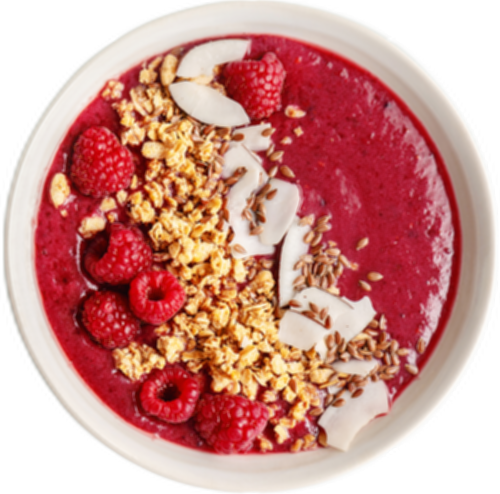

In [ ]:
from IPython.display import Image
Image('output.png')

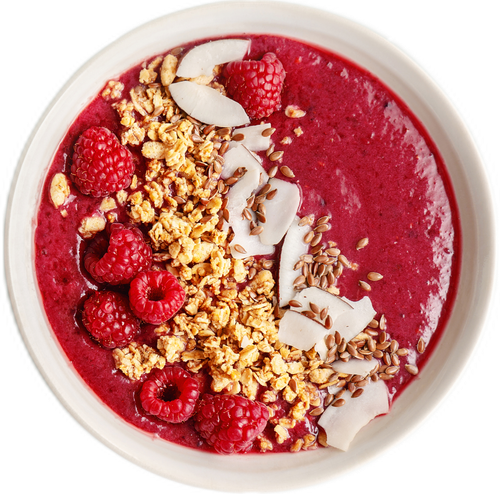

In [ ]:
from IPython.display import Image
Image('input.png')

### New Feature - Adjust Blur

In [ ]:
%%writefile adjust_blur.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <vector>
#include "lodepng.h"

__global__ void adjustableBoxBlurKernel(unsigned char *input, unsigned char *output, unsigned width, unsigned height, int kernelSize) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int halfKernel = kernelSize / 2;

    if (x < width && y < height) {
        int pixelPos = y * width + x;
        int numChannels = 4;  // RGBA channels
        int sumR = 0, sumG = 0, sumB = 0;
        int count = 0;

        for (int ky = -halfKernel; ky <= halfKernel; ky++) {
            for (int kx = -halfKernel; kx <= halfKernel; kx++) {
                int nx = x + kx;
                int ny = y + ky;
                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    int neighborPixelPos = (ny * width + nx) * numChannels;
                    sumR += input[neighborPixelPos];
                    sumG += input[neighborPixelPos + 1];
                    sumB += input[neighborPixelPos + 2];
                    count++;
                }
            }
        }

        int newPixelPos = pixelPos * numChannels;
        output[newPixelPos] = sumR / count;
        output[newPixelPos + 1] = sumG / count;
        output[newPixelPos + 2] = sumB / count;
        output[newPixelPos + 3] = input[newPixelPos + 3];  // Preserve alpha channel
    }
}

void processImageWithAdjustableBlur(const char* input_filename, const char* output_filename, int kernelSize) {
    std::vector<unsigned char> image;
    unsigned width, height;

    unsigned error = lodepng::decode(image, width, height, input_filename);
    if (error) {
        printf("Decoder error %u: %s\n", error, lodepng_error_text(error));
        return;
    }

    size_t imageSize = width * height * 4; // RGBA channels
    unsigned char *d_input, *d_output;

    cudaMalloc((void**)&d_input, imageSize);
    cudaMalloc((void**)&d_output, imageSize);

    cudaMemcpy(d_input, image.data(), imageSize, cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);
    adjustableBoxBlurKernel<<<gridSize, blockSize>>>(d_input, d_output, width, height, kernelSize);

    std::vector<unsigned char> output(image.size());
    cudaMemcpy(output.data(), d_output, imageSize, cudaMemcpyDeviceToHost);

    lodepng::encode(output_filename, output, width, height);

    cudaFree(d_input);
    cudaFree(d_output);
}

int main(int argc, char *argv[]) {
    const char* input_filename = argc > 1 ? argv[1] : "blurred_input.png";  // Use the output of the first blur as input here
    const char* output_filename = argc > 2 ? argv[2] : "more_blurred_output.png";
    int kernelSize = argc > 3 ? atoi(argv[3]) : 3;  // Default kernel size is 3, but can be adjusted via command line

    processImageWithAdjustableBlur(input_filename, output_filename, kernelSize);
    return 0;
}


Writing adjust_blur.cu


In [ ]:
!nvcc -o adjust_blur adjust_blur.cu lodepng.cpp

nvcc error   : 'gcc' died due to signal 2 


please edit the following number to adjust the blurriness

In [ ]:
!./adjust_blur input.png output.png 10

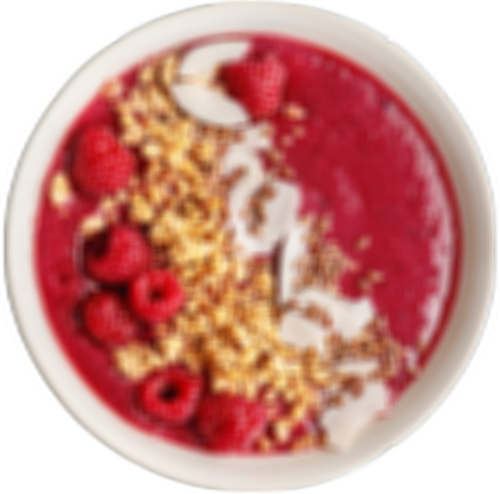

In [ ]:
from IPython.display import Image
Image('output.png')